In [7945]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import math

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1.1 - Importing the csv and taking a quick glance

In [7559]:
# Importing the scraped data
df = pd.read_csv('Datasets/dfconcat.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,title,price,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
0,Mercedes-Benz Vito Kasten 122 CDI lang Austaus...,8999,07/2013,Diésel,551000,165.0,2987,8.6,2,2,both-sided
1,Mercedes-Benz V 220 *Extra Lang*Kamera *PDC *Navi,20800,11/2016,Diésel,539000,120.0,2143,6.1,8,2,both-sided
2,Mercedes-Benz V 250 d Avantgarde Edition lang ...,19900,03/2016,Diésel,531766,140.0,2143,6.0,6,1,both-sided
3,Mercedes-Benz V -Klasse V 250 CDI/BT/d AVANTGARD,28600,06/2018,Diésel,520093,140.0,2143,6.0,8,1,both-sided
4,"Mercedes-Benz V 200 V/220 CDI/d, 250 CDI/BT/d ...",29990,12/2017,Diésel,519211,140.0,2143,6.0,8,1,both-sided


In [7560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21738 entries, 0 to 21737
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             21738 non-null  object 
 1   price             21738 non-null  int64  
 2   date              21738 non-null  object 
 3   fuel              21738 non-null  object 
 4   km                21738 non-null  int64  
 5   power_cv          21731 non-null  float64
 6   displacement_cm3  21738 non-null  int64  
 7   consumption       18910 non-null  object 
 8   seats             21738 non-null  int64  
 9   owners            21738 non-null  object 
 10  sliding_doors     21738 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.8+ MB


In [7561]:
df.columns

Index(['title', 'price', 'date', 'fuel', 'km', 'power_cv', 'displacement_cm3',
       'consumption', 'seats', 'owners', 'sliding_doors'],
      dtype='object')

In [7562]:
# getting the year from the date
df['year'] = df.date.apply(lambda x: x[-4:]) # we get the last 4 digits of the date to get the year
df['year'] = df['year'].astype(int)
# converting the date from str to datetime
df.date = pd.to_datetime(df.date, format='%m/%Y')
# sorting the columns 
columns_sorted = ['title', 'price', 'year', 'date', 'fuel', 'km', 'power_cv', 'displacement_cm3',
       'consumption', 'seats', 'owners', 'sliding_doors']
df = df.reindex(columns=columns_sorted)
df.head()

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
0,Mercedes-Benz Vito Kasten 122 CDI lang Austaus...,8999,2013,2013-07-01,Diésel,551000,165.0,2987,8.6,2,2,both-sided
1,Mercedes-Benz V 220 *Extra Lang*Kamera *PDC *Navi,20800,2016,2016-11-01,Diésel,539000,120.0,2143,6.1,8,2,both-sided
2,Mercedes-Benz V 250 d Avantgarde Edition lang ...,19900,2016,2016-03-01,Diésel,531766,140.0,2143,6.0,6,1,both-sided
3,Mercedes-Benz V -Klasse V 250 CDI/BT/d AVANTGARD,28600,2018,2018-06-01,Diésel,520093,140.0,2143,6.0,8,1,both-sided
4,"Mercedes-Benz V 200 V/220 CDI/d, 250 CDI/BT/d ...",29990,2017,2017-12-01,Diésel,519211,140.0,2143,6.0,8,1,both-sided


It automatically adds a default day (1) even though we only have information of month and year, but I want it in datetime, so I don't mind

In [7563]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21738 entries, 0 to 21737
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             21738 non-null  object        
 1   price             21738 non-null  int64         
 2   year              21738 non-null  int32         
 3   date              21738 non-null  datetime64[ns]
 4   fuel              21738 non-null  object        
 5   km                21738 non-null  int64         
 6   power_cv          21731 non-null  float64       
 7   displacement_cm3  21738 non-null  int64         
 8   consumption       18910 non-null  object        
 9   seats             21738 non-null  int64         
 10  owners            21738 non-null  object        
 11  sliding_doors     21738 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(5)
memory usage: 1.9+ MB


## Null values

In [7564]:
df.isna().sum()

title                  0
price                  0
year                   0
date                   0
fuel                   0
km                     0
power_cv               7
displacement_cm3       0
consumption         2828
seats                  0
owners                 0
sliding_doors          0
dtype: int64

In [7565]:
# percentage of null values of consumption
print(f"{df.consumption.isna().sum()/len(df)*100:.2f}")

13.01


We could check model by model the consumption of these rows with null values, but it's a lot of work and time and it's a small percentage, so I will just drop these rows

In [7566]:
df.shape

(21738, 12)

In [7567]:
df.dropna(inplace=True)
df.shape

(18903, 12)

In [7568]:
df.dropna(subset='power_cv', inplace=True)
df.shape

(18903, 12)

In [7569]:
df.power_cv = df['power_cv'].astype(int) # powers are integers, not floats

In [7570]:
df.seats = df.seats.astype(str) # I will try seats as a categorical variable

# 1.2 - Initial OLS model

In [7571]:
def OLS(df):
    numericals = df.select_dtypes(np.number) # we separate the X numerical variables
    y = numericals['price']
    X = numericals.drop(columns=['price']) # drop the constant
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # define the parameters
    lm = linear_model.LinearRegression() # create the model
    lm.fit(X_train, y_train) # train the model
    predictions = lm.predict(X_test) # calculate predictions
    
    r2 = r2_score(y_test, predictions)
    print(f'R2: {r2:.5f}')
    mse = mean_squared_error(y_test, predictions)
    print(f'MSE: {mse:.5f}')
    mape = np.mean(np.abs((y_test - predictions)/y_test)*100)
    print(f'MAPE: {mape:.5f}%')

In [7572]:
OLS(df)

R2: 0.73272
MSE: 96434466.68379
MAPE: 41.14608%


# **2. Data Cleaning**

This is where I check all the variables and I correct or delete incorrect values.

In [7573]:
df.head()

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
0,Mercedes-Benz Vito Kasten 122 CDI lang Austaus...,8999,2013,2013-07-01,Diésel,551000,165,2987,8.6,2,2,both-sided
1,Mercedes-Benz V 220 *Extra Lang*Kamera *PDC *Navi,20800,2016,2016-11-01,Diésel,539000,120,2143,6.1,8,2,both-sided
2,Mercedes-Benz V 250 d Avantgarde Edition lang ...,19900,2016,2016-03-01,Diésel,531766,140,2143,6.0,6,1,both-sided
3,Mercedes-Benz V -Klasse V 250 CDI/BT/d AVANTGARD,28600,2018,2018-06-01,Diésel,520093,140,2143,6.0,8,1,both-sided
4,"Mercedes-Benz V 200 V/220 CDI/d, 250 CDI/BT/d ...",29990,2017,2017-12-01,Diésel,519211,140,2143,6.0,8,1,both-sided


## 2.1 - ``title``

### 2.1.1 - Creating ``brand`` and ``model``

Theorically it looks like the first word should be the brand and the second one the model

There are many versions of Volkswagen Transporters, I cannot get them with only the second word, so I'm gonna filter them now before creating the column ``model``

In [7574]:
df[df.title.str.contains('Volkswagen Transporter')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
1325,Volkswagen Transporter T6 2.0 TDi SCR BMT DSG*...,17700,2019,2019-01-01,Diésel,182993,110,1968,5.8,5,1,both-sided
5223,Volkswagen Transporter T6 Caravelle EU6d-T 2.0...,41250,2020,2020-08-01,Diésel,79000,110,1968,6.9,8,1,both-sided
7729,Volkswagen Transporter T5 Kasten-Kombi 1.9 TDI...,6787,2007,2007-03-01,Diésel,289999,75,1896,7.7,7,1,right
9433,Volkswagen Transporter6.1 2.0 TDI DSG|LED|8SIT...,24900,2021,2021-10-01,Diésel,181890,110,1968,6.0,8,1,right
10273,Volkswagen Transporter6.1 2.0 TDI DSG|LED|8SIT...,26900,2021,2021-10-01,Diésel,156163,110,1968,6.0,8,1,right
10698,Volkswagen Transporter T6 2.0 TDI *AHK* Rückfa...,18890,2018,2018-11-01,Diésel,145369,110,1968,6.7,3,1,right
14186,Volkswagen Transporter 2.0TDI DSG Comfortline ...,46940,2020,2020-02-01,Diésel,79130,146,1968,8.3,5,1,right
14307,Volkswagen Transporter Kasten T6.1 KR EcoProfi...,26900,2021,2021-06-01,Diésel,77080,110,1968,7.8,3,1,right
18392,Volkswagen Transporter Multivan EU6d 2.0 TDI L...,58990,2024,2024-01-01,Diésel,29619,110,1968,6.5,7,1,both-sided
18654,Volkswagen Transporter Kombi LR 2.0 TDI AHK 9 ...,45990,2024,2024-05-01,Diésel,27677,110,1968,7.4,9,1,right


In [7575]:
df.title = np.where(df.title.str.contains('T6', case=False), 'Volkswagen T6', df.title) 
df.title = np.where(df.title.str.contains('T5', case=False), 'Volkswagen T5', df.title)  

Same thing with some the Ford Transit and Tourneo, they can be either Connect (simpler) or Custom (high-end features and bigger), I think it's important to tell them apart. Since many of the information is in the title, I will treat Ford separately to not get only the second word of the title as the model, but more words

In [7576]:
# I create a copy to preserve the original info
dftitle = df.copy()

In [7577]:
df.title[0] # the first van

'Mercedes-Benz Vito Kasten 122 CDI lang Austauschmotor von MB'

In [7578]:
# testing to get the brand out of the first word of the title
df.title[0].split(' ')[0]

'Mercedes-Benz'

In [7579]:
df['brand'] = df['title'].apply(lambda x: x.split(' ')[0]) # creating the new column 'brand'

In [7580]:
df[df['brand']=='Ford'].index # getting the indexes of the Ford vans

Index([    6,    13,    14,    19,    25,    74,   101,   115,   143,   152,
       ...
       21598, 21601, 21606, 21621, 21624, 21629, 21651, 21683, 21716, 21732],
      dtype='int64', length=2507)

In [7581]:
' '.join(df.title[6].split(' ')[1:5]) # testing to get the model out of the title

'Tourneo Custom 9 Sitze'

In [7582]:
df_Ford = df[df['brand']=='Ford']
df_Ford.shape

(2507, 13)

In [7583]:
df.shape

(18903, 13)

In [7584]:
df = df[~(df['brand']=='Ford')]
df.shape

(16396, 13)

In [7585]:
# applying the function to extract the brand and model from the title
df['brand'] = df['title'].apply(lambda x: x.split(' ')[0])
df['model'] = df['title'].apply(lambda x: x.split(' ')[1])
df_Ford['model'] = df_Ford['title'].apply(lambda x: ' '.join(x.split(' ')[1:5]))
df.sample(5)

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors,brand,model
18723,Volkswagen Caddy Maxi Life TDI DSG Bluetooth N...,38890,2024,2024-05-01,Diésel,27062,90,1968,5.3,7,1,both-sided,Volkswagen,Caddy
19532,Volkswagen T6,67910,2024,2024-03-01,Diésel,24987,110,1968,7.7,4,1,right,Volkswagen,T6
7496,Volkswagen T6,15200,2019,2019-03-01,Diésel,339900,110,1968,6.9,9,1,right,Volkswagen,T6
16451,Renault Kangoo Rapid Extra\n11.900 € (bruto)\n...,11900,2017,2017-08-01,Diésel,60000,81,1461,4.4,2,1,right,Renault,Kangoo
794,Renault Kangoo Privilege Tüv 11/2026 Klima,2199,2003,2003-06-01,Diésel,214700,60,1461,5.3,5,2,both-sided,Renault,Kangoo


In [7586]:
df_Ford.sample(5)

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors,brand,model
14755,Ford Transit Kasten 350 L3 Trend,16990,2021,2021-05-01,Diésel,69384,96,1995,6.8,3,1,right,Ford,Transit Kasten 350 L3
9776,Ford Transit Kombi FT 300 M-9 Sitzer-Scheckhef...,5950,2011,2011-12-01,Diésel,170285,63,2198,7.5,9,2,right,Ford,Transit Kombi FT 300
5769,Ford Tourneo Custom 320 L2 Titanium NAVI RFK P...,35999,2022,2022-08-01,Diésel,68761,96,1996,7.9,9,2,both-sided,Ford,Tourneo Custom 320 L2
14495,Ford Transit 2.2 TDCI Hoch+ Lang L2-H2 *Garant...,9900,2010,2010-06-01,Diésel,74000,85,2198,8.4,3,2,right,Ford,Transit 2.2 TDCI Hoch+
15611,Ford Transit Connect Kombi Trend 5 Sitzer HWS\...,16800,2018,2018-10-01,Diésel,48000,74,1499,6.3,5,1,both-sided,Ford,Transit Connect Kombi Trend


In [7587]:
df = pd.concat([df, df_Ford])
df.shape

(18903, 14)

In [7588]:
# deleting the title
df.drop(columns='title', inplace=True)

In [7589]:
df.columns

Index(['price', 'year', 'date', 'fuel', 'km', 'power_cv', 'displacement_cm3',
       'consumption', 'seats', 'owners', 'sliding_doors', 'brand', 'model'],
      dtype='object')

In [7590]:
# sorting the columns 
columns_sorted = ['brand', 'model', 'price', 'year', 'date', 'fuel', 'km', 'power_cv',
       'displacement_cm3', 'consumption', 'seats', 'owners', 'sliding_doors']
df = df.reindex(columns=columns_sorted)
df.sample(5)

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
13139,Renault,Trafic,14980,2019,2019-04-01,Diésel,96500,89,1598,6.5,3,1,right
2933,Volkswagen,Caddy,11950,2014,2014-03-01,Diésel,128800,75,1598,5.6,2,1,both-sided
3863,Citroën,Berlingo,13690,2017,2017-02-01,Diésel,105890,73,1560,4.1,5,1,both-sided
14431,Toyota,Proace,17380,2019,2019-08-01,Diésel,75000,85,1560,5.1,3,1,right
14788,Volkswagen,T6,47940,2020,2020-02-01,Diésel,68948,146,1968,8.8,7,1,right


We check again for duplicated rows, because earlier I noticed titles that were really similar, but one of them included the price as well and the other one didn't.

In [7591]:
df.duplicated().sum()

267

In [7592]:
df.shape

(18903, 13)

In [7593]:
df.drop_duplicates(inplace=True) # droping the duplicate rows
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.shape

(18636, 13)

### 2.1.2 - Checking the different models

In [7594]:
df.shape

(18636, 13)

In [7595]:
print(f'Number of brands: {df.brand.nunique()}')
print(f'Number of models: {df.model.nunique()}')

Number of brands: 24
Number of models: 1561


In [7596]:
df.groupby(["brand"]).agg({'model': 'nunique'}).sort_values('brand') # number of different models per brand

,model
brand,
Chevrolet,1
Chrysler,5
Citroën,28
Dacia,6
Fiat,17
Ford,1207
Hyundai,5
Iveco,2
Kia,1


In [7597]:
df[df['brand']=='Chevrolet'].groupby(["brand", "model"]).agg({'model': 'count'}).head(10)

,,model
brand,model,
Chevrolet,Astro,1


#### Chrysler

In [7598]:
df[df['brand']=='Chrysler'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand    model                                                    
Chrysler Grand                                                  16
         GrandVoya2.8                                            1
         Pacifica                                                3
         Pacifica3,6L-Plus.4x4.ACC.LED.7Sitze.nur52000km...      1
         Voyager                                                 7

In [7599]:
# after some digging I find that all of these models are big cars rather than vans
df.brand = np.where(df.brand=='Chrysler', np.nan, df.brand)
df.dropna(subset='brand', inplace=True)

#### Citroën

In [7600]:
df.model.nunique()

1558

In [7601]:
df[df['brand']=='Citroën'].model.nunique()

28

In [7602]:
df[df['brand'] == 'Citroën'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand   model              
Citroën "Campster"        1
        SpaceTourer-      1
        SpaceTourer,      1
        Multispace        1
        Kasten            1

In [7603]:
df[df['brand'] == 'Citroën'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand   model                                                  
Citroën Berlingo                                            407
        Jumpy                                                85
        Jumper                                               79
        SpaceTourer                                          40
        Spacetourer                                          18
        C8                                                   17
        Nemo                                                  8
        BERLINGO                                              3
        JUMPER                                                2
        9                                                     2
        Space                                                 2
        2.0                                                   2
        Shine                                                 2
        SPACE                                                 2
        Grand                                                 2
        SpaceTourer-                                          1
        SpaceTourer,                                          1
        Multispace                                            1
        "Campster"                                            1
        Kasten                                                1
        Jumpy*Kasten*Club                                     1
        Jumpy*Business                                        1
        JumperL2H2                                            1
        Jumper/9-Sitzer/L2H2/Vollausstattung/AHK/1-Hand/      1
        Citröen                                               1
        Berlingo*Kasten                                       1
        ALLRAD                                                1
        VANDERER                                              1

In [7604]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Citroën Jumper')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
1657,Citroën Jumper Kombi 30 L2H2 Live Blue-HDi +KL...,9490,2018,2018-01-01,Diésel,168000,96,1997,5.8,6,1,left
1911,Citroën Jumper 2.2 HDi Kasten 33 L2H1 150 FAP ...,7950,2011,2011-11-01,Diésel,159550,110,2198,7.5,3,2,both-sided
2062,Citroën Jumper Pritsche Doka. 33 L3 BlueHDi 130,11990,2018,2018-04-01,Diésel,154000,96,1997,6.4,7,1,both-sided
3986,Citroën Jumper Grossraumkasten 35 L4H2 Club He...,18750,2022,2022-09-01,Diésel,102000,103,2179,6.3,3,1,both-sided
4070,Citroën Jumper Kasten Business BlueHDi 1.Hand ...,10990,2018,2018-03-01,Diésel,100000,96,1997,5.8,3,1,both-sided
...,...,...,...,...,...,...,...,...,...,...,...,...
16546,Citroën Jumper 35 L3H3 Profi Heavy Ladebordwan...,22999,2017,2017-08-01,Diésel,59000,120,1997,6.4,3,1,right
16548,Citroën Jumper Kasten 30 L1H1 Profi BlueHDi 11...,15990,2018,2018-10-01,Diésel,59000,81,1997,6.0,3,1,right
16695,Citroën JumperL2H2 HDi 130*Behindertengerecht*...,25400,2015,2015-07-01,Diésel,57000,96,2198,7.2,4,1,right
16916,Citroën Jumper Grossraumkasten 35 L3H2 *41.000...,21750,2015,2015-06-01,Diésel,41000,96,2198,7.5,3,1,both-sided


In [7605]:
df[df.model==('Shine')]

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
3352,Citroën,Shine,21899,2020,2020-08-01,Diésel,96000,96,1499,4.2,5,1,both-sided
3917,Citroën,Shine,16900,2019,2019-08-01,Gasolina,81000,81,1199,5.5,5,2,both-sided


In [7606]:
# after some digging I can change the wrong values
df.model = np.where(df.model.str.contains('Campster'), 'SpaceTourer', df.model)
df.model = np.where(df.model.str.contains('Space', case=False), 'SpaceTourer', df.model)
df.model = np.where(df.model.str.contains('Berlingo', case=False), 'Berlingo', df.model)
df.model = np.where(df.model.str.contains('Jumper', case=False), 'Jumper', df.model)
df.model = np.where(df.model.str.contains('Jumpy'), 'Jumpy', df.model)
df.model = np.where(((df.model=='1.6') & (df.brand=='Citroën')), 'Berlingo', df.model)
df.model = np.where(((df.model=='2.0') & (df.price==4490)), np.nan, df.model) # I cannot find it, maybe it has been sold
df.model = np.where(((df.model=='2.0') & (df.price==20880)), 'Jumpy', df.model)
df.model = np.where(((df.model=='ALLRAD') & (df.brand=='Citroën')), 'Jumpy', df.model)
df.model = np.where(((df.model=='9') & (df.price==21890)), 'Jumpy', df.model)
df.model = np.where(((df.model=='9') & (df.price==21999)), 'Jumpy', df.model)
df.model = np.where(df.model==('VANDERER'), 'Berlingo', df.model)
df.model = np.where(df.model==('Citröen'), 'Berlingo', df.model)
df.model = np.where(df.model==('Citroen'), 'SpaceTourer', df.model)
df.model = np.where(((df.model=='C8') & (df.brand=='Citroën')), np.nan, df.model) # it's a big car rather than a van
df.model = np.where(((df.model=='Grand') & (df.brand=='Citroën')), np.nan, df.model) # it's a big car rather than a van
df.model = np.where(df.model==('Grossraumkasten'), 'Jumper', df.model)
df.model = np.where(((df.model=='Kasten') & (df.brand=='Citroën')), 'Jumpy', df.model)
df.model = np.where(df.model==('Shine'), np.nan, df.model) # it's a car, not a van

df.dropna(subset='model', inplace=True) 

In [7607]:
df[df['brand'] == 'Citroën'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand   model             
Citroën Berlingo       413
        Jumpy           92
        Jumper          83
        SpaceTourer     66
        Nemo             8

<Axes: xlabel='count', ylabel='model'>

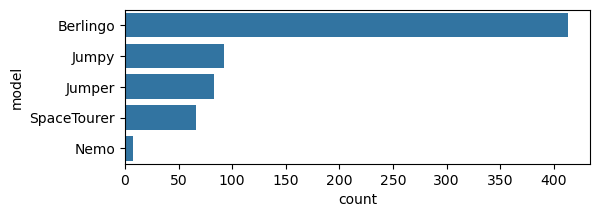

In [7608]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Citroën'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Citroën'], y='model', order=order)

In [7609]:
df.model.nunique() # checking again the number of total different models

1538

In [7610]:
df[df['brand']=='Citroën'].model.nunique() # checking again the number of different models of Citroën

5

#### Dacia

In [7611]:
df[df['brand']=='Dacia'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand model                         
Dacia DOKER                        1
      DOKKER                       4
      Diesel/Klima/95ps/Euro6      1
      Dokker                     122
      LODGY                        1
      Lodgy                        2

In [7612]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Diesel/Klima/95ps/Euro6')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
4447,Dacia Diesel/Klima/95ps/Euro6,12900,2020,2020-11-01,Diésel,93777,70,1461,6.2,5,1,both-sided


In [7613]:
df[df.model.str.contains('DOKKER')]

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
2720,Dacia,DOKKER,8990,2016,2016-11-01,Gasolina,115880,85,1197,6.7,5,1,both-sided
5090,Dacia,DOKKER,14990,2018,2018-09-01,Gasolina,53769,85,1197,5.7,5,1,both-sided
9685,Dacia,DOKKER,8900,2019,2019-12-01,Diésel,99883,70,1461,4.2,2,1,right
13976,Dacia,DOKKER,15900,2020,2020-12-01,Gasolina,24440,96,1332,6.2,5,1,both-sided


In [7614]:
df[df.model==('Lodgy')]

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
3258,Dacia,Lodgy,7700,2015,2015-10-01,Gasolina,98950,85,1197,5.7,5,2,both-sided
8060,Dacia,Lodgy,7999,2015,2015-07-01,Gasolina,148000,61,1598,7.0,2,1,right


In [7615]:
# after some digging I can change the wrong values
df.model = np.where(df.model.str.contains('DOKER', case=False), 'Dokker', df.model)
df.model = np.where(df.model.str.contains('DOKKER', case=False), 'Dokker', df.model)
df.model = np.where(df.model.str.contains('LODGY', case=False), np.nan, df.model) # it's a big car rather than a van
df.model = np.where(df.model=='Diesel/Klima/95ps/Euro6', 'Dokker', df.model)

df.dropna(subset='model', inplace=True) 

In [7616]:
df[df['brand']=='Dacia'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking again the different models after the clean-up

,,model
brand,model,
Dacia,Dokker,128


In [7617]:
df.model.nunique() # checking again the number of total different models

1533

#### Fiat

In [7618]:
df[df['brand']=='Fiat'].model.nunique() # checking the number of different models of Fiat

17

In [7619]:
df[df['brand'] == 'Fiat'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand model                              
Fiat  2.0                               1
      DOBLO                             1
      DOBLO°MY                          1
      QUBO                              1
      DUCATO*2.2*KASTEN*HOCH+LANG*      1

In [7620]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Fiat 2.0')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
17087,"Fiat 2.0 KASTEN NAVI,KAMERA,KLIMA,TEMPOMAT,SH\...",17880,2021,2021-09-01,Diésel,40000,88,1997,5.6,3,1,right


In [7621]:
df[df.model.str.contains('Fiorino')]

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
2800,Fiat,Fiorino,6990,2010,2010-08-01,Diésel,113000,55,1248,4.5,5,2,both-sided
6291,Fiat,Fiorino,4490,2017,2017-04-01,Diésel,238000,59,1248,4.4,2,1,right
7148,Fiat,Fiorino,1490,2008,2008-10-01,Gasolina,184570,54,1360,6.9,2,2,right
7242,Fiat,Fiorino1.3,5500,2016,2016-05-01,Diésel,180000,55,1248,4.3,2,1,right
7343,Fiat,Fiorino,5200,2017,2017-05-01,Diésel,176000,59,1248,4.4,2,3,right
7883,Fiat,Fiorino,4890,2011,2011-07-01,Diésel,153903,70,1248,4.5,5,2,right
8018,Fiat,Fiorino,5800,2017,2017-06-01,Diésel,149000,59,1248,3.8,2,2,right
8394,Fiat,Fiorino,3650,2010,2010-04-01,Diésel,136900,55,1248,4.5,2,2,right
9287,Fiat,Fiorino,6395,2018,2018-04-01,Gasolina,110000,57,1368,6.9,2,2,right
9465,Fiat,Fiorino,7500,2017,2017-05-01,Diésel,105120,59,1248,4.4,2,2,right


In [7622]:
df[df.model==('2.0')].query("brand=='Fiat'")

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
12612,Fiat,2.0,17880,2021,2021-09-01,Diésel,40000,88,1997,5.6,3,1,right


In [7623]:
df[df.model==('Ulysse')]

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
762,Fiat,Ulysse,1799,2005,2005-03-01,Diésel,200142,94,2179,7.3,7,2,both-sided
1007,Fiat,Ulysse,4999,2005,2005-04-01,Diésel,186000,94,2179,7.3,6,1,both-sided


In [7624]:
# after some digging I can change the wrong values
df.model = np.where(df.model.str.contains('Doblo', case=False), 'Doblo', df.model)
df.model = np.where(df.model.str.contains('Doblò'), 'Doblo', df.model)
df.model = np.where(df.model.str.contains('Ducato', case=False), 'Ducato', df.model)
df.model = np.where(df.model.str.contains('Fiorino', case=False), 'Fiorino', df.model)
df.model = np.where(((df.model=='2.0') & (df.brand=='Fiat')), 'Talento', df.model)
df.model = np.where(df.model.str.contains('QUBO', case=False), 'Qubo', df.model)
df.model = np.where(((df.model=='Ulysse') & (df.brand=='Fiat')), np.nan, df.model) # it's a big car rather than a van

df.dropna(subset='model', inplace=True) 

In [7625]:
df[df['brand'] == 'Fiat'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand model         
Fiat  Doblo      135
      Ducato      92
      Talento     74
      Scudo       40
      Fiorino     20
      Qubo        19

<Axes: xlabel='count', ylabel='model'>

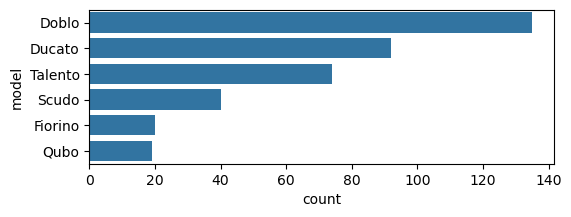

In [7626]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Fiat'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Fiat'], y='model', order=order)

In [7627]:
df.model.nunique() # checking again the number of total different models

1523

In [7628]:
df[df['brand']=='Fiat'].model.nunique() # checking again the number of different models of Fiat

6

#### Ford

This is probably going to be the most laborious brand, since before I noticed that the model is not just the second word of the title, so I took 5 words and here I will encounter a lot of different models.

In [7629]:
df[df['brand'] == 'Ford'].model.nunique()

1207

In [7630]:
df[df['brand'] == 'Ford'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False).head() # checking the different models

count
brand model                            
Ford  Transit Custom Kasten 300      88
      Transit Custom Kasten 320      44
      Transit Custom 2.0 EcoBlue     44
      Transit Custom Kasten 280      43
      Transit Kombi FT 300           30

In [7631]:
# deleting the models which are cars and not vans
df['model'] = np.where(df.model.str.contains('B-Max', case=False), np.nan, df.model)  # it's a car, not a van
df.model = np.where(df.model.str.contains('C-Max', case=False), np.nan, df.model)  # it's a car, not a van
df.model = np.where(df.model.str.contains('CMax', case=False), np.nan, df.model)  # it's a car, not a van
df.model = np.where(df.model.str.contains('S-Max', case=False), np.nan, df.model)  # it's a car, not a van
df.model = np.where((df.model.str.contains('2.0-TDI')), np.nan, df.model)  # it's a car, not a van
df.model = np.where((df.model.str.contains('Galaxy')), np.nan, df.model) # it's a car, not a van
df.dropna(subset='model', inplace=True) 

In [7632]:
df[df['brand'] == 'Ford'].model.nunique()

1073

In [7633]:
df.model = np.where(df.model.str.contains('Cust', case=False), 'Custom', df.model)
df.model = np.where(df.model.str.contains('Connect', case=False), 'Connect', df.model)

In [7634]:
df[df['brand'] == 'Ford'].model.nunique()

313

After some research I found that there is more difference between the Custom and the Connect models that between the Ford Transit or Ford Tourneo, meaning the Ford Tourneo Custom and Ford Transit Custom are more similar between them than for example the Ford Transit Custom and the Ford Transit Connect.

Also, there is a model called the Ford Transit, which is even bigger.

After a long time doing research I decide to split the Ford vans into 3 models, from small to large: Connect, Custom and Transit, because later I will classify the models per size, I'm not gonna keep all the models, that would be too much.

I do this by taking a look at pictures, either on internet or the original advertisement of the van.

In [7635]:
# after some digging I can change the wrong values

df.model = np.where((df.model.str.contains('L2')) & (df.brand=='Ford'), 'Custom', df.model)
df.model = np.where((df.model.str.contains('L3')) & (df.brand=='Ford'), 'Transit', df.model)
df.model = np.where((df.model.str.contains('L4')) & (df.brand=='Ford'), 'Transit', df.model)

df.model = np.where((df.model.str.contains('350')) & (df.brand=='Ford'), 'Transit', df.model)
df.model = np.where((df.model.str.contains('300')) & (df.brand=='Ford'), 'Custom', df.model)
df.model = np.where((df.model.str.contains('280')) & (df.brand=='Ford'), 'Custom', df.model)
df.model = np.where((df.model.str.contains('260')) & (df.brand=='Ford'), 'Custom', df.model)

df.model = np.where(df.model.str.contains('Courier', case=False), 'Connect', df.model)

df.model = np.where(df.model.str.contains('Grand Tourneo', case=False), 'Connect', df.model)

df.model = np.where(df.model=='Grand Tourneo Active Pano', 'Connect', df.model)
df.model = np.where(df.model=='Grand Tourneo Active LED', 'Connect', df.model)
df.model = np.where(df.model=='TRANSIT CUSTOM 2.0 TDCI', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi 2.0 FT', 'Custom', df.model)
df.model = np.where(df.model=='TRANSIT/Tourneo CUSTOM TREND Kombi', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2.2 TDCi 1.Hand', 'Custom', df.model)
df.model = np.where(df.model=='Transit 4x4 / 4WD', 'Transit', df.model)
df.model = np.where(df.model=='Transit 3.5 T*Hoch+Lang*Klima*Tempomat*AHK*MwSt*', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.4*7-Sitzer*Klimaanlage*Schiebetüren*', 'Transit', df.model)
df.model = np.where(df.model=='Transit 9 Sitzer KLIMA', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2.4 /Automatik/Tüv NEU/Wohnmobil', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi *7-SITZE* 1.HAND+TISCH+GARDINEN\n15.990', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kasten kurz 2.0', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi *9 Sitzer*S-Heft*TÜV', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kasten 2.0 TDCi', 'Transit', df.model)
df.model = np.where(df.model=='Transit Cust 2.0d Aut', 'Custom', df.model)
df.model = np.where(df.model=='Transit Cour 1.5d Trend', 'Connect', df.model)
df.model = np.where(df.model=='Transit Conn 1.5 Lang', 'Connect', df.model)
df.model = np.where(df.model=='Transit Kombi *ROLLSTUHL-LIFT* KLIMA', 'Transit', df.model)
df.model = np.where(df.model=='1.5 EB TITANIUM 7', 'Connect', df.model)
df.model = np.where(df.model=='Transit Bürstner SIGNEO C', 'Transit', df.model)

df.model = np.where(df.model=='Transit 2.0 EcoBlue*9-Sitze*Kamera*ACC*Navi*Temp', 'Transit', df.model)
df.model = np.where(df.model=='Transit Kombi 2.4 FT', 'Transit', df.model)
df.model = np.where(df.model=='Bürstner SIGNEO Automatik MARKISE', 'Transit', df.model)
df.model = np.where(df.model=='Bürstner SIGNEO Schlafdach Automatik', 'Transit', df.model)
df.model = np.where(df.model=='Transit*9Sitze*Rollstuhlrampe*Klima*Standheizung', 'Transit', df.model)
df.model = np.where(df.model=='Transit*8 Sitze*Klima*Standheizung*Tempomat*', 'Transit', df.model)
df.model = np.where(df.model=='Transit Wohnmobi 2.0 FT', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.0 TDCI Kombi', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.0 TDCI Kasten', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.0 TDCi Kast.', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.2 Kombi FT', 'Transit', df.model)
df.model = np.where(df.model=='Hoch&Lang*Wohnmobil Umbau Möglich*Klima*AHK*', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.2 TDCI 115', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.2 TDCI Hoch+', 'Transit', df.model)
df.model = np.where(df.model=='TRANSIT VOLL-BEHINDERTENGERECHT/KAMERA/AUTOMATIK', 'Transit', df.model)
df.model = np.where(df.model=='Transit 2.2 Trend Rollstuhllift', 'Transit', df.model)
df.model = np.where(df.model=='Transit Kombi 310 2.2', 'Transit', df.model)
df.model = np.where(df.model=='Transit Kombi 9 Sitzer', 'Transit', df.model)
df.model = np.where(df.model=='Transit Kombi Mixto FT', 'Transit', df.model)

df.model = np.where(df.model=='Transit Kombi /Klima/Tüv Neu/1', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2,2Tdci Hochdach Klima', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2,2L Euro5 FT', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2,2 TDCi.Kasten.Mit Laderaumkühlung.', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi 9 Sitze,', 'Custom', df.model)
df.model = np.where(df.model=='Transit Bürstner Copa C', 'Custom', df.model)
df.model = np.where(df.model=='2.0 EcoBlue 320 Titanium', 'Custom', df.model)
df.model = np.where(df.model=='2.0 TDCi L1H1 STANDHZ,NAVI,KAMERA\n24.880', 'Custom', df.model)
df.model = np.where(df.model=='2.2 TDCI Kasten 250', 'Custom', df.model)
df.model = np.where(df.model=='2.2 TDCi SPORT Umbau', 'Custom', df.model)
df.model = np.where(df.model=='320 L1 Tourneo Titanium', 'Custom', df.model)
df.model = np.where(df.model=='340 9 SITZE NAVI,CARPLAY,SPUR,DAB\n24.880', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi hoch/9 Sitze/Tüv', 'Custom', df.model)
df.model = np.where(df.model=='Transit*Klima*Navigation*6 Sitzer*Scheckheft*', 'Custom', df.model)
df.model = np.where(df.model=='Transit Nugget 2.2TDCi Hochdach-Markise-AHK-SHZ-', 'Custom', df.model)
df.model = np.where(df.model=='Transit L1,36.200km,Garantie,Regale,AHK,TÜV 8/26\n17.299 €', 'Custom', df.model)
df.model = np.where(df.model=='Transit L1 #Klima #3-Sitzer', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2.2 TDCI Kasten', 'Custom', df.model)
df.model = np.where(df.model=='TRANSIT2.0TDCI COSTUM KASTEN/TÜV NEU+SERVICE', 'Custom', df.model)
df.model = np.where(df.model=='Transit 2.2 TDCI Kastenwagen', 'Custom', df.model)
df.model = np.where(df.model=='Tourneo 2.0 TDCi Trend', 'Custom', df.model)
df.model = np.where(df.model=='Tourneo Titanium X 320', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi FT 330', 'Custom', df.model)
df.model = np.where(df.model=='Transit Kombi FT 9', 'Custom', df.model)
df.model = np.where(df.model=='Transit/Tourneo Titanium *KLIMA*8.SITZER*AHK*\n21.499 €', 'Custom', df.model)

df.model = np.where(df.model=='Transit 1.8 TDCI Kasten', 'Connect', df.model)
df.model = np.where(df.model=='Grand Tour 1.5 Lang', 'Connect', df.model)
df.model = np.where(df.model=='Tourn Cour 1.5d Ambi', 'Connect', df.model)
df.model = np.where(df.model=='Tourneo Conn 1.5 Lang', 'Connect', df.model)
df.model = np.where(df.model=='Tourneo/RFK/DAB/NAVI/SHZ/SLPS/', 'Connect', df.model)
df.model = np.where(df.model=='Transit 1 Jahr Garantie/Tüv', 'Connect', df.model)

In [7636]:
df[df['brand'] == 'Ford'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking the different models

count
brand model         
Ford  Custom    1531
      Connect    529
      Transit    220

In [7637]:
df.model.nunique() # checking again the number of total different models

319

#### Hyundai

In [7638]:
df[df['brand']=='Hyundai'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand   model                 
Hyundai H-1                 46
        H350                 4
        STARIA              34
        STARIA*6.SITZE*      1
        Staria              12

In [7639]:
# after some digging I can change the wrong values
df.model = np.where(df.model.str.contains('Staria*', case=False), 'Staria', df.model)
df.model = np.where(((df.model=='H1') & (df.brand=='Hyundai')), 'H-1', df.model)

In [7640]:
df[df['brand']=='Hyundai'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking again the different models after the clean-up

model
brand   model        
Hyundai H-1        46
        H350        4
        Staria     47

#### Iveco

In [7641]:
df[df['brand']=='Iveco'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand model       
Iveco Daily      2
      Other      1

In [7642]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Iveco Other')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
7279,Iveco Other Daily,81500,2015,2015-10-01,Diésel,480000,96,2300,8.0,3,2,right


In [7643]:
# after some digging I can change the wrong values
df.model = np.where(((df.model=='Other') & (df.brand=='Iveco')), 'Daily', df.model)

In [7644]:
df[df['brand']=='Iveco'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking again the different models after the clean-up

,,model
brand,model,
Iveco,Daily,3


#### Kia

In [7645]:
df[df['brand'].str.contains('Kia')].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

,,model
brand,model,
Kia,Carnival,6
Kia-Carnival,2.9,1


In [7646]:
df[df.brand==('Kia-Carnival')]

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
1506,Kia-Carnival,2.9,6990,2008,2008-02-01,Diésel,160000,136,2902,9.0,7,3,both-sided


In [7647]:
# after some digging I can change the wrong values
df.model = np.where(df.model=='Carens', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='Carnival', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.brand=='Kia-Carnival', np.nan, df.model) # it's a car, not a van
df.dropna(subset='model', inplace=True) 

In [7648]:
df.model.nunique() # checking again the number of total different models

314

#### Lancia

In [7649]:
df[df['brand']=='Lancia'].model.nunique() # checking the number of different models of Fiat

3

In [7650]:
df[df['brand']=='Lancia'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand  model         
Lancia 2.8          1
       S            1
       Voyager     44

In [7651]:
# after some digging I find that all of these models are big cars rather than vans
df.brand = np.where(df.brand=='Lancia', np.nan, df.brand)
df.dropna(subset='brand', inplace=True) 

In [7652]:
df.model.nunique() # checking again the number of total different models

311

#### MAN

In [7653]:
df[df['brand']=='MAN'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

,,model
brand,model,
MAN,TGE,2


All good, it's a van

#### Mazda

In [7654]:
df[df['brand'].str.contains('Mazda*')].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand  model                      
Mazda  1.8                       1
       5                        96
       5*150PS*NAVI*RFK*PDC      1
       5/1.6                     1
       MPV                       1
Mazda5 2.0                       1

In [7655]:
# after some digging I find that all of these models are big cars rather than vans
df.brand = np.where(df.brand.str.contains('Mazda'), np.nan, df.brand)
df.dropna(subset='brand', inplace=True)

#### Mercedes-Benz

In [7656]:
df[df['brand']=='Mercedes-Benz'].model.nunique() # checking the number of different models of Mercedes-Benz

107

In [7657]:
df[df['brand'] == 'Mercedes-Benz'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand         model                                                    
Mercedes-Benz 109                                                     1
              V250d*AMG-Avantgarde*Lang*Leder*DTR+*Comand*\n3...      1
              V250*EXTRALANG                                          1
              V220CDI/BlueTEC                                         1
              V220CDI                                                 1

In [7658]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Mercedes-Benz Tourer')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
14117,Mercedes-Benz Tourer 110 CDI LANG 9 SITZE KLIM...,25880,2020,2020-08-01,Diésel,80000,75,1750,6.7,9,1,right
15431,Mercedes-Benz Tourer 119 CDI 4M LANG 8 SITZE S...,53680,2023,2023-09-01,Diésel,50000,140,1950,8.0,8,1,right
16545,Mercedes-Benz Tourer 119 CDI 4M LANG 8 SITZE S...,53680,2023,2023-08-01,Diésel,59000,140,1950,8.0,8,1,right
16631,Mercedes-Benz Tourer 110 CDI LANG 9 SITZE KLIM...,26880,2020,2020-08-01,Diésel,57844,75,1749,6.7,9,1,right


In [7659]:
df[df.model==('Tourer')] # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in (the next line of code)

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
10548,Mercedes-Benz,Tourer,25880,2020,2020-08-01,Diésel,80000,75,1750,6.7,9,1,right
11460,Mercedes-Benz,Tourer,53680,2023,2023-09-01,Diésel,50000,140,1950,8.0,8,1,right
12234,Mercedes-Benz,Tourer,53680,2023,2023-08-01,Diésel,59000,140,1950,8.0,8,1,right
12299,Mercedes-Benz,Tourer,26880,2020,2020-08-01,Diésel,57844,75,1749,6.7,9,1,right


In [7660]:
df[df.model.str.contains('d')].query("brand == 'Mercedes-Benz'")

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
305,Mercedes-Benz,V250d,28990,2018,2018-07-01,Diésel,257000,140,2143,6.0,7,1,both-sided
340,Mercedes-Benz,V250d*AMG-Avantgarde*Lang*Leder*DTR+*Comand*\n...,30900,2018,2018-04-01,Diésel,250000,140,2143,6.0,5,2,both-sided
473,Mercedes-Benz,V250d,29999,2018,2018-02-01,Diésel,232000,140,2143,6.0,7,1,both-sided
494,Mercedes-Benz,V250dEXCLUSIVE,36999,2018,2018-06-01,Diésel,230000,140,2143,6.7,6,2,both-sided
813,Mercedes-Benz,V250d,39850,2017,2017-07-01,Diésel,199000,140,2143,6.0,7,2,both-sided
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15587,Mercedes-Benz,V300d,68990,2024,2024-02-01,Diésel,13100,174,1950,7.7,6,1,both-sided
15594,Mercedes-Benz,Citan-Automatik-Behindertengerecht-Rampe-\n32.900,32900,2017,2017-08-01,Gasolina,13000,84,1192,6.1,4,2,both-sided
15749,Mercedes-Benz,V250d,81890,2024,2024-03-01,Diésel,11743,140,1950,8.2,7,1,both-sided
15845,Mercedes-Benz,V250d,78950,2024,2024-04-01,Diésel,10628,140,1950,7.4,7,1,both-sided


In [7661]:
df[df.model.str.contains('T18')].brand.unique()

array(['Mercedes-Benz'], dtype=object)

In [7662]:
df[df.model==('Transit')].query("brand == 'Mercedes-Benz'")

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7663]:
# after some digging I can change the wrong values

df.model = np.where(df.model=='109', 'Vito', df.model)
df.model = np.where(df.model=='110', 'Vito', df.model)
df.model = np.where(df.model=='111', 'Vito', df.model)
df.model = np.where(df.model=='114', 'Vito', df.model)
df.model = np.where(df.model=='116', 'Vito', df.model)
df.model = np.where(df.model=='119', 'Vito', df.model)
df.model = np.where(df.model=='124', 'Vito', df.model)
df.model = np.where((df.model=='2.0') & (df.brand=='Mercedes-Benz'), 'Vito', df.model)
df.model = np.where((df.model=='2.2') & (df.brand=='Mercedes-Benz'), 'Viano', df.model)
df.model = np.where(df.model=='211', 'Sprinter', df.model)
df.model = np.where(df.model=='214', 'Sprinter', df.model)
df.model = np.where(df.model=='220', 'Marco Polo', df.model)
df.model = np.where((df.model=='250') & (df.price<39900), 'V', df.model)
df.model = np.where(df.model=='250', 'Marco Polo', df.model)
df.model = np.where(df.model=='250d', 'Marco Polo', df.model)
df.model = np.where(df.model=='2x', 'Sprinter', df.model)
df.model = np.where((df.model=='3.0') & (df.price==15790), 'Viano', df.model)
df.model = np.where(df.model=='300', 'Marco Polo', df.model)
df.model = np.where(df.model=='314', 'Sprinter', df.model)
df.model = np.where(df.model=='316', 'Sprinter', df.model)
df.model = np.where(df.model=='316CDI', 'Sprinter', df.model)
df.model = np.where(df.model=='317', 'Sprinter', df.model)
df.model = np.where(df.model=='3x', 'Sprinter', df.model)
df.model = np.where(df.model=='4M', 'Viano', df.model)
df.model = np.where(df.model=='4MATIC*BESTPREIS*Facelift*MBUX*LED*Erstbesitz*', 'V', df.model)
df.model = np.where(df.model=='AVANTG.+LANG+360°+4X4+AMG-L+NIGHT+AIRMATIC+BURM', 'V', df.model)
df.model = np.where(df.model=='AVANTGARDE', 'V', df.model)
df.model = np.where(df.model=='BURM', 'V', df.model)
df.model = np.where(df.model.str.contains('Citan', case=False), 'Citan', df.model)
df.model = np.where(df.model=='II', 'Sprinter', df.model)
df.model = np.where(df.model=='Klasse', 'V', df.model)
df.model = np.where((df.model=='Kombi') & (df.brand=='Mercedes-Benz'), 'Citan', df.model)
df.model = np.where(df.model.str.contains('Vito', case=False), 'Vito', df.model)
df.model = np.where(df.model.str.contains('Marco', case=False), 'Marco Polo', df.model)
df.model = np.where(df.model=='Kühlkoffer,', 'Sprinter', df.model)
df.model = np.where(df.model=='Lang', 'Vito', df.model)
df.model = np.where(df.model=='Lang/Burmester®/Standheizung/', 'V', df.model)
df.model = np.where(df.model=='MERCEDES', 'Marco Polo', df.model)
df.model = np.where(df.model.str.contains('Sprinter', case=False), 'Sprinter', df.model)
df.model = np.where(df.model.str.contains('Viano', case=False), 'Viano', df.model)
df.model = np.where(df.model=='MIXTO114', 'Vito', df.model)
df.model = np.where(df.model=='Mercedes', 'Sprinter', df.model)
df.model = np.where(df.model=='Mixto', 'Vito', df.model)
df.model = np.where(df.model=='Progressive', 'T', df.model)
df.model = np.where((df.model.str.contains('V3.', case=False)) & (df.brand=='Mercedes-Benz'), 'V', df.model)
df.model = np.where((df.model.str.contains('V2.', case=False)) & (df.brand=='Mercedes-Benz'), 'V', df.model)
df.model = np.where((df.model.str.contains('V-.', case=False)) & (df.brand=='Mercedes-Benz'), 'V', df.model)
df.model = np.where(df.model=='R', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='dLang', 'V', df.model)
df.model = np.where((df.model=='d') & (df.price==59880), 'Marco Polo', df.model)
df.model = np.where(df.model=='d', 'V', df.model)
df.model = np.where(df.model=='Vaneo', np.nan, df.model) # it's a car rather than a van
df.model = np.where(df.model.str.contains('T18'), 'T', df.model)
df.model = np.where(df.model.str.contains('T-'), 'T', df.model)
df.model = np.where(df.model=='VIP', 'Vito', df.model)
df.model = np.where(df.model=='VKlasse', 'V', df.model)
df.model = np.where(df.model=='Zwillingsbereifung', 'Sprinter', df.model)
df.model = np.where((df.model=='Transit') & (df.brand=='Mercedes-Benz'), 'Vito', df.model)
df.model = np.where(df.model=='Tourer', 'Vito', df.model)

df.dropna(subset='model', inplace=True) 

In [7664]:
df[df['brand']=='Mercedes-Benz'].model.nunique() # checking the number of different models of Mercedes-Benz

7

In [7665]:
df[df['brand'] == 'Mercedes-Benz'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand         model            
Mercedes-Benz V            2454
              Vito         1477
              Sprinter      980
              Citan         314
              T             174
              Viano         129
              Marco Polo     71

<Axes: xlabel='count', ylabel='model'>

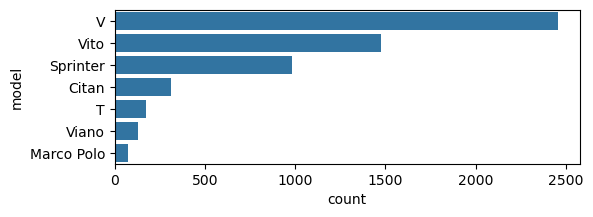

In [7666]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Mercedes-Benz'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Mercedes-Benz'], y='model', order=order)

In [7667]:
df.model.nunique() # checking again the number of total different models

208

#### Mitsubishi

In [7668]:
df[df['brand']=='Mitsubishi'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand      model             
Mitsubishi L300             1
           SpaceTourer      1

In [7669]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Mitsubishi Transit')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7670]:
df[df.model==('Transit')].query("brand == 'Mitsubishi'") 

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7671]:
# after some digging I can change the wrong values
df.model = np.where((df.model=='Transit') & (df.brand=='Mitsubishi'), np.nan, df.model) # it's a car, not a van
df.dropna(subset='model', inplace=True) 

In [7672]:
df.model.nunique() # checking again the number of total different models

208

#### Nissan

In [7673]:
df[df['brand']=='Nissan'].model.nunique() # checking the number of different models of Nissan

16

In [7674]:
df[df['brand'] == 'Nissan'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count') # checking the different models

count
brand  model              
Nissan KASTEN            1
       Kubistar          1
       NV250/            1
       NV300*2,9t        1
       NV300*Mixto       1
       PRIMASTAR         1
       Serena            1
       NV200/Evalia      3
       TOWNSTAR          3
       Evalia            4
       NV250             5
       Primastar        10
       Townstar         20
       NV400            23
       NV300            31
       NV200            52

In [7675]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Nissan Evalia')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
842,Nissan Evalia 1.5/81KW/AHK/TEMPO/ALU/KAMERA/S-...,8400,2014,2014-10-01,Diésel,210000,81,1461,5.5,5,1,both-sided
1768,Nissan Evalia NV200 Premium 7 Sitzer Alu Klima...,6500,2012,2012-04-01,Diésel,164340,81,1461,5.1,7,2,both-sided
6203,Nissan Evalia 1.6 Benzin TEKNA NAVIGATION/SHZ/...,16870,2013,2013-04-01,Gasolina,61228,81,1598,7.3,5,3,both-sided
13671,"Nissan Evalia CAMPER-UMBAU*UMLUFTHZG,SOLAR,NAVI*",15999,2017,2017-10-01,Diésel,87960,81,1461,4.9,2,3,right


In [7676]:
df[df.model==('Evalia')] # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in (the next line of code)

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
671,Nissan,Evalia,8400,2014,2014-10-01,Diésel,210000,81,1461,5.5,5,1,both-sided
1426,Nissan,Evalia,6500,2012,2012-04-01,Diésel,164340,81,1461,5.1,7,2,both-sided
4727,Nissan,Evalia,16870,2013,2013-04-01,Gasolina,61228,81,1598,7.3,5,3,both-sided
10232,Nissan,Evalia,15999,2017,2017-10-01,Diésel,87960,81,1461,4.9,2,3,right


In [7677]:
df[df.model==('Evalia')].query("brand == 'Nissan'")

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
671,Nissan,Evalia,8400,2014,2014-10-01,Diésel,210000,81,1461,5.5,5,1,both-sided
1426,Nissan,Evalia,6500,2012,2012-04-01,Diésel,164340,81,1461,5.1,7,2,both-sided
4727,Nissan,Evalia,16870,2013,2013-04-01,Gasolina,61228,81,1598,7.3,5,3,both-sided
10232,Nissan,Evalia,15999,2017,2017-10-01,Diésel,87960,81,1461,4.9,2,3,right


In [7678]:
# after some digging I can change the wrong values

df.model = np.where(df.model.str.contains('NV25.', case=False), 'NV250', df.model)
df.model = np.where(df.model.str.contains('NV200', case=False), 'NV200', df.model)
df.model = np.where(df.model.str.contains('NV300', case=False), 'NV300', df.model)
df.model = np.where(df.model.str.contains('Primastar', case=False), 'Primastar', df.model)
df.model = np.where(df.model.str.contains('Townstar', case=False), 'Townstar', df.model)
df.model = np.where(df.model=='KASTEN', 'NV300', df.model)
df.model = np.where(df.model=='Evalia', 'NV200', df.model)

df.dropna(subset='model', inplace=True) 

In [7679]:
df[df['brand']=='Nissan'].model.nunique() # checking the number of different models

8

In [7680]:
df[df['brand'] == 'Nissan'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand  model           
Nissan NV200         59
       NV300         34
       NV400         23
       Townstar      23
       Primastar     11
       NV250          6
       Kubistar       1
       Serena         1

<Axes: xlabel='count', ylabel='model'>

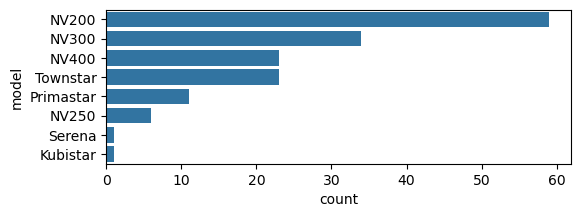

In [7681]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Nissan'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Nissan'], y='model', order=order)

In [7682]:
df.model.nunique() # checking again the number of total different models

200

#### Opel

In [7683]:
df[df['brand']=='Opel'].model.nunique() # checking the number of different models

28

In [7684]:
df[df['brand'] == 'Opel'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand model                                                    
Opel  1.2                                                     1
      Vivaro2,5CDTi+AHK+8Sitzer+Automatik+Klima+2.Han...      1
      Tüv,Insp+Bremsen                                        1
      Navi                                                    1
      MovanoB*Lang+Hoch*Klima*TÜV+Wartung                     1

In [7685]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Opel Life')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
4250,"Opel Life 1.5 CDTI E EDITION KEYLESS,KAMERA,1H...",17880,2021,2021-06-01,Diésel,97700,96,1499,4.1,5,1,both-sided
13237,"Opel Life 1.5 CDTI E EDITION,KEYLESS,KAMERA,1H...",17880,2021,2021-06-01,Diésel,95000,96,1499,4.1,5,1,right
20256,"Opel Life 1.5 D SELECTION 9 SITZE HEADUP,NAVI\...",28780,2020,2020-10-01,Diésel,17700,88,1499,4.8,9,1,right


In [7686]:
df[df.model==('Crosscamp')] # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in (the next line of code)

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7687]:
df[df.model==('Tüv,Insp+Bremsen')].query("brand == 'Opel'")

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
4209,Opel,"Tüv,Insp+Bremsen",5499,2003,2003-01-01,Gasolina,74000,64,1598,6.4,5,2,both-sided


In [7688]:
df[df.model.str.contains('MERIVA')].brand.unique()

array(['Opel'], dtype=object)

In [7689]:
# after some digging I can change the wrong values

df.model = np.where(df.model.str.contains('Zafira', case=False), 'Zafira', df.model)
df.model = np.where(df.model.str.contains('Vivaro', case=False), 'Vivaro', df.model)
df.model = np.where(df.model.str.contains('Movano', case=False), 'Movano', df.model)
df.model = np.where(df.model.str.contains('Combo', case=False), 'Combo', df.model)
df.model = np.where(df.model=='1.2', 'Combo', df.model)
df.model = np.where((df.model=='Kasten') & (df.brand=='Opel'), 'Vivaro', df.model)
df.model = np.where((df.model=='Kombi') & (df.brand=='Opel'), 'Vivaro', df.model)
df.model = np.where(df.model.str.contains('Meriva', case=False), np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='Navi', 'Vivaro', df.model)
df.model = np.where(df.model=='Tüv,Insp+Bremsen', 'Combo', df.model)
df.model = np.where((df.model=='Zafira') & (df.year==2004), np.nan, df.model) # the Zafira in 2004 was a car, newer versions are vans, but not this one
df.model = np.where((df.model=='1.5') & (df.price==19880), 'Vivaro', df.model)
df.model = np.where((df.model=='1.5') & (df.price==15880), 'Combo', df.model)
df.model = np.where((df.model=='Life') & (df.price<20000), 'Combo', df.model)
df.model = np.where((df.model=='Life') & (df.price>20000), 'Zafira', df.model)
df.model = np.where(df.model=='Sintra', np.nan, df.model) # it's a big car, not a van
df.model = np.where(df.model=='Crosscamp', 'Zafira', df.model)

df.dropna(subset='model', inplace=True) 

In [7690]:
df[df['brand']=='Opel'].model.nunique() # checking the number of different models

4

In [7691]:
df[df['brand'] == 'Opel'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand model        
Opel  Vivaro    389
      Combo     330
      Zafira    212
      Movano    118

<Axes: xlabel='count', ylabel='model'>

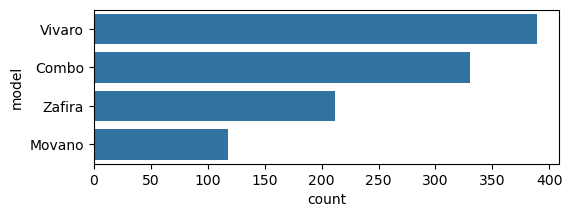

In [7692]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Opel'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Opel'], y='model', order=order)

In [7693]:
df.model.nunique() # checking again the number of total different models

177

#### Peugeot

In [7694]:
df[df['brand']=='Peugeot'].model.nunique() # checking the number of different models

19

In [7695]:
df[df['brand'] == 'Peugeot'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand   model                         
Peugeot 1007                         1
        TRAVELLER                    1
        Hochraum                     1
        ExpertPremium                1
        Expert,Kasten,Tüv/Au+kl      1

In [7696]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Peugeot 807')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
103,Peugeot 807 Tüv 11.2025 6 Sitze,1590,2006,2006-12-01,Diésel,340000,100,1997,7.1,6,3,both-sided
118,"Peugeot 807 2,0HDi 140 FAP AHV/Navi/PDC",3801,2012,2012-03-01,Diésel,332000,100,1997,7.1,5,1,both-sided
160,Peugeot 807 2.2 HDi Family Klimaautomatik PDC ...,499,2005,2005-07-01,Diésel,306292,94,2179,7.3,5,2,both-sided
215,Peugeot 807 Premium 2.0 HDi,1750,2007,2007-08-01,Diésel,290964,100,1997,7.1,7,3,both-sided
277,"Peugeot 807 Family HDi 110 Automatik , 1. Hand",2390,2004,2004-11-01,Diésel,278000,79,1997,8.0,7,1,both-sided
549,Peugeot 807 Premium,1990,2008,2008-03-01,Diésel,236000,100,1997,7.1,7,2,both-sided
714,Peugeot 807 Family HDi FAP 120,2100,2009,2009-04-01,Diésel,220600,100,1997,7.1,7,1,both-sided
921,Peugeot 807 Family/7 Sitzer/Tüv Bis 01.26/Klim...,3490,2009,2009-07-01,Gasolina,203064,103,1997,8.0,7,2,both-sided
963,Peugeot 807 Tendance/ Klima/ Xenon/ 7- Sitze/ ...,3990,2005,2005-06-01,Gasolina,200000,116,2230,9.7,7,1,both-sided
993,"Peugeot 807 Family 2,0 HDi Klima 1-Hand SHZ PD...",3600,2005,2005-12-01,Diésel,199990,94,2179,7.3,7,1,both-sided


In [7697]:
df[df.model==('2.0')] # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
292,Volkswagen,2.0,17999,2015,2015-06-01,Diésel,259300,103,1968,8.3,9,2,both-sided
1830,Toyota,2.0,7770,2005,2005-03-01,Diésel,147400,85,1995,7.2,7,1,both-sided
1926,Volkswagen,2.0,12850,2012,2012-08-01,Diésel,143000,81,1968,6.5,5,2,both-sided
2997,Seat,2.0,22900,2016,2016-11-01,Diésel,107000,135,1968,5.3,7,2,both-sided
3703,Seat,2.0,29680,2018,2018-09-01,Gasolina,86835,162,1984,7.3,7,1,both-sided
4043,Peugeot,2.0,17880,2018,2018-08-01,Diésel,77918,90,1997,5.3,3,1,both-sided
9481,Volkswagen,2.0,21995,2017,2017-07-01,Diésel,105000,75,1968,6.0,6,1,right
9959,Peugeot,2.0,33880,2020,2020-05-01,Diésel,94079,130,1997,6.4,7,1,right
10112,Volkswagen,2.0,36420,2020,2020-11-01,Diésel,90000,110,1968,6.3,9,1,right
10302,Volkswagen,2.0,33480,2019,2019-11-01,Diésel,86100,146,1968,6.8,6,1,right


In [7698]:
df[df.model.str.contains('Bipper', case=False)].brand.unique()

array(['Peugeot'], dtype=object)

In [7699]:
# after some digging I can change the wrong values

df.model = np.where(df.model.str.contains('Traveller', case=False) & (df.brand=='Peugeot'), 'Traveller', df.model)
df.model = np.where(df.model.str.contains('Rifter', case=False), 'Rifter', df.model)
df.model = np.where(df.model.str.contains('Boxer', case=False), 'Boxer', df.model)
df.model = np.where(df.model.str.contains('Expert', case=False), 'Expert', df.model)
df.model = np.where(df.model.str.contains('Partner', case=False), 'Partner', df.model)
df.model = np.where(df.model.str.contains('Bipper', case=False), 'Bipper', df.model)
df.model = np.where(df.model=='Hochraum', 'Boxer', df.model)
df.model = np.where((df.model=='2.0') & (df.price<20000), 'Expert', df.model)
df.model = np.where((df.model=='2.0') & (df.price>20000), 'Traveller', df.model)
df.model = np.where(df.model=='1007', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='5008', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='807', np.nan, df.model) # it's a car, not a van

df.dropna(subset='model', inplace=True) 

In [7700]:
df[df['brand']=='Peugeot'].model.nunique() # checking the number of different models

6

In [7701]:
df[df['brand'] == 'Peugeot'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand   model           
Peugeot Partner      142
        Boxer        107
        Expert        99
        Rifter        89
        Traveller     70
        Bipper         4

<Axes: xlabel='count', ylabel='model'>

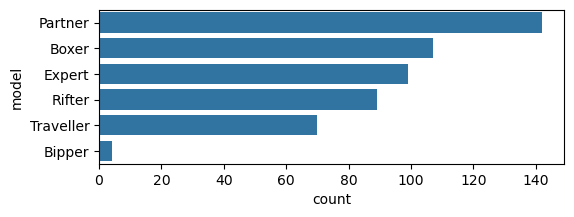

In [7702]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Peugeot'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Peugeot'], y='model', order=order)

In [7703]:
df.model.nunique() # checking again the number of total different models

164

#### Renault

In [7704]:
df[df['brand']=='Renault'].model.nunique() # checking the number of different models

26

In [7705]:
df[df['brand'] == 'Renault'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count') # checking the different models

count
brand   model                                                    
Renault L1H1                                                    1
        Trafic*L2H1*2,9t*Klima*PDC*KeylesGo*1Hand*Tüv26...      1
        Trafic*Combi*L2H1*2,9t                                  1
        Trafic*2.5d*107kW*9Sitze*Klima*NEUE                     1
        Scenic                                                  1
        MasterIII                                               1
        Master,Behindertengerechte,Standheizung                 1
        L2H1                                                    1
        Trafic/Neuer-Motor                                      1
        Kangoo1.2                                               1
        TÜV                                                     1
        Kangoo/Bluetooth/Klimaanlage/Vario\n12.950              1
        Kangoo*1Hand*Klima*PDC*Navi*TüvNeu*Scheckheft*\...      1
        KANGOO"LIMITED"-2.HAND|KLIMAAUT|TEMPOMAT                1
        Expert                                                  1
        115                                                     1
        Kangoo/Rollstuhlumbau/AC/48Tkm***HU                     1
        MASTER                                                  2
        1.6                                                     2
        Grand                                                   5
        Express                                                 5
        KANGOO                                                  7
        TRAFIC                                                  8
        Master                                                111
        Trafic                                                349
        Kangoo                                                360

In [7706]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Renault Grand')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
2080,Renault Grand Kangoo*7-SITZER*NAVI*AHK*PDC*KLI...,12480,2016,2016-08-01,Diésel,153265,81,1461,4.5,7,2,both-sided
3545,Renault Grand Kangoo #7-Sitzer #Tempomat #Blue...,15890,2016,2016-05-01,Diésel,113171,81,1461,4.5,7,1,both-sided
3594,"Renault Grand Kangoo 1.5 dCi Automatik, 7- Sit...",15990,2018,2018-05-01,Diésel,112000,81,1461,5.0,7,2,both-sided
12339,Renault Grand Kangoo 1.5 dCi Rapid Extra/EURO ...,4990,2012,2012-02-01,Diésel,110000,55,1461,5.2,2,2,right
20189,Renault Grand Trafic dCi 170 EDC 9-S L2H1 +SHZ...,37490,2023,2023-11-01,Diésel,18035,125,1997,7.4,9,1,right


In [7707]:
df[df.model==('Express')].query("brand=='Renault'") # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
8366,Renault,Express,10500,2022,2022-03-01,Diésel,138000,55,1461,4.2,2,1,right
13176,Renault,Express,16950,2022,2022-12-01,Diésel,33276,55,1461,5.0,2,1,right
13495,Renault,Express,13995,2021,2021-10-01,Gasolina,29925,75,1332,5.9,2,1,right
14372,Renault,Express,13900,2021,2021-06-01,Diésel,26000,55,1461,4.7,2,2,right
15157,Renault,Express,16450,2022,2022-12-01,Gasolina,16245,75,1332,6.5,2,2,right


In [7708]:
df[df.model.str.contains('Express', case=False)].brand.unique() # to check if there are other brands with the same model

array(['Renault'], dtype=object)

In [7709]:
# after some digging I can change the wrong values
df.model = np.where(df.model.str.contains('Kangoo', case=False), 'Kangoo', df.model)
df.model = np.where(df.model.str.contains('Trafic', case=False), 'Trafic', df.model)
df.model = np.where(df.model.str.contains('Master', case=False), 'Master', df.model)
df.model = np.where(df.model=='1.6', 'Trafic', df.model)
df.model = np.where(df.model=='115', 'Kangoo', df.model)
df.model = np.where((df.model=='Expert') & (df.brand=='Renault'), 'Trafic', df.model)
df.model = np.where(df.model=='L1H1', 'Trafic', df.model)
df.model = np.where(df.model=='L2H1', 'Trafic', df.model)
df.model = np.where(df.model=='Scenic', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='TÜV', np.nan, df.model) # I cannot find it, maybe it has been sold
df.model = np.where((df.model=='Transit') & (df.brand=='Renault') & (df.price<20000), 'Kangoo', df.model)
df.model = np.where((df.model=='Transit') & (df.brand=='Renault') & (df.price>20000), 'Trafic', df.model)
df.model = np.where((df.model=='Grand') & (df.brand=='Renault') & (df.price<20000), 'Kangoo', df.model)
df.model = np.where((df.model=='Grand') & (df.brand=='Renault') & (df.price>20000), 'Trafic', df.model)
df.dropna(subset='model', inplace=True) 

In [7710]:
df[df['brand']=='Renault'].model.nunique() # checking the number of different models

4

In [7711]:
df[df['brand'] == 'Renault'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand   model         
Renault Kangoo     377
        Trafic     367
        Master     115
        Express      5

<Axes: xlabel='count', ylabel='model'>

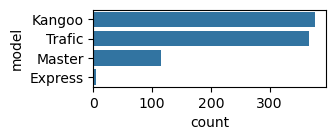

In [7712]:
plt.figure(figsize=(3,1))
order = df[df.brand=='Renault'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Renault'], y='model', order=order)

In [7713]:
df.model.nunique() # checking again the number of total different models

144

#### Seat

In [7714]:
df[df['brand']=='Seat'].model.nunique() # checking the number of different models

10

In [7715]:
df[df['brand'] == 'Seat'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand model                                               
Seat  1.4                                                1
      ALHAMBRA*                                          1
      ALHAMBRA*STYLE*ALLRAD*XENON*EINPARKHILFE           1
      Alhambra*2xSCHIEBETÜRE*LEDER*PANO*7-SITZER*        1
      Alhambra*FR-Line*2.Hand*7-Sitzer*Navi*Kamera*      1

In [7716]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Seat 1.4')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
5901,"Seat 1.4 TSI FR LINE 7 SITZE KESSY,AHK,1.HD\n2...",28740,2019,2019-06-01,Gasolina,66660,110,1395,7.1,7,1,both-sided


In [7717]:
df[df.model==('1.4')].query("brand=='Seat'") # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
4504,Seat,1.4,28740,2019,2019-06-01,Gasolina,66660,110,1395,7.1,7,1,both-sided


In [7718]:
# after some digging I find that all of these models are big cars rather than vans
df.brand = np.where(df.brand.str.contains('Seat'), np.nan, df.brand)
df.dropna(subset='brand', inplace=True)

In [7719]:
df.model.nunique() # checking again the number of total different models

136

#### Skoda

In [7720]:
df[df['brand']=='Skoda'].groupby(["brand", "model"]).agg({'model': 'count'}) # checking the different models

model
brand model          
Skoda Praktik       1
      Roomster      5

In [7721]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Skoda')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
757,Skoda Praktik,850,2009,2009-05-01,Gasolina,218000,51,1198,6.7,2,2,both-sided
968,Skoda Roomster *AUTOMATIK*KLIMA*SZH*PDC*TÜV 07...,2990,2007,2007-03-01,Gasolina,200000,77,1598,7.7,5,4,both-sided
1280,Skoda Roomster 1.2 Style Plus Edition*KLIMA*2X...,1990,2009,2009-12-01,Gasolina,185000,51,1198,6.7,5,2,both-sided
1469,Skoda Roomster Praktik*KLIMA*SERVICE NEU*Z-RIE...,5480,2008,2008-10-01,Diésel,176000,59,1422,5.2,2,2,both-sided
2508,Skoda Roomster 1.2 Plus Edition*NAVI*PANORAMA*...,5890,2009,2009-06-01,Gasolina,140000,51,1198,6.7,5,2,both-sided
11020,Skoda Roomster Praktik/ 66kw/ Klima/ LKW Zulas...,5653,2014,2014-04-01,Diésel,137789,66,1598,4.7,2,1,right


In [7722]:
# after some digging I find that all of these models are big cars rather than vans
df.brand = np.where(df.brand.str.contains('Skoda'), np.nan, df.brand)
df.dropna(subset='brand', inplace=True)

In [7723]:
df.model.nunique() # checking again the number of total different models

134

#### Toyota

In [7724]:
df[df['brand']=='Toyota'].model.nunique() # checking the number of different models

10

In [7725]:
df[df['brand'] == 'Toyota'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand  model               
Toyota CROSSCAMP          1
       Executive          1
       Expert             1
       PREVIA             1
       Proace(Verso)      1

In [7726]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Toyota Hiace')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
3669,Toyota Hiace HI-ACE Kasten 2.5 TD*2xSchiebetür...,10900,2011,2011-11-01,Diésel,110000,70,2494,8.5,3,1,both-sided
8507,Toyota Hiace 2.5 D-4D *KÜHLWAGEN*EURO.4*3.SITZ...,4350,2010,2010-05-01,Diésel,220000,70,2494,8.5,3,2,right
9071,Toyota Hiace HI-ACE Kombi TD,5950,2004,2004-10-01,Diésel,194500,75,2494,8.7,8,2,right
9339,Toyota Hiace HI-ACE Kasten TD,6600,2007,2007-12-01,Diésel,185000,70,2494,8.5,3,1,right


In [7727]:
df[df.model==('Hiace')] # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
2884,Toyota,Hiace,10900,2011,2011-11-01,Diésel,110000,70,2494,8.5,3,1,both-sided
6488,Toyota,Hiace,4350,2010,2010-05-01,Diésel,220000,70,2494,8.5,3,2,right
6920,Toyota,Hiace,5950,2004,2004-10-01,Diésel,194500,75,2494,8.7,8,2,right
7134,Toyota,Hiace,6600,2007,2007-12-01,Diésel,185000,70,2494,8.5,3,1,right


In [7728]:
df[df.model.str.contains('Previa', case=False)] # to check if there are other brands with the same model

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
78,Toyota,Previa,3400,2003,2003-12-01,Gasolina,350000,115,2362,10.8,6,1,both-sided
245,Toyota,Previa,1350,2001,2001-04-01,Diésel,273664,85,1995,7.2,7,2,both-sided
521,Toyota,Previa,4800,2005,2005-05-01,Gasolina,226284,115,2362,10.8,7,1,both-sided
680,Toyota,Previa,6999,2004,2004-12-01,Gasolina,209500,115,2362,10.8,7,2,both-sided
806,Toyota,Previa,6888,2005,2005-12-01,Gasolina,199652,115,2362,10.8,7,1,both-sided
1131,Toyota,Previa,8999,2005,2005-07-01,Gasolina,179000,115,2362,9.4,7,2,both-sided
8078,Toyota,PREVIA,7770,2005,2005-03-01,Diésel,147400,85,1995,7.2,7,1,both-sided


In [7729]:
# after some digging I can change the wrong values
df.model = np.where(df.model.str.contains('Proace', case=False), 'Proace', df.model)
df.model = np.where(df.model.str.contains('CROSSCAMP', case=False), 'Proace', df.model)
df.model = np.where(df.model=='Verso', 'Proace', df.model)
df.model = np.where(df.model=='Executive', 'Proace', df.model)
df.model = np.where((df.model=='Expert') & (df.brand=='Toyota'), np.nan, df.model) # it's a big car rather than a van
df.model = np.where(df.model.str.contains('Previa', case=False), np.nan, df.model) # it's a big car rather than a van
df.dropna(subset='model', inplace=True) 

In [7730]:
df[df['brand']=='Toyota'].model.nunique() # checking the number of different models

2

In [7731]:
df[df['brand'] == 'Toyota'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False) # checking again the different models after the clean-up

count
brand  model        
Toyota Proace    188
       Hiace       4

In [7732]:
df.model.nunique() # checking again the number of total different models

127

#### Volkswagen

In [7733]:
df[df['brand']=='Volkswagen'].model.nunique() # checking the number of different models of Nissan

77

In [7734]:
df[df['brand'] == 'Volkswagen'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count').head() # checking the different models

count
brand      model                                                
Volkswagen 1,4                                                 1
           Cup                                                 1
           Golf                                                1
           Kasten-Kombi                                        1
           VW-Caddy*Maxi*Highline*AUTOMATIK*7-SITZER*AHK*      1

In [7735]:
# thanks to the df with the original title (before splitting it in brand and model) I can see more information
dftitle[dftitle.title.str.contains('Volkswagen Tourneo')]

,title,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7736]:
df[df.model==('Tourneo')].query("brand=='Volkswagen'") # to check if the model is exclusive of this brand or I have to add a condition with the brand I'm interested in

,brand,model,price,year,date,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7737]:
# df[df.model.str.contains('Traveller', case=False)] # to check if there are other brands with the same model

In [7738]:
# after some digging I can change the wrong values

df.model = np.where(df.model.str.contains('sharan', case=False), np.nan, df.model) # it's a big car rather than a van
df.model = np.where(df.model.str.contains('maxi', case=False), 'Caddy', df.model)
df.model = np.where(df.model.str.contains('Caddy', case=False), 'Caddy', df.model)
df.model = np.where(df.model.str.contains('Multivan', case=False), 'Multivan', df.model)
df.model = np.where(df.model=='1,4', 'Caddy', df.model)
df.model = np.where(df.model=='STANDHZ', np.nan, df.model) # I cannot find it, maybe it has been sold
df.model = np.where(df.model=='New', 'Multivan', df.model)
df.model = np.where(df.model=='Multi', 'Multivan', df.model)
df.model = np.where(df.model=='NEUER', 'T5', df.model)
df.model = np.where(df.model=='Other', 'T6', df.model)
df.model = np.where(df.model=='T6.1', 'T6', df.model)
df.model = np.where(df.model=='6.1', 'T6', df.model)
df.model = np.where(df.model.str.contains('T6', case=False), 'T6', df.model)
df.model = np.where(df.model.str.contains('T5', case=False), 'T5', df.model)
df.model = np.where(df.model=='Golf', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='18x', 'Caddy', df.model)
df.model = np.where(df.model=='T30', 'T6', df.model)
df.model = np.where(df.model=='Rhön', 'T6', df.model)
df.model = np.where(df.model=='Beach/LED/AHK/NAVI', 'T6', df.model)
df.model = np.where(df.model=='Bus', 'Multivan', df.model)
df.model = np.where(df.model=='Kasten-Kombi', 'T6', df.model)
df.model = np.where(df.model=='Cup', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model.str.contains('Crafter', case=False), 'Crafter', df.model)
df.model = np.where(df.model=='Comfortline', 'Caddy', df.model)
df.model = np.where(df.model=='1.4', 'Caddy', df.model)
df.model = np.where(df.model=='35', 'Crafter', df.model)
df.model = np.where(df.model=='7', np.nan, df.model) # it's a car, not a van
df.model = np.where(df.model=='REGALE', 'T6', df.model)
df.model = np.where(df.model=='Transporter6.1', 'T6', df.model)
df.model = np.where(df.model=='Expert', np.nan, df.model) # I cannot find them
df.model = np.where(df.model=='Transporter6.1', 'T6', df.model)
df.model = np.where((df.model=='Kasten') & (df.price==7250), 'Caddy', df.model)
df.model = np.where((df.model=='Kasten') & (df.price==27990), 'Crafter', df.model)
df.model = np.where((df.model=='Kasten') & (df.price==30800), 'T6', df.model)
df.model = np.where((df.model=='T') & (df.brand=='Volkswagen') & (df.price==29950), 'T6', df.model)
df.model = np.where((df.model=='T') & (df.brand=='Volkswagen') & (df.price==107904), 'T6', df.model)
df.model = np.where((df.model=='T') & (df.brand=='Volkswagen') & (df.price==57900), 'T7', df.model)
df.model = np.where((df.model=='Caravelle') & (df.price==14990), 'T5', df.model)
df.model = np.where((df.model=='Caravelle') & (df.price==19990), 'T6', df.model)
df.model = np.where((df.model=='Caravelle') & (df.price==34789), 'T6', df.model)
df.model = np.where((df.model=='Caravelle') & (df.price==46970), 'T6', df.model)
df.model = np.where((df.model=='VW') & (df.price<25000), 'Caddy', df.model)
df.model = np.where((df.model=='VW') & (df.price<35000) & (df.price>25000), 'Crafter', df.model)
df.model = np.where((df.model=='VW') & (df.price>40000), 'Multivan', df.model)
df.model = np.where((df.model=='Transporter') & (df.price==13850), 'T5', df.model)
df.model = np.where((df.model=='Transporter') & (df.price==46940), 'T6', df.model)
df.model = np.where((df.model=='Transporter') & (df.price==58990), 'Multivan', df.model)
df.model = np.where((df.model=='Transporter') & (df.price==45990), 'T6', df.model)
df.model = np.where((df.model=='Transporter') & (df.price==59890), 'Multivan', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==21995), 'T6', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==36420), np.nan, df.model) # I cannot find it, maybe it has been sold
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==33480), 'T6', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==32780), np.nan, df.model) # it's a car, not a van
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==24740), 'T6', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==24740), 'T6', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==27380), 'T6', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==23870), 'T6', df.model)
df.model = np.where((df.model=='Traveller') & (df.brand=='Volkswagen') & (df.price==36770), 'T6', df.model)
df.model = np.where((df.model=='Transit') & (df.brand=='Volkswagen') & (df.price<35000), np.nan, df.model) # it's a car, not a van
df.model = np.where((df.model=='Transit') & (df.brand=='Volkswagen') & (df.price>35000), 'Grand California', df.model)
df.model = np.where((df.model=='California') & (df.power_cv==130), 'Grand California', df.model)
df.model = np.where((df.model=='California') & (df.power_cv!=130), 'T6', df.model)
df.model = np.where((df.model=='Grand') & (df.brand=='Volkswagen'), 'Grand California', df.model)
df.model = np.where((df.model=='Touran') & (df.brand=='Volkswagen'), np.nan, df.model) # it's a car, not a van

df.dropna(subset='model', inplace=True) 

In [7739]:
df[df['brand']=='Volkswagen'].model.nunique() # checking the number of different models

9

In [7740]:
df[df['brand'] == 'Volkswagen'].groupby(["brand", "model"]).agg(count=('model', 'count')).sort_values('count', ascending=False).head(20) # checking again the different models after the clean-up

count
brand      model                  
Volkswagen T6                 2287
           Caddy              2269
           T5                  652
           Crafter             317
           T7                  202
           Multivan            110
           T4                   51
           Grand California     10
           LT                    2

<Axes: xlabel='count', ylabel='model'>

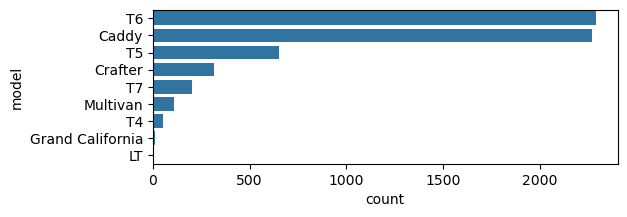

In [7741]:
plt.figure(figsize=(6,2))
order = df[df.brand=='Volkswagen'].model.value_counts().keys()
sns.countplot(data=df[df.brand=='Volkswagen'], y='model', order=order)

In [7742]:
df.model.nunique() # checking again the number of total different models

61

### **2.1.3 - Recap**

In [7743]:
print(f'Number of brands: {df.brand.nunique()}')
print(f'Number of models: {df.model.nunique()}')

Number of brands: 16
Number of models: 61


In [7744]:
df.shape # before the clean-up we had 18.636 vans

(17729, 13)

In [7745]:
df.groupby(["brand"]).agg({'model': 'count'}).sort_values('model', ascending=False) # number of different vans on sale per brand and model

,model
brand,
Volkswagen,5900
Mercedes-Benz,5599
Ford,2280
Opel,1049
Renault,864
Citroën,662
Peugeot,412
Fiat,380
Toyota,192


In [7746]:
# for the sake of simplicity, I'm going to drop the 4 brands with less than 4 vans, they are not representative
df.brand = np.where((df.brand=='Iveco') | (df.brand=='MAN') | (df.brand=='Mitsubishi') | (df.brand=='Chevrolet'), np.nan, df.brand)
df.dropna(inplace=True)

In [7747]:
print(f'Number of brands: {df.brand.nunique()}')
print(f'Number of models: {df.model.nunique()}')

Number of brands: 12
Number of models: 57


In [7748]:
df.groupby(["brand"]).agg({'model': 'nunique'}).sort_values('model', ascending=False) # number of different models per brand

,model
brand,
Volkswagen,9
Nissan,8
Mercedes-Benz,7
Fiat,6
Citroën,5
Peugeot,5
Opel,4
Renault,4
Ford,3


<Axes: xlabel='model', ylabel='brand'>

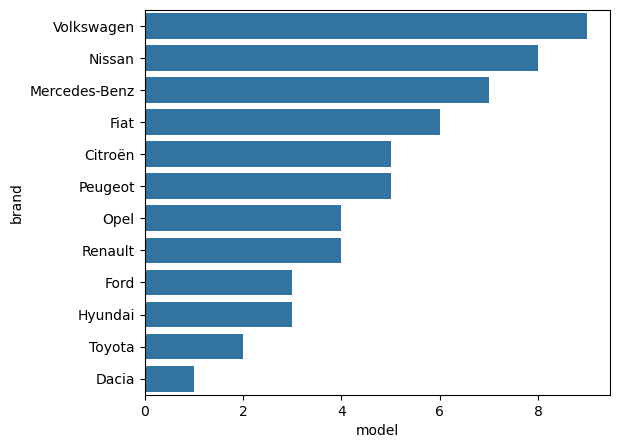

In [7749]:
# let's visualize the number of different models per brand
plt.figure(figsize=(6,5))
# order = df.brand.value_counts().keys()
sns.barplot(data=df.groupby(["brand"]).agg({'model': 'nunique'}).sort_values('model', ascending=False), y='brand', x='model')

<Axes: xlabel='count', ylabel='brand'>

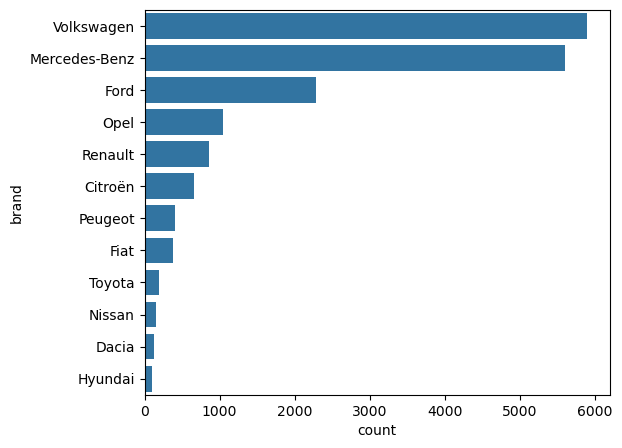

In [7750]:
# number of vans per brand
plt.figure(figsize=(6,5))
order = df.brand.value_counts().keys()
sns.countplot(data=df, y='brand', order=order)

In [7751]:
df.groupby(["brand", "model"]).agg({'model': 'count'}) # number of different vans on sale per brand and model

model
brand         model                  
Citroën       Berlingo            413
              Jumper               83
              Jumpy                92
              Nemo                  8
              SpaceTourer          66
Dacia         Dokker              128
Fiat          Doblo               135
              Ducato               92
              Fiorino              20
              Qubo                 19
              Scudo                40
              Talento              74
Ford          Connect             529
              Custom             1531
              Transit             220
Hyundai       H-1                  46
              H350                  4
              Staria               47
Mercedes-Benz Citan               314
              Marco Polo           71
              Sprinter            980
              T                   174
              V                  2454
              Viano               129
              Vito               1477
Nissan        Kubistar              1
              NV200                59
              NV250                 6
              NV300                34
              NV400                23
              Primastar            11
              Serena                1
              Townstar             23
Opel          Combo               330
              Movano              118
              Vivaro              389
              Zafira              212
Peugeot       Bipper                4
              Boxer               107
              Partner             142
              Rifter               89
              Traveller            70
Renault       Express               5
              Kangoo              377
              Master              115
              Trafic              367
Toyota        Hiace                 4
              Proace              188
Volkswagen    Caddy              2269
              Crafter             317
              Grand California     10
              LT                    2
              Multivan            110
              T4                   51
              T5                  652
              T6                 2287
              T7                  202

<Axes: xlabel='count', ylabel='model'>

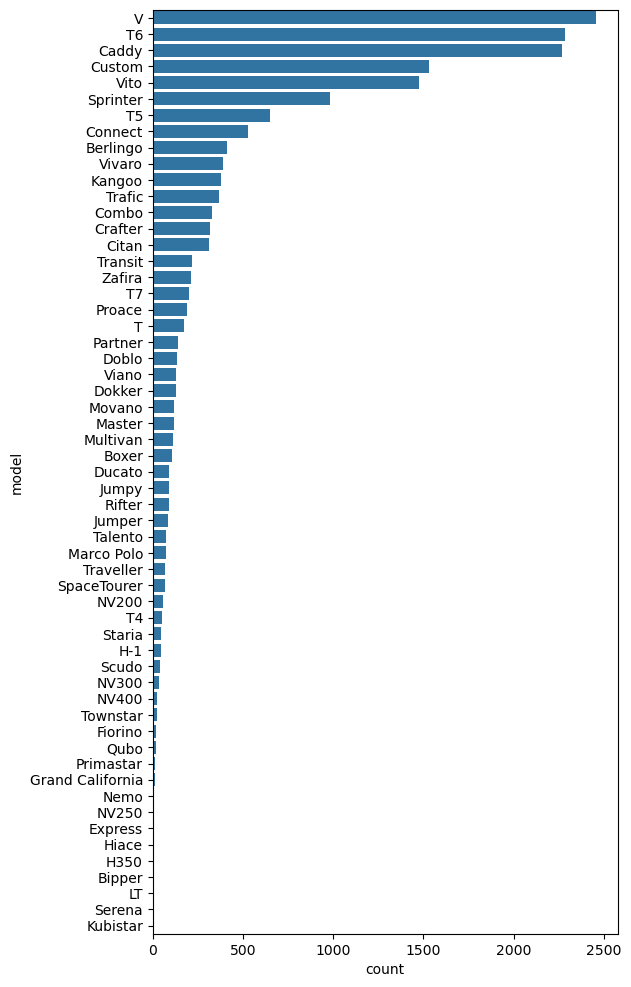

In [7752]:
plt.figure(figsize=(6,12)) # number of vans per model
order = df.model.value_counts().keys()
sns.countplot(data=df, y='model', order=order)

In [7753]:
df.shape

(17721, 13)

## 2.2 - getting ``age`` from ``year``

I am actually interested in how old the van is, not really the year, so let's create this variable

In [7754]:
df['age'] = 2025 - df['year']

In [7755]:
 # I don't need these columns anymore
df.drop(columns='date', inplace=True)
df.drop(columns='year', inplace=True)
# sorting the columns 
columns_sorted = ['brand', 'model', 'price', 'age', 'fuel', 'km', 'power_cv', 'displacement_cm3', 'consumption', 'seats', 'owners', 'sliding_doors']
df = df.reindex(columns=columns_sorted)
df.sample(5)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
16851,Ford,Connect,21950,7,Diésel,69800,88,1499,4.7,7,2,both-sided
16608,Ford,Custom,31480,7,Diésel,108392,125,1995,8.6,8,2,both-sided
11174,Renault,Trafic,17840,6,Diésel,64120,88,1598,6.5,3,1,right
11824,Volkswagen,Caddy,25900,12,Gasolina,44000,77,1197,6.8,7,1,both-sided
7450,Opel,Vivaro,17380,5,Diésel,170500,130,1997,5.6,3,1,right


In [7756]:
df.sort_values('age', ascending=False).head(10)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
7603,Fiat,Ducato,9999,34,Gasolina,165000,62,1971,8.6,4,4,right
6147,Volkswagen,T4,3999,33,Gasolina,252000,62,1968,9.1,9,3,right
5609,Volkswagen,T4,8990,29,Diésel,382500,50,1896,8.5,9,2,right
5785,Volkswagen,T4,12999,28,Diésel,314000,75,2461,8.6,6,1,right
6082,Volkswagen,T4,10500,28,Diésel,259500,75,2461,7.9,7,2,right
5776,Volkswagen,T4,3999,28,Diésel,317000,75,2461,7.9,3,3,right
5672,Volkswagen,T4,5990,28,Diésel,347000,75,2461,7.9,7,2,right
5855,Volkswagen,T4,4999,28,Gasolina,298000,85,2461,12.4,7,2,right
5577,Volkswagen,T4,6950,27,Diésel,411488,75,2461,7.9,7,4,right
6450,Volkswagen,T4,6950,27,Gasolina,223300,85,2461,13.9,5,4,right


<Axes: xlabel='age'>

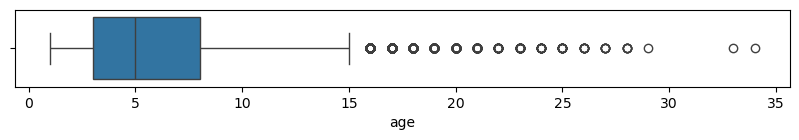

In [7757]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='age')

## 2.3 - ``consumption``

### 2.3.1 '--' values

In [7758]:
df.consumption.unique()

array(['8.6', '6.1', '6.0', '6.5', '5.2', '6.7', '7.1', '5.5', '6.8',
       '8.0', '5.8', '4.6', '5.7', '8.3', '6.6', '5.0', '9.1', '4.4',
       '5.6', '5.4', '5.9', '8.8', '7.5', '9.3', '5.1', '5.3', '9.9',
       '6.4', '4.5', '9.8', '7.0', '6.3', '8.5', '7.9', '8.4', '7.7',
       '7.8', '7.4', '8.1', '7.2', '8.9', '9.2', '6.2', '9.4', '8.7',
       '4.9', '8.2', '9.7', '4.3', '4.7', '7.6', '9.0', '7.3', '12.7',
       '4.8', '6.9', '10.2', '10.5', '9.6', '4.2', '4.1', '13.0', '12.1',
       '4.0', '9.5', '--', '10.7', '53.0', '3.9', '10.1', '10.4', '11.0',
       '10.8', '11.8', '10.9', '10.3', '10.6', '12.4', '11.7', '11.3',
       '13.9', '11.9', '11.1', '11.4', '86.0', '131.0', '3.8', '10.0',
       '78.0', '203.0', '11.2', '12.3', '47.0', '12.5', '75.0', '590.0',
       '217.0', '218.0', '11.5', '550.0', '70.6', '12.0', '3.6', '142.0',
       '84.0', '62.0'], dtype=object)

There is a '--' value, I have to change these rows in order to convert the series into floats

In [7759]:
df[df['consumption'] == '--'].shape[0]

38

In [7760]:
df.consumption.isna().sum()

0

In [7761]:
df.consumption = np.where(df['consumption']=='--', np.nan, df.consumption)
df.consumption.isna().sum()

38

In [7762]:
df.dropna(subset='consumption', inplace=True)
df.shape

(17683, 12)

In [7763]:
df.consumption = df['consumption'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17683 entries, 0 to 18635
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             17683 non-null  object 
 1   model             17683 non-null  object 
 2   price             17683 non-null  int64  
 3   age               17683 non-null  int32  
 4   fuel              17683 non-null  object 
 5   km                17683 non-null  int64  
 6   power_cv          17683 non-null  int32  
 7   displacement_cm3  17683 non-null  int64  
 8   consumption       17683 non-null  float64
 9   seats             17683 non-null  object 
 10  owners            17683 non-null  object 
 11  sliding_doors     17683 non-null  object 
dtypes: float64(1), int32(2), int64(3), object(6)
memory usage: 1.6+ MB


I can either convert them to null values or look for the correct consumption.

I'm just gonna drop these values, since they are so few but enough that I don't think it's worth the time changing the values.

### 2.3.2 - ``consumption`` outliers

<Axes: xlabel='consumption'>

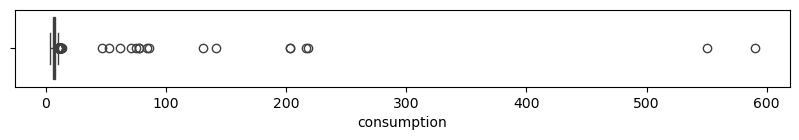

In [7764]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='consumption')

In [7765]:
df.consumption.mean()

6.9298196007464785

There are some outliers with extreme values of ``consumption``, they must be wrong, let's take a look

In [7766]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
13215,Opel,Combo,17255,4,Diésel,32804,56,1499,590.0,2,1,both-sided
15638,Opel,Combo,23990,4,Gasolina,12655,81,1199,550.0,5,2,both-sided
14188,Mercedes-Benz,V,74890,1,Diésel,21739,174,1950,218.0,7,1,both-sided
13690,Mercedes-Benz,V,64890,2,Diésel,28040,140,1950,217.0,7,1,both-sided
9688,Mercedes-Benz,Sprinter,33914,5,Diésel,99868,120,2143,203.0,6,1,right


In [7767]:
df[df['brand']=='Opel'].query("model == 'Combo' & power_cv == 56").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
13215,Opel,Combo,17255,4,Diésel,32804,56,1499,590.0,2,1,both-sided
3035,Opel,Combo,12999,6,Diésel,105650,56,1499,5.6,5,1,both-sided
3036,Opel,Combo,13399,6,Diésel,105649,56,1499,5.6,5,1,both-sided
11338,Opel,Combo,12845,5,Diésel,52823,56,1499,5.6,2,1,right
3440,Opel,Combo,13400,6,Diésel,93980,56,1499,5.5,5,1,both-sided
11406,Opel,Combo,13870,5,Diésel,51082,56,1499,4.7,2,2,right
8490,Opel,Combo,10900,5,Diésel,134200,56,1499,4.2,2,2,right
9431,Opel,Combo,9499,6,Diésel,106000,56,1499,4.2,2,1,right
9883,Opel,Combo,9989,6,Diésel,96000,56,1499,4.2,2,1,right
11047,Opel,Combo,12890,5,Diésel,68000,56,1499,4.2,2,1,right


In [7768]:
# it's a bit strange that there are two distinctive values, let's just replace it for one of these 2 values
df.consumption = np.where(df.consumption == 590, 4.2, df.consumption) # changing the wrong value

In [7769]:
df[df['brand']=='Opel'].query("model == 'Combo' & power_cv == 81").sort_values('consumption', ascending=False).consumption.value_counts()

consumption
7.0      17
5.3      13
5.5      10
7.5       6
6.3       3
7.1       2
550.0     1
6.9       1
6.8       1
5.0       1
Name: count, dtype: int64

In [7770]:
df.consumption = np.where(df.consumption == 550, 5.5, df.consumption) # I'm guessing it's a typo, they wrote 550 instead of 5.5

In [7771]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
14188,Mercedes-Benz,V,74890,1,Diésel,21739,174,1950,218.0,7,1,both-sided
13690,Mercedes-Benz,V,64890,2,Diésel,28040,140,1950,217.0,7,1,both-sided
14903,Mercedes-Benz,V,62790,1,Diésel,18238,140,1950,203.0,7,1,both-sided
9688,Mercedes-Benz,Sprinter,33914,5,Diésel,99868,120,2143,203.0,6,1,right
16719,Ford,Connect,13980,5,Diésel,90009,74,1499,142.0,5,1,both-sided


In [7772]:
df[df['brand']=='Iveco'].query("model == 'Daily'").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7773]:
df.consumption = np.where(df.consumption == 289, 7.7, df.consumption) # changing the wrong value

In [7774]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
14188,Mercedes-Benz,V,74890,1,Diésel,21739,174,1950,218.0,7,1,both-sided
13690,Mercedes-Benz,V,64890,2,Diésel,28040,140,1950,217.0,7,1,both-sided
14903,Mercedes-Benz,V,62790,1,Diésel,18238,140,1950,203.0,7,1,both-sided
9688,Mercedes-Benz,Sprinter,33914,5,Diésel,99868,120,2143,203.0,6,1,right
16719,Ford,Connect,13980,5,Diésel,90009,74,1499,142.0,5,1,both-sided


In [7775]:
df[df['brand']=='Mercedes-Benz'].query("model == 'V' & age == 2 & power_cv == 140").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
13690,Mercedes-Benz,V,64890,2,Diésel,28040,140,1950,217.0,7,1,both-sided
14605,Mercedes-Benz,V,75900,2,Diésel,20200,140,1950,8.6,4,1,right
13638,Mercedes-Benz,V,74900,2,Diésel,28700,140,1950,8.6,4,1,right
14404,Mercedes-Benz,V,75400,2,Diésel,25050,140,1950,8.6,4,1,right
14281,Mercedes-Benz,V,67885,2,Diésel,20443,140,1950,8.5,7,1,both-sided
...,...,...,...,...,...,...,...,...,...,...,...,...
14172,Mercedes-Benz,V,63890,2,Diésel,22000,140,1950,7.3,7,1,both-sided
13266,Mercedes-Benz,V,62890,2,Diésel,32300,140,1950,7.3,7,1,both-sided
15013,Mercedes-Benz,V,64490,2,Diésel,17414,140,1950,7.3,7,1,both-sided
13297,Mercedes-Benz,V,63800,2,Diésel,32000,140,1950,6.4,6,1,both-sided


In [7776]:
df[df['brand']=='Mercedes-Benz'].query("model == 'V' & age == 2 & power_cv == 140 & consumption < 9").consumption.mean()

7.8578947368421055

In [7777]:
df[df['brand']=='Mercedes-Benz'].query("model == 'V' & age == 2 & power_cv == 140 & consumption < 9").consumption.value_counts()

consumption
7.7    66
7.8    63
8.2    19
8.3    17
7.6    16
8.5     9
8.1     8
7.5     7
7.9     6
7.3     5
8.0     4
8.4     3
8.6     3
6.4     2
Name: count, dtype: int64

In [7778]:
df.consumption = np.where(df.consumption == 217, 7.8, df.consumption) # changing the wrong value
df.consumption = np.where(df.consumption == 218, 7.8, df.consumption) # changing the wrong value

In [7779]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
14903,Mercedes-Benz,V,62790,1,Diésel,18238,140,1950,203.0,7,1,both-sided
9688,Mercedes-Benz,Sprinter,33914,5,Diésel,99868,120,2143,203.0,6,1,right
16719,Ford,Connect,13980,5,Diésel,90009,74,1499,142.0,5,1,both-sided
7861,Renault,Kangoo,10750,5,Diésel,155000,85,1461,131.0,2,1,right
7734,Volkswagen,T6,33999,6,Diésel,160000,146,1968,86.0,6,1,right


In [7780]:
df[df['brand']=='Mercedes-Benz'].query("model == 'Sprinter' & age == 5 & power_cv == 120").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
9688,Mercedes-Benz,Sprinter,33914,5,Diésel,99868,120,2143,203.0,6,1,right
10158,Mercedes-Benz,Sprinter,30928,5,Diésel,89351,120,2143,9.9,3,1,right
9536,Mercedes-Benz,Sprinter,28548,5,Diésel,103196,120,2143,9.9,3,1,right
9577,Mercedes-Benz,Sprinter,29738,5,Diésel,101726,120,2143,9.9,3,1,right
10288,Mercedes-Benz,Sprinter,30928,5,Diésel,86315,120,2143,9.9,3,1,right
9914,Mercedes-Benz,Sprinter,27227,5,Diésel,95141,120,2143,9.5,3,1,right
12562,Mercedes-Benz,Sprinter,35569,5,Diésel,40442,120,2143,9.1,3,1,right
9028,Mercedes-Benz,Sprinter,30809,5,Diésel,117722,120,2143,9.0,3,1,right
9253,Mercedes-Benz,Sprinter,32582,5,Diésel,111010,120,2143,9.0,3,1,right
12462,Mercedes-Benz,Sprinter,32701,5,Diésel,41298,120,2143,9.0,3,1,right


In [7781]:
df[df['brand']=='Mercedes-Benz'].query("model == 'Sprinter' & age == 5 & power_cv == 120").consumption.mean()

13.31081081081081

In [7782]:
df[df['brand']=='Mercedes-Benz'].query("model == 'Sprinter' & age == 5 & power_cv == 120").consumption.value_counts()

consumption
7.7      17
7.5       6
9.9       4
9.0       3
7.1       2
7.4       1
6.8       1
203.0     1
9.5       1
9.1       1
Name: count, dtype: int64

In [7783]:
df.consumption = np.where(df.consumption == 203, 7.7, df.consumption) # changing the wrong value

In [7784]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
16719,Ford,Connect,13980,5,Diésel,90009,74,1499,142.0,5,1,both-sided
7861,Renault,Kangoo,10750,5,Diésel,155000,85,1461,131.0,2,1,right
7734,Volkswagen,T6,33999,6,Diésel,160000,146,1968,86.0,6,1,right
17506,Ford,Custom,6999,23,Diésel,130081,66,2402,84.0,6,2,right
10065,Mercedes-Benz,Sprinter,18950,5,Diésel,91600,105,2143,78.0,2,1,right


In [7785]:
df[df['brand']=='Ford'].query("model == 'Tourneo' & age == 5 & power_cv == 74").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7786]:
df[df['brand']=='Ford'].query("model == 'Tourneo' & age == 5 & power_cv == 74").consumption.value_counts()

Series([], Name: count, dtype: int64)

In [7787]:
df.consumption = np.where(df.consumption == 142, 4.3, df.consumption) # changing the wrong value

In [7788]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
7861,Renault,Kangoo,10750,5,Diésel,155000,85,1461,131.0,2,1,right
7734,Volkswagen,T6,33999,6,Diésel,160000,146,1968,86.0,6,1,right
17506,Ford,Custom,6999,23,Diésel,130081,66,2402,84.0,6,2,right
10065,Mercedes-Benz,Sprinter,18950,5,Diésel,91600,105,2143,78.0,2,1,right
9455,Mercedes-Benz,Sprinter,19950,5,Diésel,105500,105,2143,78.0,2,1,right


In [7789]:
df[df['brand']=='Renault'].query("model == 'Kangoo' & age == 5 & power_cv == 85").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
7861,Renault,Kangoo,10750,5,Diésel,155000,85,1461,131.0,2,1,right
10025,Renault,Kangoo,12590,5,Diésel,92500,85,1461,5.0,2,1,right
10059,Renault,Kangoo,11490,5,Diésel,91800,85,1461,5.0,2,1,right
10443,Renault,Kangoo,10999,5,Diésel,83000,85,1461,5.0,2,1,right
2318,Renault,Kangoo,10789,5,Diésel,129000,85,1461,4.8,5,1,both-sided
3808,Renault,Kangoo,14799,5,Diésel,84300,85,1461,4.8,5,2,both-sided
9611,Renault,Kangoo,11749,5,Diésel,100000,85,1461,4.6,2,1,right


In [7790]:
df.consumption = np.where(df.consumption == 131, 4.8, df.consumption) # changing the wrong value

In [7791]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
7734,Volkswagen,T6,33999,6,Diésel,160000,146,1968,86.0,6,1,right
17506,Ford,Custom,6999,23,Diésel,130081,66,2402,84.0,6,2,right
10065,Mercedes-Benz,Sprinter,18950,5,Diésel,91600,105,2143,78.0,2,1,right
9455,Mercedes-Benz,Sprinter,19950,5,Diésel,105500,105,2143,78.0,2,1,right
12557,Renault,Trafic,39990,4,Diésel,40490,125,1997,75.0,7,2,right


In [7792]:
df[df['brand']=='Volkswagen'].query("model == 'T6' & age == 6 & power_cv == 146").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
7734,Volkswagen,T6,33999,6,Diésel,160000,146,1968,86.0,6,1,right
9747,Volkswagen,T6,48900,6,Diésel,98820,146,1968,9.9,7,2,right
2572,Volkswagen,T6,42911,6,Diésel,120345,146,1968,9.9,7,3,both-sided
9949,Volkswagen,T6,57900,6,Diésel,94410,146,1968,9.8,4,2,right
10303,Volkswagen,T6,56990,6,Diésel,86088,146,1968,9.7,7,1,right
...,...,...,...,...,...,...,...,...,...,...,...,...
10117,Volkswagen,T6,42900,6,Diésel,90000,146,1968,6.9,7,2,right
10302,Volkswagen,T6,33480,6,Diésel,86100,146,1968,6.8,6,1,right
6219,Volkswagen,T6,19500,6,Diésel,245000,146,1968,6.7,8,1,right
3513,Volkswagen,T6,49999,6,Diésel,92000,146,1968,6.3,6,2,both-sided


In [7793]:
df.consumption = np.where(df.consumption == 86, 8.6, df.consumption) # I'm guessing it's a typo, they wrote 86.0 instead of 8.60

In [7794]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
17506,Ford,Custom,6999,23,Diésel,130081,66,2402,84.0,6,2,right
10065,Mercedes-Benz,Sprinter,18950,5,Diésel,91600,105,2143,78.0,2,1,right
9455,Mercedes-Benz,Sprinter,19950,5,Diésel,105500,105,2143,78.0,2,1,right
12557,Renault,Trafic,39990,4,Diésel,40490,125,1997,75.0,7,2,right
15662,Volkswagen,T7,58000,1,Diésel,12500,110,1968,70.6,7,1,both-sided


In [7795]:
df[df['brand']=='Ford'].query("model == 'Transit' & age == 23").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
16459,Ford,Transit,6990,23,Diésel,140000,92,2402,8.2,7,1,both-sided


In [7796]:
df.consumption = np.where(df.consumption == 84, 8.4, df.consumption) # I'm guessing it's a typo, they wrote 84.0 instead of 8.40

In [7797]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
10065,Mercedes-Benz,Sprinter,18950,5,Diésel,91600,105,2143,78.0,2,1,right
9455,Mercedes-Benz,Sprinter,19950,5,Diésel,105500,105,2143,78.0,2,1,right
12557,Renault,Trafic,39990,4,Diésel,40490,125,1997,75.0,7,2,right
15662,Volkswagen,T7,58000,1,Diésel,12500,110,1968,70.6,7,1,both-sided
17601,Ford,Custom,13900,4,Diésel,116000,79,1995,62.0,3,1,right


In [7798]:
df[df['brand']=='Mercedes-Benz'].query("model == 'Sprinter' & age == 5 & power_cv == 105").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
9455,Mercedes-Benz,Sprinter,19950,5,Diésel,105500,105,2143,78.0,2,1,right
10065,Mercedes-Benz,Sprinter,18950,5,Diésel,91600,105,2143,78.0,2,1,right
11437,Mercedes-Benz,Sprinter,29131,5,Diésel,50457,105,2143,9.7,3,1,right
12854,Mercedes-Benz,Sprinter,29726,5,Diésel,37201,105,2143,9.6,3,1,right
8722,Mercedes-Benz,Sprinter,21396,5,Diésel,126614,105,2143,9.5,2,1,right
13211,Mercedes-Benz,Sprinter,28900,5,Diésel,32884,105,2143,9.5,3,1,right
11438,Mercedes-Benz,Sprinter,33308,5,Diésel,50403,105,2143,9.5,3,1,right
11044,Mercedes-Benz,Sprinter,29131,5,Diésel,68028,105,2143,9.5,3,1,right
8040,Mercedes-Benz,Sprinter,23324,5,Diésel,148439,105,2143,9.3,3,1,right
12789,Mercedes-Benz,Sprinter,20932,5,Diésel,38010,105,2143,9.3,3,1,right


In [7799]:
df.consumption = np.where(df.consumption == 78, 7.8, df.consumption) # I'm guessing it's a typo, they wrote 78.0 instead of 7.8

In [7800]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
12557,Renault,Trafic,39990,4,Diésel,40490,125,1997,75.0,7,2,right
15662,Volkswagen,T7,58000,1,Diésel,12500,110,1968,70.6,7,1,both-sided
17601,Ford,Custom,13900,4,Diésel,116000,79,1995,62.0,3,1,right
2153,Volkswagen,Caddy,24900,6,Diésel,135000,110,1968,53.0,7,1,both-sided
10907,Mercedes-Benz,Citan,14790,6,Diésel,71500,66,1461,47.0,5,1,right


In [7801]:
df[df['brand']=='Renault'].query("model == 'Trafic' & power_cv == 125").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
12557,Renault,Trafic,39990,4,Diésel,40490,125,1997,75.0,7,2,right
11235,Renault,Trafic,39988,3,Diésel,62953,125,1997,7.4,8,0,right
15925,Renault,Trafic,54990,1,Diésel,15441,125,1997,7.4,8,1,right
14926,Renault,Trafic,37490,2,Diésel,18035,125,1997,7.4,9,1,right
14528,Renault,Trafic,39990,5,Diésel,22000,125,1997,7.4,8,1,right
12879,Renault,Trafic,39990,3,Diésel,37000,125,1997,7.4,7,1,right
12592,Renault,Trafic,43985,2,Diésel,40005,125,1998,7.4,7,1,right
3502,Renault,Trafic,43990,3,Diésel,92500,125,1997,7.3,8,1,left
3557,Renault,Trafic,41990,3,Diésel,90500,125,1997,7.3,8,1,left
11657,Renault,Trafic,45880,3,Diésel,46300,125,1997,7.2,8,1,right


In [7802]:
df.consumption = np.where(df.consumption == 75, 7.5, df.consumption) # I'm guessing it's a typo, they wrote 75.0 instead of 7.5

In [7803]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
15662,Volkswagen,T7,58000,1,Diésel,12500,110,1968,70.6,7,1,both-sided
17601,Ford,Custom,13900,4,Diésel,116000,79,1995,62.0,3,1,right
2153,Volkswagen,Caddy,24900,6,Diésel,135000,110,1968,53.0,7,1,both-sided
10907,Mercedes-Benz,Citan,14790,6,Diésel,71500,66,1461,47.0,5,1,right
6450,Volkswagen,T4,6950,27,Gasolina,223300,85,2461,13.9,5,4,right


In [7804]:
df[df['brand']=='Volkswagen'].query("model == 'T7' & power_cv == 110").sort_values('consumption', ascending=False).consumption.value_counts()

consumption
6.6     46
6.5     41
6.4     22
6.7     17
5.3      8
5.4      7
70.6     1
6.3      1
Name: count, dtype: int64

In [7805]:
df.consumption = np.where(df.consumption == 70.6, 6.6, df.consumption) # changing the wrong value

In [7806]:
df[df['brand']=='Ford'].query("model == 'Transit' & power_cv == 79").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
17387,Ford,Transit,13900,5,Diésel,150000,79,1995,6.6,3,1,right


In [7807]:
df.consumption = np.where(df.consumption == 62, 6.2, df.consumption) # I'm guessing it's a typo, they wrote 62.0 instead of 6.2

In [7808]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
2153,Volkswagen,Caddy,24900,6,Diésel,135000,110,1968,53.0,7,1,both-sided
10907,Mercedes-Benz,Citan,14790,6,Diésel,71500,66,1461,47.0,5,1,right
6450,Volkswagen,T4,6950,27,Gasolina,223300,85,2461,13.9,5,4,right
936,Volkswagen,T4,17000,23,Gasolina,190097,150,2792,13.0,7,4,both-sided
8897,Volkswagen,T4,17950,23,Gasolina,121685,150,2792,13.0,8,2,right


In [7809]:
df[df['brand']=='Volkswagen'].query("model == 'Sharan' & age == 6 & power_cv == 110").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors


In [7810]:
df.consumption = np.where(df.consumption == 53, 5.3, df.consumption) # I'm guessing it's a typo, they wrote 53.0 instead of 5.30

In [7811]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
10907,Mercedes-Benz,Citan,14790,6,Diésel,71500,66,1461,47.0,5,1,right
6450,Volkswagen,T4,6950,27,Gasolina,223300,85,2461,13.9,5,4,right
8897,Volkswagen,T4,17950,23,Gasolina,121685,150,2792,13.0,8,2,right
936,Volkswagen,T4,17000,23,Gasolina,190097,150,2792,13.0,7,4,both-sided
7500,Mercedes-Benz,Viano,11998,20,Gasolina,169000,140,3199,12.7,5,2,right


In [7812]:
df[df['brand']=='Mercedes-Benz'].query("model == 'Citan' & age == 6 & power_cv == 66").sort_values('consumption', ascending=False)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
10907,Mercedes-Benz,Citan,14790,6,Diésel,71500,66,1461,47.0,5,1,right
2300,Mercedes-Benz,Citan,14490,6,Diésel,129800,66,1461,5.0,5,1,both-sided
2064,Mercedes-Benz,Citan,10649,6,Diésel,138000,66,1461,4.3,2,1,both-sided
8283,Mercedes-Benz,Citan,10349,6,Diésel,140000,66,1461,4.3,2,1,right
8494,Mercedes-Benz,Citan,10995,6,Diésel,134000,66,1461,4.3,2,1,right
8663,Mercedes-Benz,Citan,10499,6,Diésel,128312,66,1461,4.3,2,1,right
8706,Mercedes-Benz,Citan,10949,6,Diésel,127000,66,1461,4.3,2,1,right
9622,Mercedes-Benz,Citan,11849,6,Diésel,100000,66,1461,4.3,2,1,right
9785,Mercedes-Benz,Citan,10590,6,Diésel,98000,66,1461,4.3,2,1,right
10087,Mercedes-Benz,Citan,11200,6,Diésel,91000,66,1461,4.3,2,2,right


In [7813]:
df.consumption = np.where(df.consumption == 47, 4.7, df.consumption) # I'm guessing it's a typo, they wrote 47.0 instead of 4.7

In [7814]:
df.sort_values('consumption', ascending=False).head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
6450,Volkswagen,T4,6950,27,Gasolina,223300,85,2461,13.9,5,4,right
8897,Volkswagen,T4,17950,23,Gasolina,121685,150,2792,13.0,8,2,right
936,Volkswagen,T4,17000,23,Gasolina,190097,150,2792,13.0,7,4,both-sided
8770,Volkswagen,T4,9499,24,Gasolina,125000,85,2461,12.7,2,2,right
6052,Volkswagen,T4,5990,27,Gasolina,263000,85,2461,12.7,9,1,right


Looks fine

In [7815]:
# before the mean was 6.816 l/100km
df.consumption.mean()

6.7728948707798455

<Axes: xlabel='consumption'>

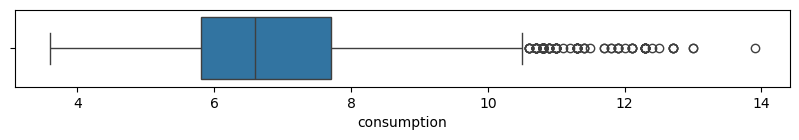

In [7816]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='consumption')

## 2.4 - ``power_cv``

<Axes: xlabel='power_cv'>

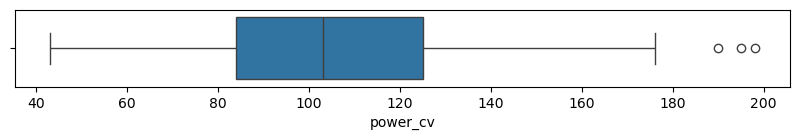

In [7817]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='power_cv')

Everything looks good

## 2.5 - ``fuel``

In [7818]:
df.fuel.unique()

array(['Diésel', 'Gasolina'], dtype=object)

In [7819]:
# translating the values into English
df.fuel = np.where(df['fuel'] == 'Diésel', 'Diesel', 'Gasoline')
df.fuel.unique()

array(['Diesel', 'Gasoline'], dtype=object)

In [7820]:
df.sample(5)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
2455,Mercedes-Benz,V,45580,6,Diesel,124308,176,1950,5.9,6,1,both-sided
1848,Citroën,Jumpy,12900,10,Diesel,146500,94,1997,6.6,9,2,both-sided
7999,Renault,Trafic,15351,9,Diesel,149620,70,1598,6.3,9,1,right
12952,Mercedes-Benz,V,70950,2,Diesel,36226,174,1950,8.3,6,1,both-sided
8628,Volkswagen,T6,14161,10,Diesel,129800,103,1968,6.9,3,2,right


In [7821]:
df.fuel.value_counts()

fuel
Diesel      16180
Gasoline     1503
Name: count, dtype: int64

In [7822]:
df.shape

(17683, 12)

## 2.6 - ``seats``

<Axes: xlabel='seats'>

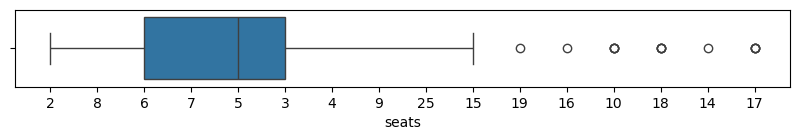

In [7823]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='seats')

In [7824]:
# looking at the extreme values of seats
df.sort_values('seats', ascending=False).head(5)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
18635,Ford,Custom,33590,7,Diesel,10000,96,1995,6.8,9,1,right
17101,Ford,Custom,16000,6,Diesel,225850,77,1995,6.4,9,1,right
7654,Mercedes-Benz,Sprinter,27989,6,Diesel,162750,105,2143,7.1,9,1,right
17089,Ford,Custom,7900,15,Diesel,233000,63,2198,7.5,9,2,right
17094,Ford,Custom,16990,8,Diesel,230000,96,1995,6.0,9,1,right


In [7825]:
df[df['model']=='Vito'].seats.unique()

array(['2', '3', '4', '5', '8', '6', '9', '7', '25'], dtype=object)

In [7826]:
# I look for the vans online and from the pictures (and the title) I see the real number of seats, some of them are correct
df.seats = np.where(df.seats == 25, 5, df.seats)
df.seats = np.where(df.seats == 19, 9, df.seats)

<Axes: xlabel='seats'>

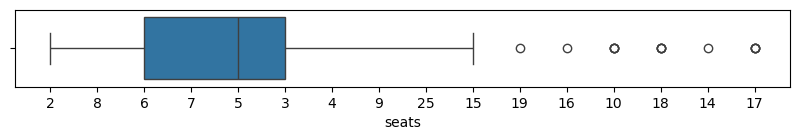

In [7827]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='seats')

<Axes: xlabel='count', ylabel='seats'>

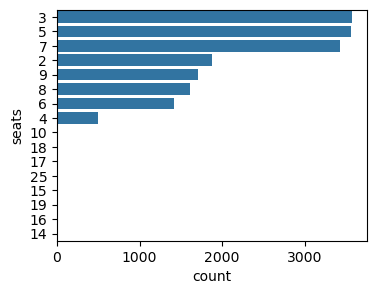

In [7828]:
# number of seats
plt.figure(figsize=(4,3))
order = df.seats.value_counts().keys()
sns.countplot(data=df, y='seats', order=order)

In [7829]:
df.seats.value_counts()

seats
3     3577
5     3563
7     3428
2     1872
9     1705
8     1614
6     1415
4      491
10       4
18       4
17       4
25       2
15       1
19       1
16       1
14       1
Name: count, dtype: int64

The number of vans that have 10 seats or more is ridiculous, I'm gonna drop these values

In [7830]:
df.seats = df.seats.astype(int)
df = df[df.seats<10]
df.seats.value_counts()

seats
3    3577
5    3563
7    3428
2    1872
9    1705
8    1614
6    1415
4     491
Name: count, dtype: int64

In [7831]:
df.seats = df.seats.astype(str)

## 2.7 - ``owners``

In [7832]:
df.owners.dtype

dtype('O')

In [7833]:
df.owners.unique()

array(['2', '1', '3', '4', '0', 'Nuevo', 'Negro Metalizado', '08/2023',
       '05/2026', '07/2026', 'Plateado Metalizado', '04/2026',
       'Gris Metalizado', '01/2027', '08/2027', '09/2025', '03/2026',
       '09/2026', '12/2025'], dtype=object)

In [7834]:
owners_correct = ['1', '2', '3', '4', 1, 2, 3, 4]
df[~df['owners'].isin(owners_correct)].sort_values('km') # I check the owners with strange values, NOT in the list

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
15916,Volkswagen,Caddy,31890,1,Diesel,10000,75,1968,5.2,5,08/2027,both-sided
16065,Volkswagen,T6,44980,1,Diesel,12000,110,1968,7.2,2,Nuevo,right
18585,Ford,Connect,26990,1,Diesel,13500,90,1968,5.0,5,0,both-sided
14749,Toyota,Proace,59890,2,Diesel,19500,130,1997,7.4,7,0,both-sided
18498,Ford,Connect,18688,2,Diesel,19550,74,1499,5.0,2,0,right
14336,Mercedes-Benz,Vito,33261,2,Diesel,26879,120,1950,7.2,3,Nuevo,right
13725,Renault,Trafic,24488,2,Diesel,27800,96,1997,6.7,3,0,right
13561,Renault,Trafic,16088,6,Diesel,29357,70,1598,7.4,3,0,right
18381,Ford,Connect,18490,6,Diesel,30000,74,1499,4.6,2,Nuevo,right
13459,Volkswagen,T6,75990,3,Diesel,30000,150,1968,8.6,7,01/2027,both-sided


I have to check one by one, because for some reason the coded failed

In [7835]:
df.owners = np.where((df.owners == '0'), 1, df.owners) # 0 owners makes no sense if it's not a new car, so I'm just gonna change it to 1 owner
df.owners = np.where((df.owners == '09/2025') & (df.km == 118244), 1, df.owners)
df.owners = np.where((df.owners == '03/2026') & (df.km == 109724), 1, df.owners)
df.owners = np.where((df.owners == '09/2026') & (df.km == 82891), 2, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 69500), 3, df.owners)
df.owners = np.where(df.owners == 'Negro Metalizado', 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 249000), np.nan, df.owners) # I cannot find it, maybe it has been sold
df.dropna(subset='owners', inplace=True)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 242000), 1, df.owners)
df.owners = np.where((df.owners == '08/2023') & (df.km == 229751), 2, df.owners)
df.owners = np.where((df.owners == '05/2026') & (df.km == 190000), 2, df.owners)
df.owners = np.where((df.owners == '07/2026') & (df.km == 169000), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 163000), 3, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 128000), 1, df.owners)
df.owners = np.where((df.owners == '08/2027') & (df.km == 10000), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 12000), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 26879), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 30000), 1, df.owners)
df.owners = np.where((df.owners == '01/2027') & (df.km == 30000), 2, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 34200), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 37141), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 38143), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 40220), 1, df.owners)
df.owners = np.where((df.owners == 'Gris Metalizado') & (df.km == 42800), 1, df.owners)
df.owners = np.where((df.owners == '04/2026') & (df.km == 43000), 2, df.owners)
df.owners = np.where((df.owners == '12/2025') & (df.km == 46647), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 47900), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 50000), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 50900), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 77332), 1, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 92290), 2, df.owners)
df.owners = np.where((df.owners == 'Nuevo') & (df.km == 100881), 1, df.owners)
df.owners = np.where((df.owners == 'Plateado Metalizado') & (df.km == 111600), 2, df.owners)

df.owners.unique()

array(['2', '1', '3', '4', 1, 3, 2], dtype=object)

In [7836]:
df.owners = df.owners.astype(str)
df.owners.unique()

array(['2', '1', '3', '4'], dtype=object)

In [7837]:
df.owners.value_counts()

owners
1    12588
2     4395
3      616
4       65
Name: count, dtype: int64

# **3. Data preprocessing**

In [7838]:
df.head()

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
0,Mercedes-Benz,Vito,8999,12,Diesel,551000,165,2987,8.6,2,2,both-sided
1,Mercedes-Benz,V,20800,9,Diesel,539000,120,2143,6.1,8,2,both-sided
2,Mercedes-Benz,V,19900,9,Diesel,531766,140,2143,6.0,6,1,both-sided
3,Mercedes-Benz,V,28600,7,Diesel,520093,140,2143,6.0,8,1,both-sided
4,Mercedes-Benz,V,29990,8,Diesel,519211,140,2143,6.0,8,1,both-sided


Here I will manage real values that don't add to the model and it's best to drop them, like outliers.

In [7839]:
# I make a copy of the dataframe before dropping more rows
df_original = df.copy()

## 3.1 - Numerical variables

In [7840]:
numericals = df.select_dtypes(np.number)
numericals.head()

,price,age,km,power_cv,displacement_cm3,consumption
0,8999,12,551000,165,2987,8.6
1,20800,9,539000,120,2143,6.1
2,19900,9,531766,140,2143,6.0
3,28600,7,520093,140,2143,6.0
4,29990,8,519211,140,2143,6.0


<Axes: >

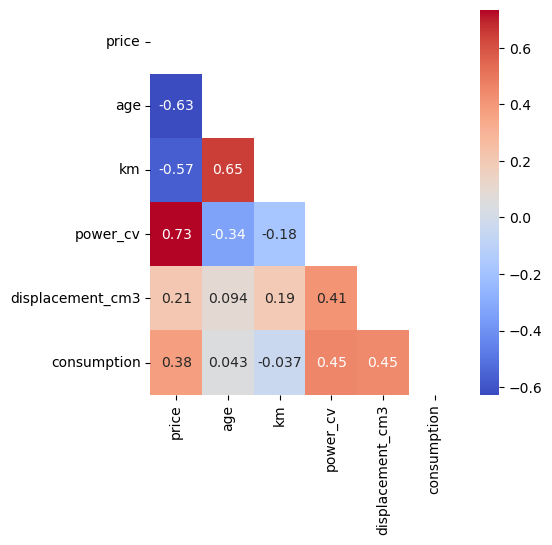

In [7841]:
numericals = df.select_dtypes(np.number)
plt.figure(figsize=(5,5)) # I create a heatmap so I have a general vision of the relationship between the different features
corr = numericals.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)

The features that affect the most the price according to the heatmap are ``power_cv``, ``age`` and ``km``

### **3.1.1 - Predictions**

I want to make some predictions now, even if the model is not finished, so I can take a general look and fix mistakes

In [7842]:
numericals = df.select_dtypes(np.number)
y = numericals['price']
X = numericals.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)

r2 = r2_score(y_test, predictions)
print(f'R2: {r2:.6f}')
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse:.6f}')
mape = np.mean(np.abs((y_test - predictions)/y_test)*100)
print(f'MAPE: {mape:.6f}%')

R2: 0.773563
MSE: 80683683.793481
MAPE: 36.978360%


In [7843]:
data = np.array([predictions, y_test, X_test.km, X_test.age, X_test.power_cv]) # adding the features that affect the most the price according to the heatmap (age, km and power_cv)
dataset = pd.DataFrame({'Prediction': data[0][i], 'y_test': data[1][i], 'km': data[2][i], 'age': data[3][i], 'power_cv': data[4][i]} for i in range(len(data[0]))).astype(int)
dataset['difference'] = dataset['Prediction'] - dataset['y_test']
dataset['percentage'] = dataset.difference / dataset.Prediction
dataset

,Prediction,y_test,km,age,power_cv,difference,percentage
0,52341,63487,29353,2,140,-11146,-0.212950
1,43279,45990,27677,1,110,-2711,-0.062640
2,20884,27500,48709,6,75,-6616,-0.316798
3,49685,57997,67600,4,150,-8312,-0.167294
4,63056,77800,30530,2,174,-14744,-0.233824
...,...,...,...,...,...,...,...
3528,64028,68490,22967,3,174,-4462,-0.069688
3529,4135,4499,165500,18,70,-364,-0.088029
3530,27026,32900,259000,9,140,-5874,-0.217346
3531,28767,21890,44691,2,85,6877,0.239059


In [7844]:
dataset.sort_values('percentage').head(10) # let's see which values cause a higher percentage (higher error)

,Prediction,y_test,km,age,power_cv,difference,percentage
538,49,5990,180100,14,63,-5941,-121.244898
395,65,3340,175000,13,66,-3275,-50.384615
165,184,4990,215000,14,63,-4806,-26.119565
2310,315,6900,395850,13,100,-6585,-20.904762
1684,380,7150,114000,14,55,-6770,-17.815789
312,721,11889,216000,18,75,-11168,-15.489598
1509,477,7498,230000,9,66,-7021,-14.719078
2275,508,7500,175000,13,68,-6992,-13.763780
1458,653,9490,211087,14,75,-8837,-13.532925
2128,732,7998,118000,15,63,-7266,-9.926230


The problem lays within predicted values close to 0, a limitation MAPE has.

In [7845]:
dataset.Prediction.min()

-44828

I have negative values of predicted prices, which doesn't make sense in real life, let's take a closer look

<Axes: xlabel='Prediction', ylabel='Count'>

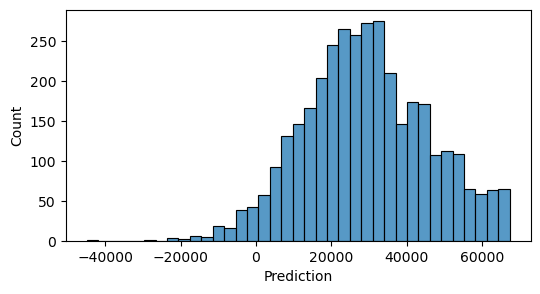

In [7846]:
plt.figure(figsize=(6,3))
sns.histplot(dataset.Prediction)

In [7847]:
dataset.sort_values('Prediction').head(10).style.bar()

,Prediction,y_test,km,age,power_cv,difference,percentage
1754,-44828,6999,988000,14,84,-51827,1.156130
1433,-28392,5900,684699,14,75,-34292,1.207805
1659,-23316,6950,411488,27,75,-30266,1.298079
954,-22547,14430,466453,23,75,-36977,1.639996
1729,-21172,3200,371000,15,50,-24372,1.151143
1947,-19983,5990,347000,28,75,-25973,1.299755
3237,-17899,3999,317000,28,75,-21898,1.223420
2107,-17052,2298,384000,16,66,-19350,1.134764
3084,-16664,2000,271000,21,55,-18664,1.120019
1390,-16319,3850,363200,23,74,-20169,1.235921


All these vans with predicted negative prices have either a large number of km, are old or they don't have so much power_cv, the 3 features we saw in the heatmap they affect the most the price

In [7848]:
dataset.sort_values('y_test').head(10) # sorting by the cheapest vans

,Prediction,y_test,km,age,power_cv,difference,percentage
700,-10735,1290,129000,23,46,-12025,1.120168
2489,-4942,1490,199000,21,77,-6432,1.301497
3468,-3112,1490,244000,16,55,-4602,1.478792
2716,-10389,1699,194648,18,55,-12088,1.163538
1831,-8647,1850,256580,18,66,-10497,1.213947
2781,-6570,1950,332000,16,74,-8520,1.296804
1196,-9510,1990,235000,17,63,-11500,1.209253
23,-12397,2000,306737,23,74,-14397,1.161329
3084,-16664,2000,271000,21,55,-18664,1.120019
2107,-17052,2298,384000,16,66,-19350,1.134764


In [7849]:
dataset.sort_values('age', ascending=False).head(10) # sorting by the oldest vans

,Prediction,y_test,km,age,power_cv,difference,percentage
3237,-17899,3999,317000,28,75,-21898,1.223420
1947,-19983,5990,347000,28,75,-25973,1.299755
1659,-23316,6950,411488,27,75,-30266,1.298079
3042,1340,13990,235500,26,111,-12650,-9.440299
1871,-12794,7222,439000,26,111,-20016,1.564483
745,-2694,6980,168000,25,75,-9674,3.590943
765,-10864,14490,285621,25,75,-25354,2.333763
2888,-6737,7750,395000,24,111,-14487,2.150364
2744,-8812,4799,300620,24,75,-13611,1.544598
552,-3644,5900,114000,24,63,-9544,2.619100


In [7850]:
dataset.sort_values('km', ascending=False).head(10) # sorting by the vans with the highest number of km

,Prediction,y_test,km,age,power_cv,difference,percentage
1754,-44828,6999,988000,14,84,-51827,1.156130
2966,-5893,13990,712000,6,120,-19883,3.374003
1433,-28392,5900,684699,14,75,-34292,1.207805
1888,-3197,7999,550000,13,120,-11196,3.502033
3371,-15793,2950,548000,14,85,-18743,1.186792
2645,-14496,10769,546736,12,80,-25265,1.742895
886,9944,28600,520093,7,140,-18656,-1.876106
3070,-3290,21500,515001,8,100,-24790,7.534954
2652,7379,19990,491000,11,140,-12611,-1.709039
2389,-11062,6990,472000,6,74,-18052,1.631893


In [7851]:
dataset.sort_values('power_cv').head(10) # sorting by the vans with the weakest engines

,Prediction,y_test,km,age,power_cv,difference,percentage
1623,-10316,2299,103000,22,43,-12615,1.222858
700,-10735,1290,129000,23,46,-12025,1.120168
1911,-8773,6490,159491,17,50,-15263,1.739770
1729,-21172,3200,371000,15,50,-24372,1.151143
3074,1114,7650,52700,15,50,-6536,-5.867145
513,8453,7790,44410,12,54,663,0.078434
818,5399,9600,155321,6,55,-4201,-0.778107
2056,3462,6683,44964,18,55,-3221,-0.930387
50,-11458,5999,320000,12,55,-17457,1.523564
3373,7465,9390,156000,3,55,-1925,-0.257870


In [7852]:
dataset.sort_values('y_test').head(20).Prediction.mean() # sorting by the cheapest vans

-8485.4

In [7853]:
dataset.sort_values('age', ascending=False).head(20).Prediction.mean() # sorting by the oldest vans

-9193.05

In [7854]:
dataset.sort_values('km', ascending=False).head(20).Prediction.mean() # sorting by the vans with the highest number of km

-6075.2

In [7855]:
dataset.sort_values('power_cv').head(20).Prediction.mean() # sorting by the vans with the weakest engines

541.15

I confirm the theory I had, and with the means I could see that the 2 features that cause negative predicted prices the most are the **low price** and the **old age**

Conclusion: I think it's best to drop the vans that have an extreme value of these 3 features: ``power_cv``, ``age`` and ``km``, plus the cheapest vans

### 3.1.2 - Scatterplots

I want to create scatterplots to have a general view of the relationship between each variable with the price

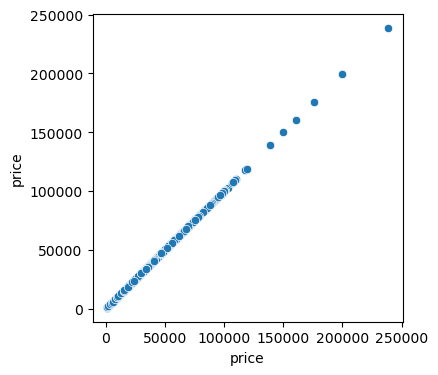

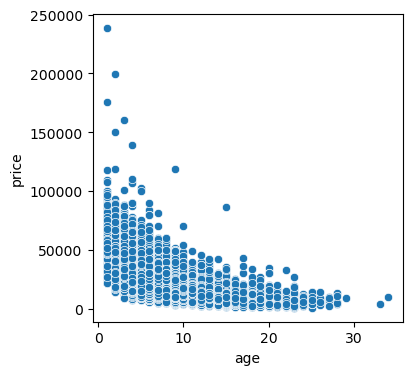

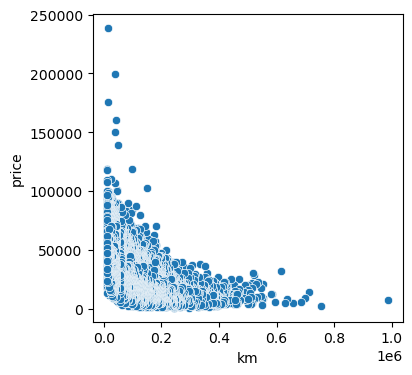

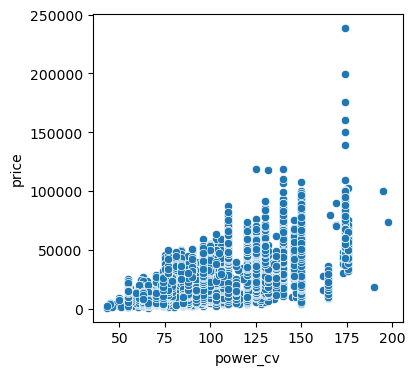

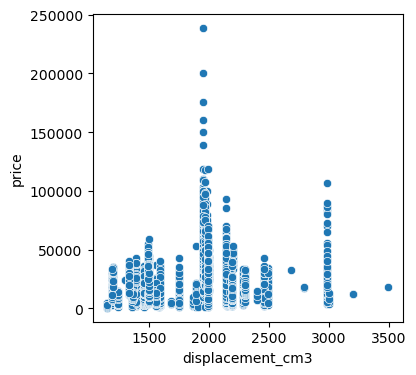

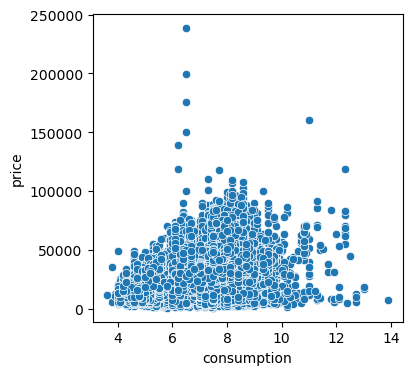

In [7856]:
numericals = df.select_dtypes(np.number) # separate the X numerical variables
for i in numericals.columns:
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df, x=i, y='price')

### 3.1.3 - Dropping outliers

In the previous scatterplots, we saw vans that didn't respond to a pattern like others, vans that we can see as isolated points, which I prefer to drop since they don't explain the price like the rest of the vans.

#### 3.1.3.1 - ``price``

<Axes: xlabel='price'>

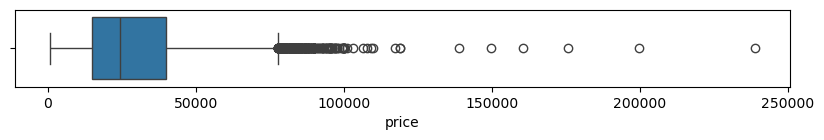

In [7857]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='price')

There are some outliers with extreme values of ``price``, let's take a look

In [7858]:
df.sort_values('price', ascending=False).head(15)

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
15489,Mercedes-Benz,V,238880,1,Diesel,14000,174,1950,6.5,6,1,both-sided
12832,Mercedes-Benz,V,199880,2,Diesel,37500,174,1950,6.5,6,1,both-sided
15490,Mercedes-Benz,V,175880,1,Diesel,14000,174,1950,6.5,7,1,both-sided
11919,Mercedes-Benz,V,160531,3,Diesel,43000,174,1950,11.0,6,1,both-sided
12833,Mercedes-Benz,V,149880,2,Diesel,37500,174,1950,6.5,6,1,both-sided
5377,Mercedes-Benz,Vito,138900,4,Diesel,48000,174,1950,6.2,6,2,both-sided
16663,Ford,Custom,119000,9,Diesel,98000,125,1995,6.2,5,2,both-sided
16098,Mercedes-Benz,Sprinter,118881,2,Diesel,11445,140,1950,12.3,2,1,right
16171,Volkswagen,T6,117440,1,Gasoline,10000,132,1968,7.7,5,1,right
13852,Mercedes-Benz,V,110000,4,Diesel,26000,140,1950,7.3,6,2,both-sided


I tried dropping vans with different prices and observed that in some of these case, the metrics worsened: R squared decreased and MAPE increased.

So I decide to iterate over the most expensive vans, dropping the most expensive van one at a time and compare in each iteration how does the MAPE change.

In [7859]:
data = df.sort_values('price', ascending=False).head(14)
data.reset_index(drop=True, inplace=True)

# initial metrics
numericals = df.select_dtypes(np.number) # we separate the X numerical variables
y = numericals['price']
X = numericals.drop(columns=['price']) # drop the constant
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # define the parameters
lm = linear_model.LinearRegression() # create the model
lm.fit(X_train, y_train) # train the model
predictions = lm.predict(X_test) # calculate predictions
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions)/y_test)*100)
min_mape = mape

for i in range(len(data)):
    max_price = df['price'].max()  # Find the current max price
    df = df[df.price < max_price]  # Remove the row with the max price

    print(f'Dropping van that costs {max_price}€')

    numericals = df.select_dtypes(np.number) # we separate the X numerical variables
    y = numericals['price']
    X = numericals.drop(columns=['price']) # drop the constant
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) # define the parameters
    lm = linear_model.LinearRegression() # create the model
    lm.fit(X_train, y_train) # train the model
    predictions = lm.predict(X_test) # calculate predictions
    r21 = r2_score(y_test, predictions)
    mse1 = mean_squared_error(y_test, predictions)
    mape1 = np.mean(np.abs((y_test - predictions)/y_test)*100)

    print(f'MAPE initial: {mape}')
    print(f'MAPE current: {mape1}')
    print(f'{df.shape}')

    if mape1 > mape:
        print('Damn, MAPE increased')
    else:
        print('Yay!')
    mape = mape1

    if mape1 < min_mape:
        min_mape = mape1
        print('Hoorray! New all-time low record for MAPE!') # I write a long sentence so I can tell it apart quickly when I look at all the iterations

    print(f'min MAPE: {min_mape}\n')

Dropping van that costs 238880€
MAPE initial: 36.97834301858388
MAPE current: 36.402631104366634
(17663, 12)
Yay!
Hoorray! New all-time low record for MAPE!
min MAPE: 36.402631104366634

Dropping van that costs 199880€
MAPE initial: 36.402631104366634
MAPE current: 36.098481447943286
(17662, 12)
Yay!
Hoorray! New all-time low record for MAPE!
min MAPE: 36.098481447943286

Dropping van that costs 175880€
MAPE initial: 36.098481447943286
MAPE current: 36.33905455876337
(17661, 12)
Damn, MAPE increased
min MAPE: 36.098481447943286

Dropping van that costs 160531€
MAPE initial: 36.33905455876337
MAPE current: 36.800660375677985
(17660, 12)
Damn, MAPE increased
min MAPE: 36.098481447943286

Dropping van that costs 149880€
MAPE initial: 36.800660375677985
MAPE current: 36.581893693628544
(17659, 12)
Yay!
min MAPE: 36.098481447943286

Dropping van that costs 138900€
MAPE initial: 36.581893693628544
MAPE current: 36.42956325152637
(17658, 12)
Yay!
min MAPE: 36.098481447943286

Dropping van tha

After some tests I find that dropping the 10 most expensive vans gives me the best metrics, a higher R squared and lower MAPE. 

I could continue iterating with more vans, and I saw that the MAPE decreased even more, but for me it doesn't make sense for various reasons:
- The R squared decreased (worsened)
- The dataset got smaller because I deleted many vans
- I might be overfitting the model, meaning it would be not be that good in predicting new values, or expensive vans

In [7860]:
df = df[df.price<102000] # dropping the vans more expensive than 102.000€
df.reset_index(drop=True, inplace=True)
df.price.mean()

29233.77943342776

Like I said before, I also want to drop the cheapest vans, because they can partly create negative predicted prices

In [7861]:
df = df[df.price>np.percentile(df.price, 1)] # dropping the 1% cheapest vans
df.reset_index(drop=True, inplace=True)
df.price.mean()

29505.321657509157

<Axes: xlabel='price'>

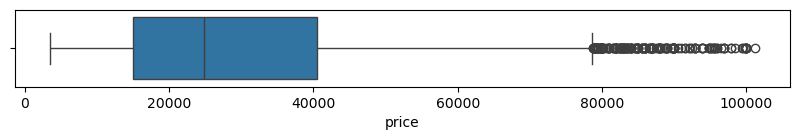

In [7862]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x='price')

#### 3.1.3.2 - ``km``

<Axes: xlabel='km', ylabel='price'>

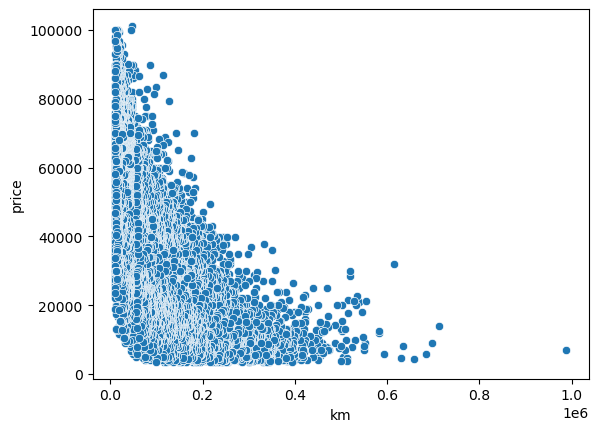

In [7863]:
sns.scatterplot(df, x='km', y='price')

In [7864]:
df.km.mean()

107059.98506181319

In [7865]:
# deleting the van with the highest number of km
df = df[df['km']<900000]
df.km.mean() # checking it has decreased

107009.56207429455

In [7866]:
# a van that is also an outlier
df[df.km>600000].query('price>20000')

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
4828,Volkswagen,T6,31880,5,Diesel,614849,81,1968,7.6,9,1,right


In [7867]:
# dropping this van
df.model = np.where((df.model=='T6') & (df.km==614849), np.nan, df.model)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

<Axes: xlabel='km', ylabel='price'>

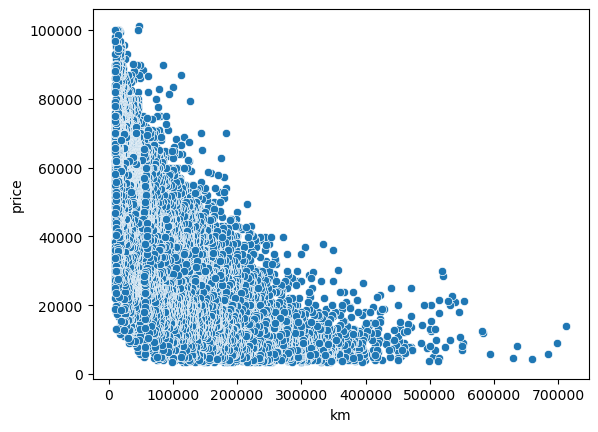

In [7868]:
sns.scatterplot(df, x='km', y='price')

In [7869]:
df.km.mean()

106980.49284487694

#### 3.1.3.3 - ``age``

<Axes: xlabel='age', ylabel='price'>

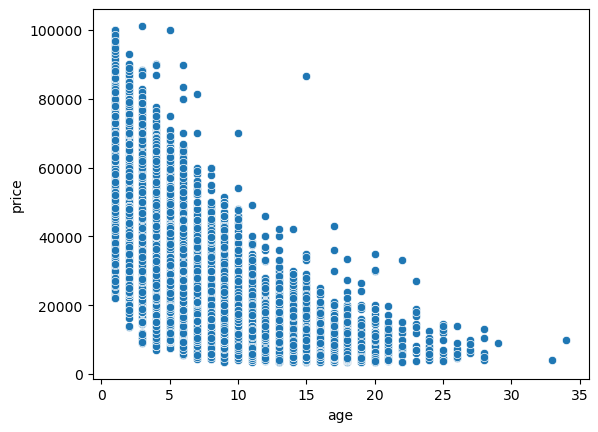

In [7870]:
sns.scatterplot(df, x='age', y='price')

In [7871]:
# dropping an outlier, a van with a high price considering how old it is
df[df.age>13].query('price>80000')

,brand,model,price,age,fuel,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors
11223,Mercedes-Benz,Sprinter,86500,15,Diesel,61500,140,2987,10.2,9,1,right


In [7872]:
# it turns out that like before (Iveco Daily), it's a big van, meaning the size has a significant effect on the price, but still this particular van is overpriced, as we see in the scatterplot
df.model = np.where((df.model=='Sprinter') & (df.price==86500), np.nan, df.model)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

<Axes: xlabel='age', ylabel='price'>

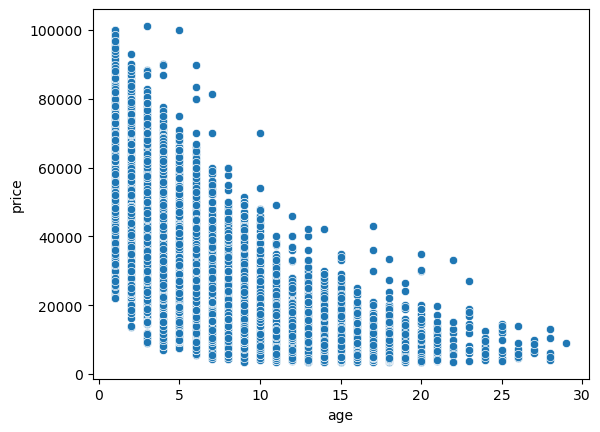

In [7873]:
# I drop also the oldest vans, the ones that can cause the model to predict negative prices
df = df[df['age']<30]
df.reset_index(drop=True, inplace=True)
sns.scatterplot(df, x='age', y='price')

#### 3.1.3.4 - ``power_cv``

In [7874]:
# I drop also the weakest vans, the ones that can cause the model to predict negative prices
df = df[df['age']<np.percentile(df.power_cv, 1)] # dropping the 1% weakest vans
df.reset_index(drop=True, inplace=True)

#### OLS

In [7875]:
OLS(df)

R2: 0.78627
MSE: 73118118.48260
MAPE: 32.89730%


We observe that **after removing these vans** with extreme values, though the MSE has slightly increased (worsened), the R squared has increased and **the MAPE has decreased**, which tells us the Mean Average Percentage Error, or in other words, the mean difference between the real prices and the predicted prices.

In my case, **I care more about the MAPE** than the MSE, because the MSE only considers the absolut error; a 5.000€ error is treated the same wether the van costs 20.000€ or 50.000€.

On the other hand, MAPE takes into consideration the real price vs the predicted price, so this 5.000€ error in the 20.000€ van represents a 25%, while in the 50.000€ van represents only a 10%, it's a better prediction.

In [7876]:
for i in numericals.columns:
    skewness = skew(numericals[i])
    print(f'{i}: {skewness:.2f}')

price: 0.89
age: 1.31
km: 1.47
power_cv: 0.60
displacement_cm3: -0.27
consumption: 0.35


## 3.2 - Categorical variables

In [7877]:
categoricals = df.select_dtypes(object)
categoricals.sample(5)

,brand,model,fuel,seats,owners,sliding_doors
11090,Mercedes-Benz,Vito,Diesel,9,1,right
3887,Volkswagen,Caddy,Diesel,5,2,both-sided
12130,Mercedes-Benz,V,Diesel,7,2,both-sided
2902,Volkswagen,T5,Diesel,7,2,both-sided
13665,Mercedes-Benz,T,Diesel,5,1,right


### 3.2.1 - ``fuel``

In [7878]:
df.fuel.unique()

array(['Diesel', 'Gasoline'], dtype=object)

In [7879]:
df = pd.get_dummies(df, columns=['fuel'],drop_first=True)

In [7880]:
df.sample(5) # let's a take a look

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,seats,owners,sliding_doors,fuel_Gasoline
9349,Volkswagen,T6,25499,6,88900,110,1968,5.8,3,1,right,False
10181,Opel,Combo,15770,4,68000,75,1499,6.1,2,1,right,False
6898,Volkswagen,T6,20500,4,161800,110,1968,5.9,2,1,right,False
6724,Volkswagen,T6,19800,6,169000,110,1968,5.9,2,1,right,False
634,Volkswagen,Caddy,17990,6,199062,110,1968,5.6,5,1,both-sided,False


In [7881]:
df.fuel_Gasoline = df.fuel_Gasoline.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17467 entries, 0 to 17466
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             17467 non-null  object 
 1   model             17467 non-null  object 
 2   price             17467 non-null  int64  
 3   age               17467 non-null  int32  
 4   km                17467 non-null  int64  
 5   power_cv          17467 non-null  int32  
 6   displacement_cm3  17467 non-null  int64  
 7   consumption       17467 non-null  float64
 8   seats             17467 non-null  object 
 9   owners            17467 non-null  object 
 10  sliding_doors     17467 non-null  object 
 11  fuel_Gasoline     17467 non-null  int32  
dtypes: float64(1), int32(3), int64(3), object(5)
memory usage: 1.4+ MB


### 3.2.2 - ``owners``

In [7882]:
df.owners.unique()

array(['2', '1', '3', '4'], dtype=object)

In [7883]:
df.owners = df.owners.astype(int)

In [7884]:
df.owners.value_counts()

owners
1    12531
2     4303
3      573
4       60
Name: count, dtype: int64

Since most of the vans have only had 1 owner, I'm gonna group the other vans in one category.

In [7885]:
df.owners = np.where(df.owners > 1, 'several', df.owners)

In [7886]:
df = pd.get_dummies(df, columns=['owners'],drop_first=True)

In [7887]:
df.head()

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,seats,sliding_doors,fuel_Gasoline,owners_several
0,Mercedes-Benz,Vito,8999,12,551000,165,2987,8.6,2,both-sided,0,True
1,Mercedes-Benz,V,20800,9,539000,120,2143,6.1,8,both-sided,0,True
2,Mercedes-Benz,V,19900,9,531766,140,2143,6.0,6,both-sided,0,False
3,Mercedes-Benz,V,28600,7,520093,140,2143,6.0,8,both-sided,0,False
4,Mercedes-Benz,V,29990,8,519211,140,2143,6.0,8,both-sided,0,False


In [7888]:
df.owners_several = df.owners_several.astype(int)
df.head()

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,seats,sliding_doors,fuel_Gasoline,owners_several
0,Mercedes-Benz,Vito,8999,12,551000,165,2987,8.6,2,both-sided,0,1
1,Mercedes-Benz,V,20800,9,539000,120,2143,6.1,8,both-sided,0,1
2,Mercedes-Benz,V,19900,9,531766,140,2143,6.0,6,both-sided,0,0
3,Mercedes-Benz,V,28600,7,520093,140,2143,6.0,8,both-sided,0,0
4,Mercedes-Benz,V,29990,8,519211,140,2143,6.0,8,both-sided,0,0


In [7889]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17467 entries, 0 to 17466
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             17467 non-null  object 
 1   model             17467 non-null  object 
 2   price             17467 non-null  int64  
 3   age               17467 non-null  int32  
 4   km                17467 non-null  int64  
 5   power_cv          17467 non-null  int32  
 6   displacement_cm3  17467 non-null  int64  
 7   consumption       17467 non-null  float64
 8   seats             17467 non-null  object 
 9   sliding_doors     17467 non-null  object 
 10  fuel_Gasoline     17467 non-null  int32  
 11  owners_several    17467 non-null  int32  
dtypes: float64(1), int32(4), int64(3), object(4)
memory usage: 1.3+ MB


### 3.2.3 - ``sliding_doors``

In [7890]:
df.sliding_doors.unique()

array(['both-sided', 'left', 'right'], dtype=object)

In general, all vans have the rear right door, but not all of them have the left one.

So I can just change the values of ``sliding_door = left`` into one single value of ``sliding_door = both-sided``

In [7891]:
df.sliding_doors = np.where(df.sliding_doors == 'left', 'both-sided', df.sliding_doors)
df['sliding_doors_both_sided'] = np.where(df.sliding_doors == 'both-sided', 1, 0)
df.drop(columns='sliding_doors', inplace=True)

In [7892]:
# df = pd.get_dummies(df, columns=['sliding_doors'],drop_first=False)

In [7893]:
df.sample(5) # let's a take a look

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,seats,fuel_Gasoline,owners_several,sliding_doors_both_sided
10245,Renault,Kangoo,10490,6,66000,66,1461,4.3,2,0,0,0
11766,Dacia,Dokker,27950,5,39700,96,1332,6.2,5,1,0,1
11549,Volkswagen,Caddy,34990,3,41622,90,1968,4.6,7,0,0,1
14651,Volkswagen,Multivan,57710,3,13098,150,1984,9.0,6,1,0,1
7465,Volkswagen,T5,17500,13,141000,103,1968,8.8,7,0,0,0


In [7894]:
df.sliding_doors_both_sided = df.sliding_doors_both_sided.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17467 entries, 0 to 17466
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     17467 non-null  object 
 1   model                     17467 non-null  object 
 2   price                     17467 non-null  int64  
 3   age                       17467 non-null  int32  
 4   km                        17467 non-null  int64  
 5   power_cv                  17467 non-null  int32  
 6   displacement_cm3          17467 non-null  int64  
 7   consumption               17467 non-null  float64
 8   seats                     17467 non-null  object 
 9   fuel_Gasoline             17467 non-null  int32  
 10  owners_several            17467 non-null  int32  
 11  sliding_doors_both_sided  17467 non-null  int32  
dtypes: float64(1), int32(5), int64(3), object(3)
memory usage: 1.3+ MB


### 3.2.4 - ``seats`` and ``cargo``

In [7895]:
df.seats.unique()

array(['2', '8', '6', '7', '5', '3', '4', '9'], dtype=object)

In [7896]:
df.seats = df.seats.astype(int)

<Axes: xlabel='seats', ylabel='price'>

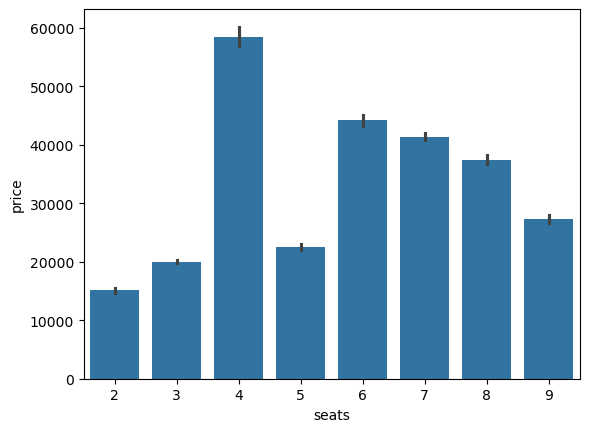

In [7897]:
sns.barplot(df, y='price', x='seats')

Vans with 2 and 3 seats are cargo vans, theorically cheaper than passenger vans, and vans with more than 5 seats are bigger vans, so they are usually more expensive

We can confirm both theories with the previous barplot. Therefore, I add a new feature which will affect the price as well

In [7898]:
df.seats.value_counts()

seats
3    3550
5    3465
7    3419
2    1831
9    1696
8    1611
6    1406
4     489
Name: count, dtype: int64

In [7899]:
df['cargo'] = np.where((df.seats==2) | (df.seats==3), 1, 0) # vans with 2 or 3 seats are cargo vans, and the rest are passenger vans

<Axes: xlabel='cargo', ylabel='price'>

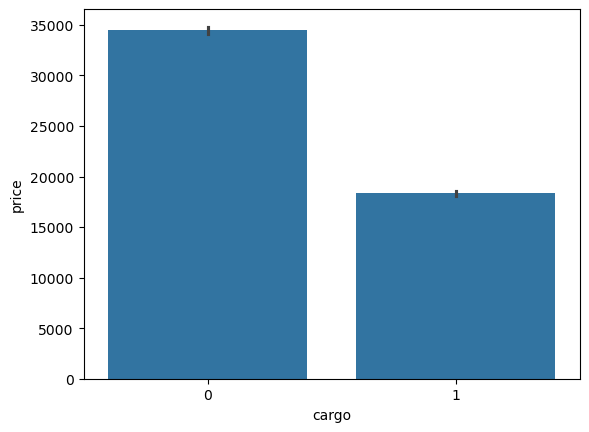

In [7900]:
sns.barplot(df, y='price', x='cargo')

In [7901]:
df.head()

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,seats,fuel_Gasoline,owners_several,sliding_doors_both_sided,cargo
0,Mercedes-Benz,Vito,8999,12,551000,165,2987,8.6,2,0,1,1,1
1,Mercedes-Benz,V,20800,9,539000,120,2143,6.1,8,0,1,1,0
2,Mercedes-Benz,V,19900,9,531766,140,2143,6.0,6,0,0,1,0
3,Mercedes-Benz,V,28600,7,520093,140,2143,6.0,8,0,0,1,0
4,Mercedes-Benz,V,29990,8,519211,140,2143,6.0,8,0,0,1,0


In [7902]:
df.columns

Index(['brand', 'model', 'price', 'age', 'km', 'power_cv', 'displacement_cm3',
       'consumption', 'seats', 'fuel_Gasoline', 'owners_several',
       'sliding_doors_both_sided', 'cargo'],
      dtype='object')

In [7903]:
df.drop(columns='seats', inplace=True) # I don't need it anymore

### 3.2.5 - ``brand`` and ``model``

I have to simplify the dataset, I could separate the brands into 3 categories in terms of the mean price of their vans, and also their models, because usually brands have different types of vans for different targets.

<Axes: xlabel='price', ylabel='brand'>

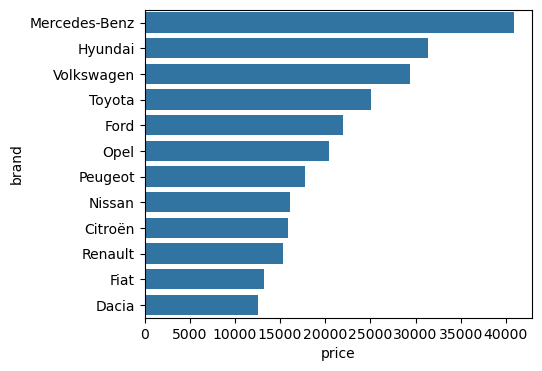

In [7904]:
price_per_brand = df.groupby(["brand"]).agg({'price': 'mean'}).sort_values('price', ascending=False).astype({'price': int}) # mean price per brand
plt.figure(figsize=(5,4))
sns.barplot(data=price_per_brand, y='brand', x='price')

In [7905]:
df.groupby(["brand"]).agg({'brand': 'count', 'price': 'mean'}).sort_values('price', ascending=False).astype({'price': int}) # mean price per brand

,brand,price
brand,,
Mercedes-Benz,5551,40843
Hyundai,96,31417
Volkswagen,5864,29349
Toyota,192,25093
Ford,2236,21965
Opel,1039,20384
Peugeot,397,17776
Nissan,155,16061
Citroën,627,15868


In [7906]:
df.groupby(["brand"]).agg({'brand': 'count', 'price': 'mean'}).sort_values('price', ascending=False).astype({'price': int}).index # to copy the brands into the next cell

Index(['Mercedes-Benz', 'Hyundai', 'Volkswagen', 'Toyota', 'Ford', 'Opel',
       'Peugeot', 'Nissan', 'Citroën', 'Renault', 'Fiat', 'Dacia'],
      dtype='object', name='brand')

I also think that the size is important, since the 2 most expensive brands are Iveco and MAN because they only have 1 model, 2 and 3 vans in total each and they are big vans, meaning they are more expensive.

In [7907]:
df.head()

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,fuel_Gasoline,owners_several,sliding_doors_both_sided,cargo
0,Mercedes-Benz,Vito,8999,12,551000,165,2987,8.6,0,1,1,1
1,Mercedes-Benz,V,20800,9,539000,120,2143,6.1,0,1,1,0
2,Mercedes-Benz,V,19900,9,531766,140,2143,6.0,0,0,1,0
3,Mercedes-Benz,V,28600,7,520093,140,2143,6.0,0,0,1,0
4,Mercedes-Benz,V,29990,8,519211,140,2143,6.0,0,0,1,0


In [7908]:
brand_expensive = ['Mercedes-Benz']
brand_medium = ['Hyundai', 'Volkswagen', 'Toyota', 'Ford', 'Opel', 'Peugeot']
brand_cheap = ['Nissan', 'Citroën', 'Renault', 'Fiat', 'Dacia']
df['brand_price'] = ''

df['brand_price'] = np.where(df['brand'].isin(brand_expensive), 2, df.brand_price)
df['brand_price'] = np.where(df['brand'].isin(brand_medium), 1, df.brand_price)
df['brand_price'] = np.where(df['brand'].isin(brand_cheap), 0, df.brand_price)

In [7909]:
df.sample(5)

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,fuel_Gasoline,owners_several,sliding_doors_both_sided,cargo,brand_price
11292,Volkswagen,T6,46990,5,60000,110,1968,6.5,0,0,0,0,1
9098,Volkswagen,Caddy,18800,3,94729,90,1968,4.9,0,0,0,1,1
1138,Mercedes-Benz,V,37500,8,165000,140,2143,6.7,0,0,1,0,2
7431,Fiat,Ducato,22586,4,142000,103,2287,7.4,0,0,0,0,0
1962,Volkswagen,T6,39800,7,126000,150,1968,6.8,0,0,1,0,1


In [7910]:
df['brand_price'] = df['brand_price'].astype(int)

In [7911]:
df.groupby(["brand", "model"]).agg({'model': 'count', 'price': 'mean', 'age': 'mean'}).sort_values(['brand', 'price']).astype({'price': int, 'age': int}) # mean price per model and brand

model  price  age
brand         model                              
Citroën       Nemo                  6   4676   13
              Berlingo            380  13934    7
              Jumper               83  14145    7
              Jumpy                92  15412    7
              SpaceTourer          66  30819    5
Dacia         Dokker              127  12600    7
Fiat          Qubo                 16   5995   12
              Fiorino              18   7304    9
              Doblo               125  10151    8
              Scudo                39  12622   11
              Ducato               88  16030    8
              Talento              74  18282    6
Ford          Connect             514  16211    6
              Transit             209  21424    6
              Custom             1513  23995    6
Hyundai       H350                  4  12812    7
              H-1                  45  17659   10
              Staria               47  46173    1
Mercedes-Benz Citan               310  16913    5
              Viano               129  18360   15
              T                   169  27351    2
              Vito               1469  27803    6
              Sprinter            972  32164    5
              V                  2433  56754    3
              Marco Polo           69  62295    3
Nissan        Kubistar              1   4900   17
              Serena                1   6490   26
              NV200                58  11206   10
              NV250                 6  12854    4
              NV400                23  15067    7
              NV300                34  18921    6
              Primastar             9  22159    9
              Townstar             23  24424    1
Opel          Combo               325  15558    6
              Vivaro              385  16893    7
              Movano              117  17617    5
              Zafira              212  35651    4
Peugeot       Bipper                3   5198   13
              Partner             129  10325    8
              Boxer               106  15431    7
              Rifter               89  19966    4
              Traveller            70  32813    4
Renault       Kangoo              340  10907    7
              Express               5  14359    3
              Master              115  16017    7
              Trafic              363  19136    6
Toyota        Hiace                 4   6950   17
              Proace              188  25479    4
Volkswagen    LT                    2   8217   20
              T4                   47   9957   24
              T5                  650  16470   14
              Caddy              2248  20904    7
              Crafter             316  24839    6
              T6                 2279  38822    5
              Multivan            110  54163    2
              T7                  202  54245    1
              Grand California     10  68423    2

In the previous groupby table we can see that each brand has vans for all budgets, so we cannot only distinguish the brands by their price range, also the models.

<Axes: xlabel='price', ylabel='model'>

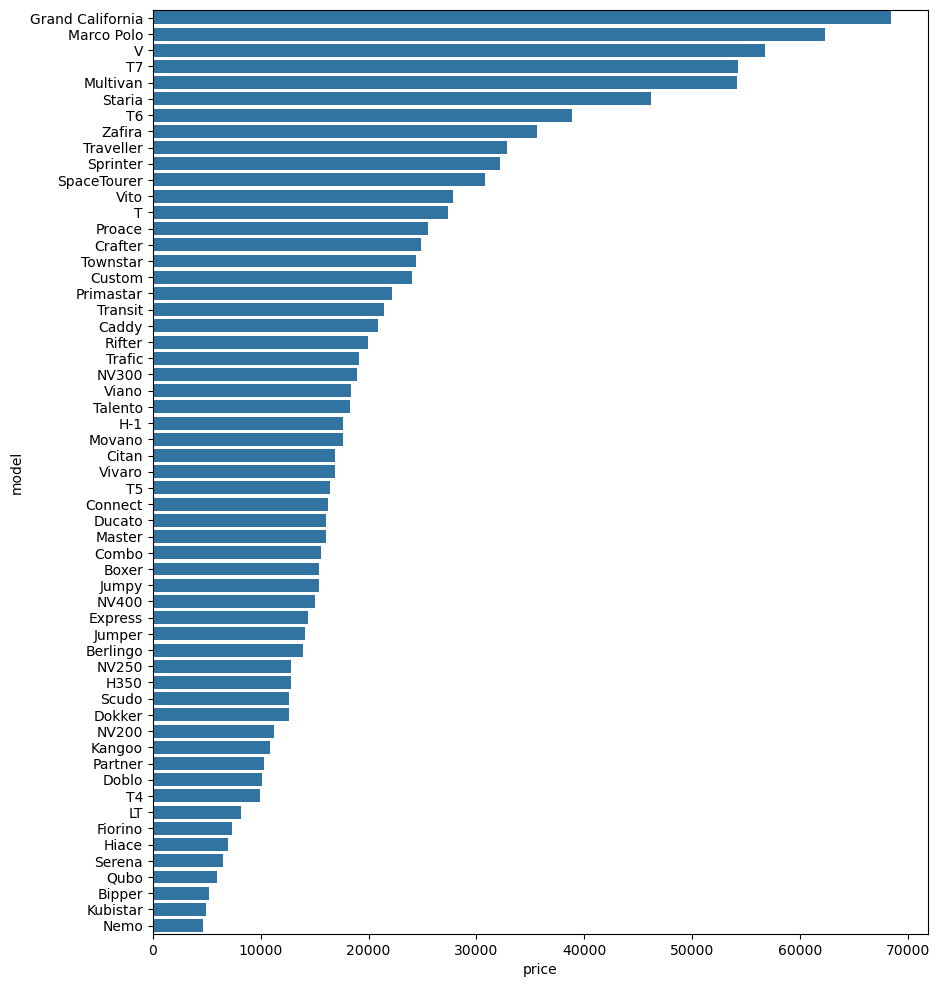

In [7912]:
price_per_model = df.pivot_table(values="price", index="model", aggfunc='mean').sort_values(['price'], ascending=False).astype({'price': int}) # mean price per model
plt.figure(figsize=(10,12))
sns.barplot(data=price_per_model, y='model', x='price')

In [7913]:
df.groupby(["model"]).agg({'price': 'mean'}).sort_values(['price'], ascending=False).astype({'price': int}).index # to copy the models into the next cell

Index(['Grand California', 'Marco Polo', 'V', 'T7', 'Multivan', 'Staria', 'T6',
       'Zafira', 'Traveller', 'Sprinter', 'SpaceTourer', 'Vito', 'T', 'Proace',
       'Crafter', 'Townstar', 'Custom', 'Primastar', 'Transit', 'Caddy',
       'Rifter', 'Trafic', 'NV300', 'Viano', 'Talento', 'H-1', 'Movano',
       'Citan', 'Vivaro', 'T5', 'Connect', 'Ducato', 'Master', 'Combo',
       'Boxer', 'Jumpy', 'NV400', 'Express', 'Jumper', 'Berlingo', 'NV250',
       'H350', 'Scudo', 'Dokker', 'NV200', 'Kangoo', 'Partner', 'Doblo', 'T4',
       'LT', 'Fiorino', 'Hiace', 'Serena', 'Qubo', 'Bipper', 'Kubistar',
       'Nemo'],
      dtype='object', name='model')

In [7914]:
df[df.brand=='Dacia'].sort_values(['model']).model.unique()

array(['Dokker'], dtype=object)

In [7915]:
model_expensive = ['Grand California', 'Marco Polo', 'V', 'T7', 'Multivan', 'Staria', 'T6']
model_medium = ['Zafira', 'Traveller', 'Sprinter', 'SpaceTourer', 'Vito', 'T', 'Proace',
       'Crafter', 'Townstar', 'Custom', 'Primastar', 'Transit', 'Caddy',
       'Rifter', 'Trafic', 'NV300', 'Viano', 'Talento', 'H-1', 'Movano',
       'Citan', 'Vivaro', 'T5', 'Connect', 'Ducato', 'Master', 'Combo',
       'Boxer', 'Jumpy', 'NV400', 'Express', 'Jumper']
model_cheap = ['Berlingo', 'NV250', 'H350', 'Scudo', 'Dokker', 'NV200', 'Kangoo', 'Partner', 'Doblo', 'T4',
       'LT', 'Fiorino', 'Hiace', 'Serena', 'Qubo', 'Bipper', 'Kubistar', 'Nemo']
df['model_price'] = ''

df['model_price'] = np.where(df['model'].isin(model_expensive), 2, df.model_price)
df['model_price'] = np.where(df['model'].isin(model_medium), 1, df.model_price)
df['model_price'] = np.where(df['model'].isin(model_cheap), 0, df.model_price)

In [7916]:
df.sample(5) # let's take a look

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,fuel_Gasoline,owners_several,sliding_doors_both_sided,cargo,brand_price,model_price
12875,Volkswagen,Caddy,23990,4,27000,75,1968,4.9,0,0,1,0,1,1
9556,Citroën,Berlingo,10999,6,83777,96,1499,4.3,0,0,0,1,0,0
159,Volkswagen,T5,19990,13,284683,132,1968,7.8,0,1,1,0,1,1
13911,Volkswagen,Multivan,56560,1,18816,110,1968,6.5,0,0,1,0,1,2
12284,Toyota,Proace,44990,3,33000,130,1997,5.0,0,0,1,0,1,1


In [7917]:
df['model_price'] = df['model_price'].astype(int)

In [7918]:
# checking if the classification I did makes sense, it shoud go in descending order
df.groupby(["brand"]).agg({'brand': 'count', 'price': 'mean', 'model_price': 'mean'}).sort_values('price', ascending=False).astype({'price': int})

,brand,price,model_price
brand,,,
Mercedes-Benz,5551,40843,1.450730
Hyundai,96,31417,1.447917
Volkswagen,5864,29349,1.435198
Toyota,192,25093,0.979167
Ford,2236,21965,1.000000
Opel,1039,20384,1.000000
Peugeot,397,17776,0.667506
Nissan,155,16061,0.574194
Citroën,627,15868,0.384370


### 3.2.6 - ``size``

From the model I can also get the size, which I believe is also an important feature that affects the price

In [7919]:
df.groupby(["model"]).agg({'price': 'mean'}).sort_values(['price'], ascending=False).astype({'price': int}).index # I get the mean price per model again

Index(['Grand California', 'Marco Polo', 'V', 'T7', 'Multivan', 'Staria', 'T6',
       'Zafira', 'Traveller', 'Sprinter', 'SpaceTourer', 'Vito', 'T', 'Proace',
       'Crafter', 'Townstar', 'Custom', 'Primastar', 'Transit', 'Caddy',
       'Rifter', 'Trafic', 'NV300', 'Viano', 'Talento', 'H-1', 'Movano',
       'Citan', 'Vivaro', 'T5', 'Connect', 'Ducato', 'Master', 'Combo',
       'Boxer', 'Jumpy', 'NV400', 'Express', 'Jumper', 'Berlingo', 'NV250',
       'H350', 'Scudo', 'Dokker', 'NV200', 'Kangoo', 'Partner', 'Doblo', 'T4',
       'LT', 'Fiorino', 'Hiace', 'Serena', 'Qubo', 'Bipper', 'Kubistar',
       'Nemo'],
      dtype='object', name='model')

In [7920]:
size_big = ['Grand California', 'Sprinter', 'Crafter', 'Transit', 'Movano', 'Ducato', 'Master', 'Boxer', 'NV400', 'Jumper', 'H350', 'LT']
size_medium = ['Marco Polo', 'V', 'T7', 'Multivan', 'Staria', 'T6', 'Zafira', 'Traveller', 'SpaceTourer', 'Vito', 'T', 'Proace', 'Custom', 'Primastar', 'Trafic', 'NV300', 'Viano',
               'Talento', 'H-1', 'Vivaro', 'T5', 'Jumpy', 'Scudo', 'T4', 'Hiace', 'Serena']
size_small = ['Townstar', 'Caddy', 'Rifter', 'Citan', 'Connect', 'Combo', 'Express', 'Berlingo', 'NV250', 'Dokker', 'NV200', 'Kangoo', 'Partner', 'Doblo', 'Fiorino', 'Qubo', 'Bipper', 'Kubistar', 'Nemo']
df['van_size'] = ''

df['van_size'] = np.where(df['model'].isin(size_big), 2, df.van_size)
df['van_size'] = np.where(df['model'].isin(size_medium), 1, df.van_size)
df['van_size'] = np.where(df['model'].isin(size_small), 0, df.van_size)

In [7921]:
df.sample(10)

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,fuel_Gasoline,owners_several,sliding_doors_both_sided,cargo,brand_price,model_price,van_size
3229,Citroën,Berlingo,12690,7,84000,81,1199,5.1,1,1,1,0,0,0,0
11898,Mercedes-Benz,V,85499,2,38000,174,1950,8.4,0,0,1,0,2,2,1
12698,Mercedes-Benz,V,49990,2,28900,120,1950,7.3,0,0,0,0,2,2,1
5654,Volkswagen,T5,10950,18,229000,96,2459,8.3,0,0,0,0,1,1,1
3337,Mercedes-Benz,Vito,36950,5,80031,176,1950,8.2,0,0,1,0,2,1,1
5938,Volkswagen,Crafter,9500,8,207000,80,1968,8.3,0,1,0,1,1,1,2
9454,Mercedes-Benz,Vito,15555,7,86100,100,2143,6.4,0,0,0,1,2,1,1
16096,Ford,Custom,6988,12,179095,74,2198,7.0,0,0,0,0,1,1,1
10999,Opel,Combo,14994,4,43400,75,1499,4.2,0,0,0,1,1,1,0
4033,Mercedes-Benz,V,55999,5,62500,140,1950,5.9,0,0,1,0,2,2,1


In [7922]:
df['van_size'] = df['van_size'].astype(int)

In [7923]:
# checking if the classification I did makes sense, it shoud go in descending order
df.groupby(["brand", "model"]).agg({'price': 'mean', 'van_size': 'mean', 'age':'mean'}).sort_values('price', ascending=False).astype(int)

price  van_size  age
brand         model                                 
Volkswagen    Grand California  68423         2    2
Mercedes-Benz Marco Polo        62295         1    3
              V                 56754         1    3
Volkswagen    T7                54245         1    1
              Multivan          54163         1    2
Hyundai       Staria            46173         1    1
Volkswagen    T6                38822         1    5
Opel          Zafira            35651         1    4
Peugeot       Traveller         32813         1    4
Mercedes-Benz Sprinter          32164         2    5
Citroën       SpaceTourer       30819         1    5
Mercedes-Benz Vito              27803         1    6
              T                 27351         1    2
Toyota        Proace            25479         1    4
Volkswagen    Crafter           24839         2    6
Nissan        Townstar          24424         0    1
Ford          Custom            23995         1    6
Nissan        Primastar         22159         1    9
Ford          Transit           21424         2    6
Volkswagen    Caddy             20904         0    7
Peugeot       Rifter            19966         0    4
Renault       Trafic            19136         1    6
Nissan        NV300             18921         1    6
Mercedes-Benz Viano             18360         1   15
Fiat          Talento           18282         1    6
Hyundai       H-1               17659         1   10
Opel          Movano            17617         2    5
Mercedes-Benz Citan             16913         0    5
Opel          Vivaro            16893         1    7
Volkswagen    T5                16470         1   14
Ford          Connect           16211         0    6
Fiat          Ducato            16030         2    8
Renault       Master            16017         2    7
Opel          Combo             15558         0    6
Peugeot       Boxer             15431         2    7
Citroën       Jumpy             15412         1    7
Nissan        NV400             15067         2    7
Renault       Express           14359         0    3
Citroën       Jumper            14145         2    7
              Berlingo          13934         0    7
Nissan        NV250             12854         0    4
Hyundai       H350              12812         2    7
Fiat          Scudo             12622         1   11
Dacia         Dokker            12600         0    7
Nissan        NV200             11206         0   10
Renault       Kangoo            10907         0    7
Peugeot       Partner           10325         0    8
Fiat          Doblo             10151         0    8
Volkswagen    T4                 9957         1   24
              LT                 8217         2   20
Fiat          Fiorino            7304         0    9
Toyota        Hiace              6950         1   17
Nissan        Serena             6490         1   26
Fiat          Qubo               5995         0   12
Peugeot       Bipper             5198         0   13
Nissan        Kubistar           4900         0   17
Citroën       Nemo               4676         0   13

More or less, it's not perfect, because it's only one of the features that affects the price, and also because we can see the most expensive models tend to be more recent, not just bigger

## 3.3 - Graphs

### 3.3.1 - Barplots between the features and the price

In [7924]:
numericals = df.select_dtypes(np.number)
numericals.columns

Index(['price', 'age', 'km', 'power_cv', 'displacement_cm3', 'consumption',
       'fuel_Gasoline', 'owners_several', 'sliding_doors_both_sided', 'cargo',
       'brand_price', 'model_price', 'van_size'],
      dtype='object')

In [7925]:
columnes = ['fuel_Gasoline', 'owners_several', 'sliding_doors_both_sided', 'cargo', 'brand_price', 'model_price', 'van_size']

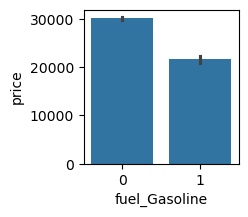

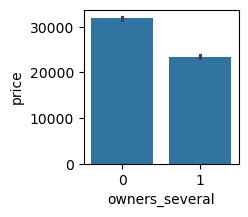

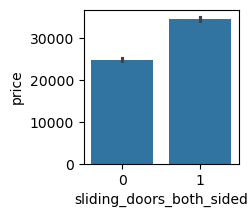

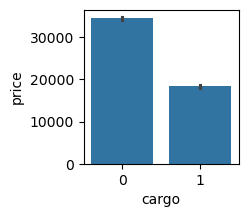

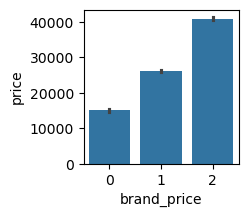

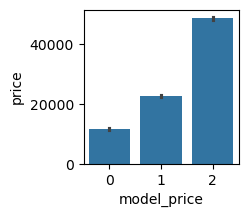

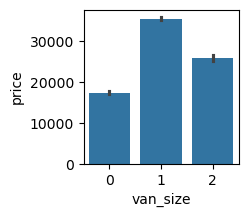

In [7926]:
for i in columnes:
    plt.figure(figsize=(2,2))
    sns.barplot(df, x=i, y='price')
    plt.show()

### 3.3.2 - Scatterplots

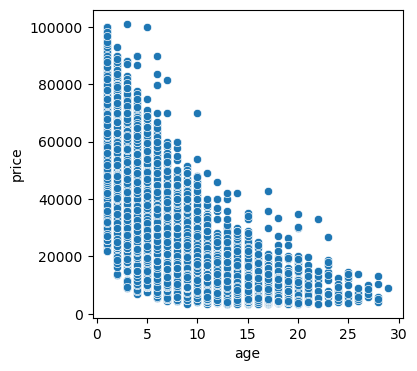

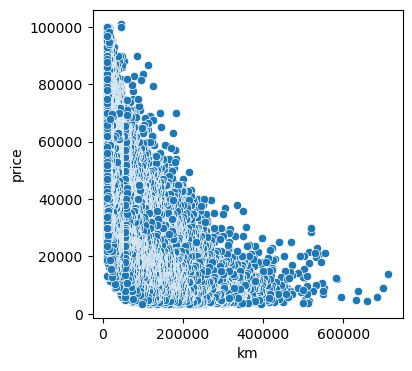

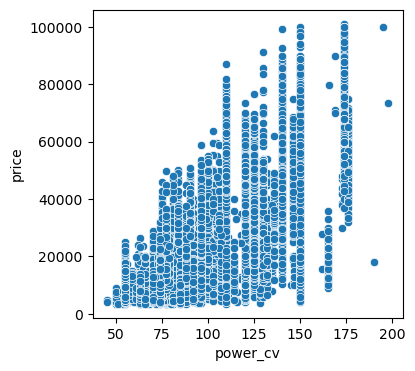

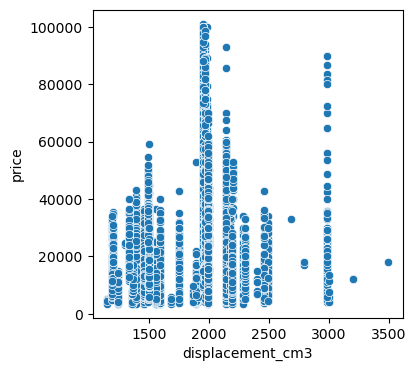

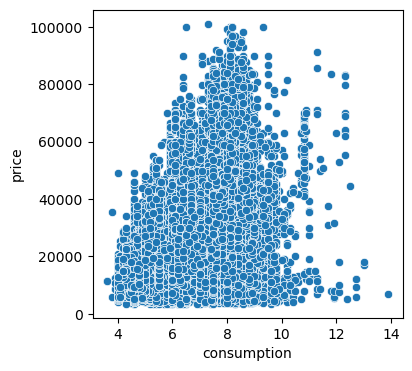

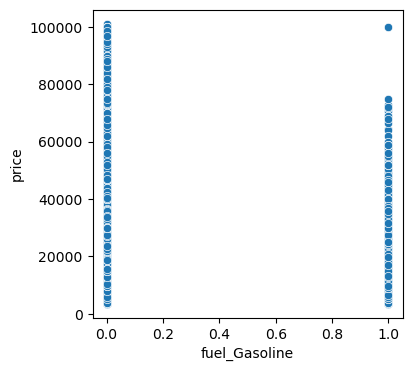

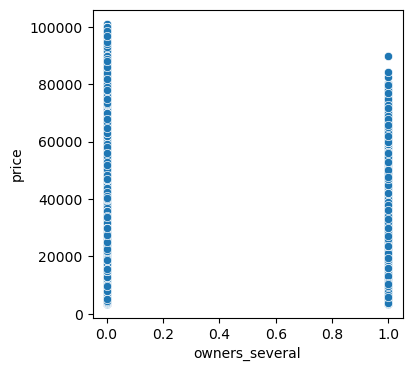

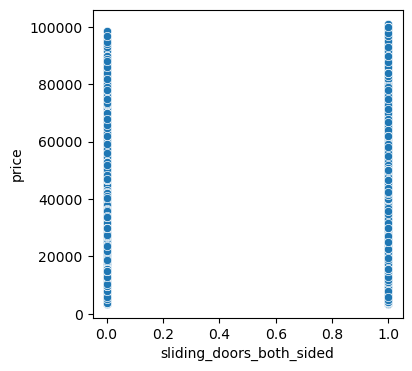

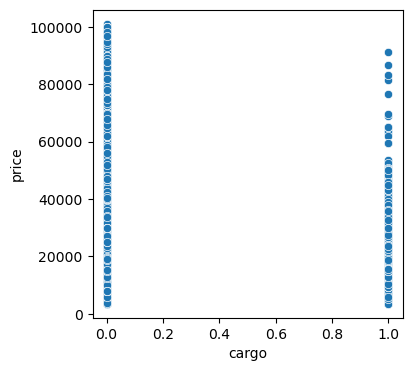

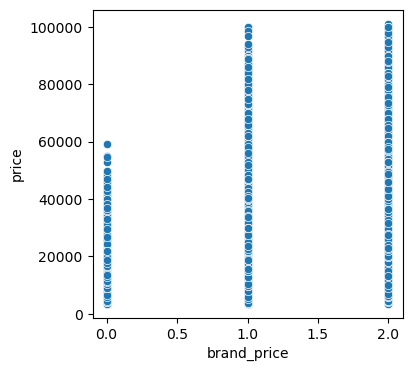

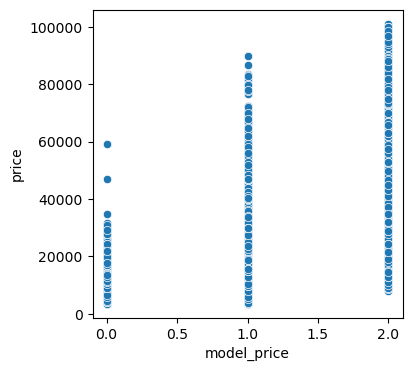

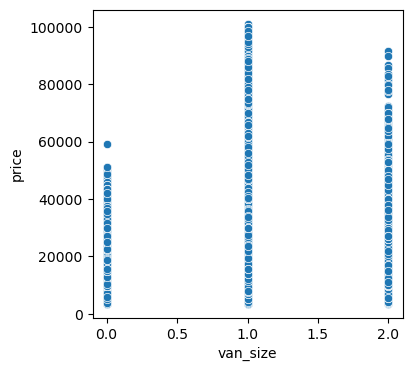

In [7927]:
numericals = df.select_dtypes(np.number)
numericals.drop(columns='price', inplace=True) # we separate the X numerical variables
for i in numericals.columns:
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df, x=i, y='price')

### 3.3.3 - Heatmap

<Axes: >

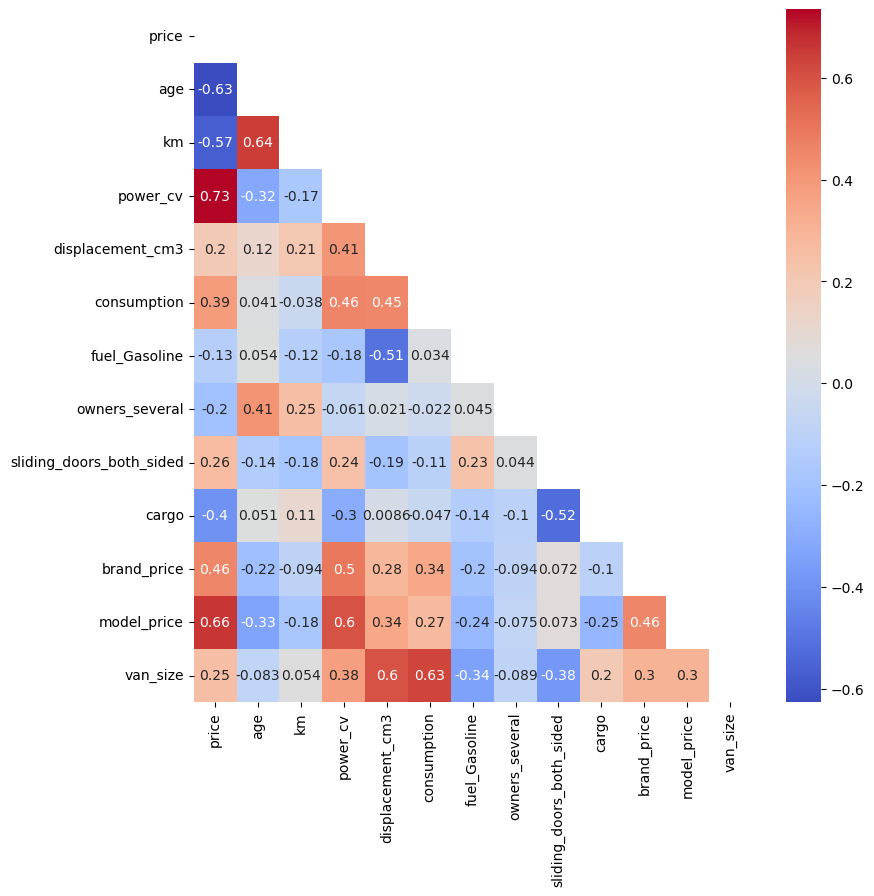

In [7928]:
numericals = df.select_dtypes(np.number)
plt.figure(figsize=(9,9))
corr = numericals.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', mask = mask)

**Calcular els VIF**

### 3.3.4 - Histplots

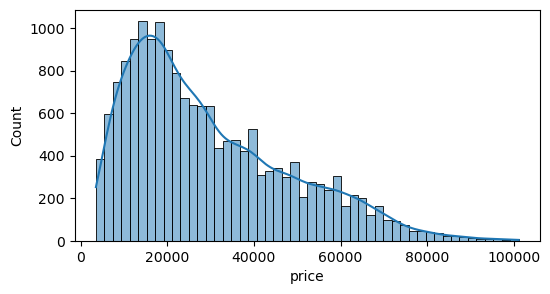

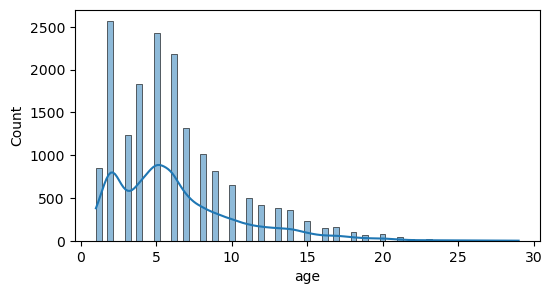

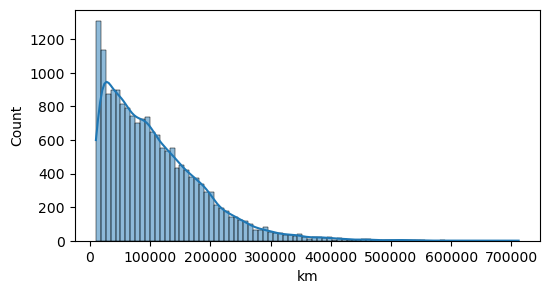

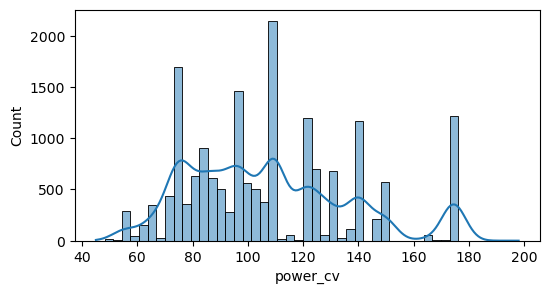

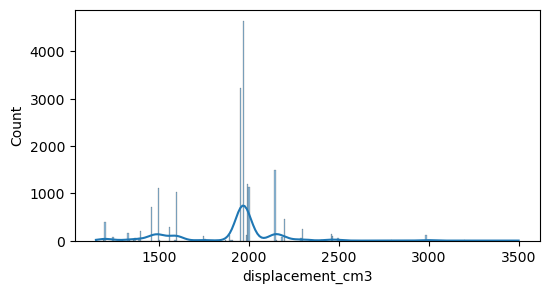

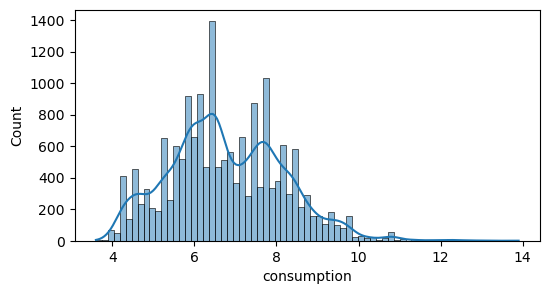

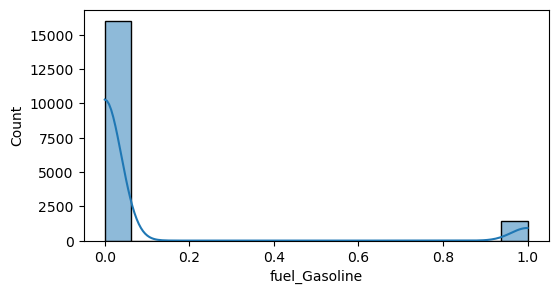

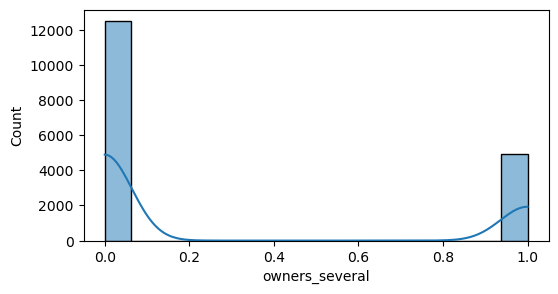

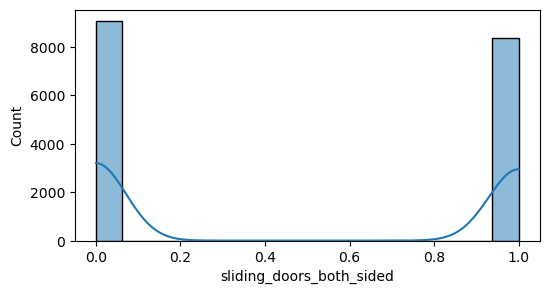

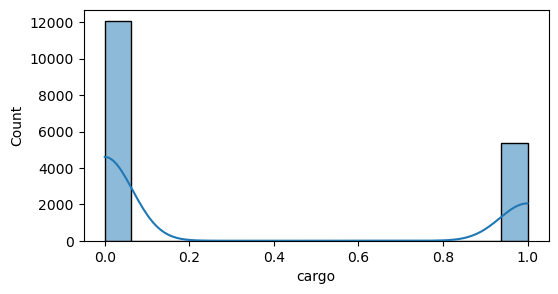

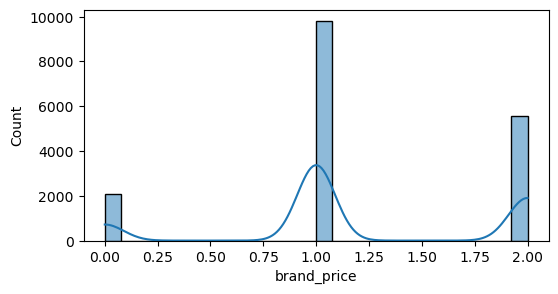

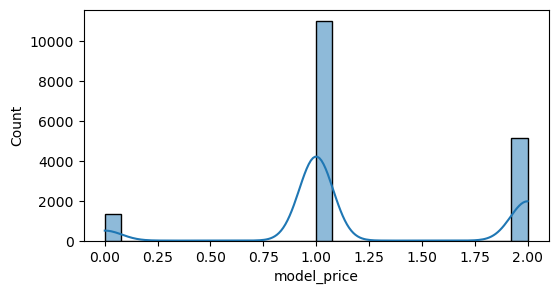

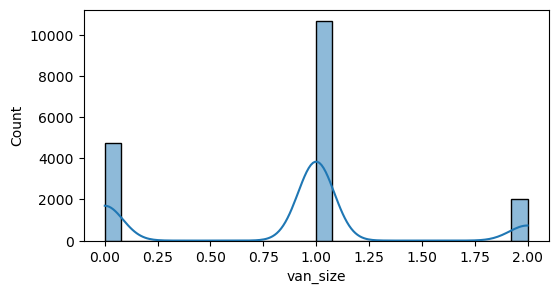

In [7929]:
for column in numericals.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(data=numericals, x=column, kde=True)
    plt.show()

# **4. Machine Learning**

In [7930]:
df.head()

,brand,model,price,age,km,power_cv,displacement_cm3,consumption,fuel_Gasoline,owners_several,sliding_doors_both_sided,cargo,brand_price,model_price,van_size
0,Mercedes-Benz,Vito,8999,12,551000,165,2987,8.6,0,1,1,1,2,1,1
1,Mercedes-Benz,V,20800,9,539000,120,2143,6.1,0,1,1,0,2,2,1
2,Mercedes-Benz,V,19900,9,531766,140,2143,6.0,0,0,1,0,2,2,1
3,Mercedes-Benz,V,28600,7,520093,140,2143,6.0,0,0,1,0,2,2,1
4,Mercedes-Benz,V,29990,8,519211,140,2143,6.0,0,0,1,0,2,2,1


I don't think ``displacement_cm3`` affects that much the price, and besides, it's not a feature that people usually know, so they wouldn't know what to answer if it's a necessary feature in the price prediction, so I drop it.

In [7931]:
df.drop(columns=['displacement_cm3'], inplace=True) 

In [7932]:
# df.to_csv('Datasets/df_final.csv', index=False) # export the df with all the changes

Let's train and test some models!

## Ordinary Least Squares

In [7933]:
OLS(df)

R2: 0.87235
MSE: 43671531.53351
MAPE: 25.48113%


## Ridge

In [7934]:
numericals = df.select_dtypes(np.number)
y = numericals['price']
X = numericals.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

alphas = [0.01, 0.1, 1, 10, 100]
for i in alphas:
    ridge = Ridge(alpha=i) 
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mape_ridge = np.mean(np.abs((y_test - y_pred_ridge)/y_test)*100)

    print(f"📘 Ridge with alpha = {i}")
    print(f"MSE: {mse_ridge:.2f}")
    print(f"R2: {r2_ridge:.8f}")
    print(f'MAPE: {mape_ridge:.6f}%\n')

📘 Ridge with alpha = 0.01
MSE: 43671526.52
R2: 0.87234646
MAPE: 25.481113%

📘 Ridge with alpha = 0.1
MSE: 43671481.43
R2: 0.87234660
MAPE: 25.480975%

📘 Ridge with alpha = 1
MSE: 43671038.75
R2: 0.87234789
MAPE: 25.479595%

📘 Ridge with alpha = 10
MSE: 43667407.74
R2: 0.87235850
MAPE: 25.466438%

📘 Ridge with alpha = 100
MSE: 43697443.51
R2: 0.87227071
MAPE: 25.374208%



The best is alpha = 100

In [7935]:
# let's try scaling the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

ridge = Ridge(alpha=100)  # alpha controla la fuerza de la penalización. Cuanto más grande sea alpha, más se encogen los coeficients. 
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mape_ridge = np.mean(np.abs((y_test - y_pred_ridge)/y_test)*100)

print(f"📘 Ridge with alpha = {i}")
print(f"MSE: {mse_ridge:.2f}")
print(f"R2: {r2_ridge:.8f}")
print(f'MAPE: {mape_ridge:.6f}%\n')

📘 Ridge with alpha = 100
MSE: 43676652.70
R2: 0.87233148
MAPE: 25.422752%



It's almost the same, scaling doesn't really affect here.

## Lasso

In [7936]:
numericals = df.select_dtypes(np.number) 
y = numericals['price']
X = numericals.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in alphas:
    lasso = Lasso(alpha=i) 
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    mape_lasso = np.mean(np.abs((y_test - y_pred_lasso)/y_test)*100)

    print(f"📘 Lasso with alpha = {i}")
    print(f"MSE: {mse_lasso:.2f}")
    print(f"R2: {r2_lasso:.8f}")
    print(f'MAPE: {mape_lasso:.6f}%\n')

📘 Lasso with alpha = 0.0001
MSE: 43671531.53
R2: 0.87234645
MAPE: 25.481128%

📘 Lasso with alpha = 0.001
MSE: 43671531.52
R2: 0.87234645
MAPE: 25.481127%

📘 Lasso with alpha = 0.01
MSE: 43671531.44
R2: 0.87234645
MAPE: 25.481109%

📘 Lasso with alpha = 0.1
MSE: 43671531.12
R2: 0.87234645
MAPE: 25.480932%

📘 Lasso with alpha = 1
MSE: 43671678.08
R2: 0.87234602
MAPE: 25.479099%

📘 Lasso with alpha = 10
MSE: 43674851.18
R2: 0.87233675
MAPE: 25.465113%

📘 Lasso with alpha = 100
MSE: 44131952.70
R2: 0.87100062
MAPE: 25.493132%



Again, the best is alpha = 100

In [7937]:
'''
📘 Ridge with alpha = 100
MSE: 44073584.04
R2: 0.87093907
MAPE: 25.572064%

📘 Lasso with alpha = 100
MSE: 44319339.54
R2: 0.87021942
MAPE: 25.603137%
'''

'\n📘 Ridge with alpha = 100\nMSE: 44073584.04\nR2: 0.87093907\nMAPE: 25.572064%\n\n📘 Lasso with alpha = 100\nMSE: 44319339.54\nR2: 0.87021942\nMAPE: 25.603137%\n'

Ridge is slightly better than Lasso, though almost the same

In [7938]:
# let's try scaling the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

lasso = Lasso(alpha=100)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mape_lasso = np.mean(np.abs((y_test - y_pred_lasso)/y_test)*100)

print(f"📘 Lasso with alpha = {i}")
print(f"MSE: {mse_lasso:.2f}")
print(f"R2: {r2_lasso:.8f}")
print(f'MAPE: {mape_lasso:.6f}%\n')

📘 Lasso with alpha = 100
MSE: 43821340.05
R2: 0.87190855
MAPE: 25.388429%



Like before, it's almost the same, scaling doesn't really affect here.

## Polynomial features

In [7939]:
numericals = df.select_dtypes(np.number) # amb totes les variables
y = numericals['price']
X = numericals.drop(columns=['price'])

degrees = range(1,5)
for degree in degrees:
    poly_reg = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    poly_reg.fit(X_train, y_train)
    y_train_pred = poly_reg.predict(X_train)
    y_test_pred = poly_reg.predict(X_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_poly = mean_squared_error(y_test, y_test_pred)
    mape_poly = np.mean(np.abs((y_test - y_test_pred)/y_test)*100)

    print(f"📘 Polynomial features with degree = {degree}")
    print(f"R2 train: {r2_train:.8f}")
    print(f"R2 test: {r2_test:.8f}")
    print(f"MAPE: {mape_poly:.8f}")
    print(f"MSE: {mse_poly:.8f}\n")

📘 Polynomial features with degree = 1
R2 train: 0.86747209
R2 test: 0.87234645
MAPE: 25.48112853
MSE: 43671531.53350896

📘 Polynomial features with degree = 2
R2 train: 0.92061806
R2 test: 0.91955828
MAPE: 15.43573414
MSE: 27519900.31005142

📘 Polynomial features with degree = 3
R2 train: 0.91889487
R2 test: 0.91620297
MAPE: 17.14335297
MSE: 28667787.41313057

📘 Polynomial features with degree = 4
R2 train: -0.82894549
R2 test: -1.73933547
MAPE: 96.47364244
MSE: 937153529.80853772



The best is **degree 3**

In [7940]:
# let's try scaling the features

numericals = df.select_dtypes(np.number)
y = numericals['price']
X = numericals.drop(columns=['price'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

poly_reg = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)
poly_reg.fit(X_train, y_train)
y_train_pred = poly_reg.predict(X_train)
y_test_pred = poly_reg.predict(X_test)

# Calculate metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_poly = mean_squared_error(y_test, y_test_pred)
mape_poly = np.mean(np.abs((y_test - y_test_pred)/y_test)*100)

print(f"📘 Polynomial features with degree = 3")
print(f"R2 train: {r2_train:.8f}")
print(f"R2 test: {r2_test:.8f}")
print(f"MAPE: {mape_poly:.8f}")
print(f"MSE: {mse_poly:.8f}")

📘 Polynomial features with degree = 3
R2 train: 0.92775716
R2 test: 0.92461030
MAPE: 15.53278587
MSE: 25791555.07698913


Like before, it's almost the same, scaling doesn't really affect here.

## **K Nearest Neighbors**

In [7941]:
numericals = df.select_dtypes(np.number) 
y = numericals['price']
X = numericals.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) 

metrics=["euclidean", "manhattan", "minkowski"]
n=[3, 5, 7]

for neighbor in n:
    for metric in metrics:
        knn_reg = KNeighborsRegressor(n_neighbors=neighbor, weights='distance', metric=metric)
        knn_reg.fit(X_train, y_train)
        y_pred = knn_reg.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred)/y_test)*100)

        print(f"📘 KNN with {neighbor} neighbors, weight = 'uniform', metric = {metric}")
        print(f"R2 test: {r2:.5f}")
        print(f"MAPE: {mape:.5f}%")
        print(f"MSE: {mse:.5f}\n")

📘 KNN with 3 neighbors, weight = 'uniform', metric = euclidean
R2 test: 0.68768334
MAPE: 36.63185957
MSE: 106846593.78123371

📘 KNN with 3 neighbors, weight = 'uniform', metric = manhattan
R2 test: 0.71041946
MAPE: 35.27261154
MSE: 99068342.68938145

📘 KNN with 3 neighbors, weight = 'uniform', metric = minkowski
R2 test: 0.68768334
MAPE: 36.63185957
MSE: 106846593.78123371

📘 KNN with 5 neighbors, weight = 'uniform', metric = euclidean
R2 test: 0.69360494
MAPE: 36.71908652
MSE: 104820754.20688698

📘 KNN with 5 neighbors, weight = 'uniform', metric = manhattan
R2 test: 0.71362957
MAPE: 35.54043118
MSE: 97970133.06516014

📘 KNN with 5 neighbors, weight = 'uniform', metric = minkowski
R2 test: 0.69360494
MAPE: 36.71908652
MSE: 104820754.20688698

📘 KNN with 7 neighbors, weight = 'uniform', metric = euclidean
R2 test: 0.68362047
MAPE: 37.41758796
MSE: 108236541.31615533

📘 KNN with 7 neighbors, weight = 'uniform', metric = manhattan
R2 test: 0.70971495
MAPE: 36.12834953
MSE: 99309360.99639

Weight: **distance**, uniform is worse

Neighbors: **5**

Metric: **manhattan**

In [7951]:
# let's try scaling the features

numericals = df.select_dtypes(np.number)  # Select numerical variables
y = numericals['price']
X = numericals.drop(columns=['price'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan')
knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)  # Safe since y_test is always positive

# Print results
print(f"📘 KNN with 5 neighbors and metric = manhattan")
print(f"R2: {r2:.5f}")
print(f"MAPE: {mape:.5f}%")
print(f"MSE: {mse:.5f}\n")

📘 KNN with 5 neighbors and metric = manhattan
R2: 0.93198
MAPE: 14.47199%
MSE: 23271323.43475



Trying different sizes of train and test

In [7943]:
numericals = df.select_dtypes(np.number) 
y = numericals['price']
X = numericals.drop(columns=['price'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

train_size = [x/100 for x in range (80,100, 5)]
for size in train_size:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=size, random_state=42)

    knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan')
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)  # Safe since y_test is always positive

    # Print results
    print(f"📘 KNN with train size = {size}")
    print(f"R2: {r2:.8f}")
    print(f"MAPE: {mape:.8f}")
    print(f"MSE: {mse:.8f}\n")

📘 KNN with train size = 0.8
R2: 0.93197704
MAPE: 14.47198765
MSE: 23271323.43474500

📘 KNN with train size = 0.85
R2: 0.93059747
MAPE: 14.50071160
MSE: 23650039.26730889

📘 KNN with train size = 0.9
R2: 0.92722165
MAPE: 14.93034991
MSE: 24485226.74835083

📘 KNN with train size = 0.95
R2: 0.92171192
MAPE: 15.26139461
MSE: 26801234.30224825



Best R2 and MSE: 0.95

Best MAPE: 0.97

## Support Vector Regression

In [401]:
numericals = df.select_dtypes(np.number)
y = numericals['price']
X = numericals.drop(columns=['price'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42) 

C_values = [1, 5, 10]
epsilon_values = [0.1, 0.5, 1]

for C in C_values:
    for epsilon in epsilon_values:
        svr = SVR(kernel='linear', C=C, epsilon=epsilon) 
        svr.fit(X_train, y_train)
        y_pred = svr.predict(X_test)
       
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred)/y_test)*100)

        print(f"📘 SVR, C = {C}, epsilon = {epsilon}")
        print(f"R2 test: {r2:.8f}")
        print(f"MAPE: {mape:.8f}")
        print(f"MSE: {mse:.8f}\n")

📘 SVR, C = 1, epsilon = 0.1
R2 test: 0.80818265
MAPE: 24.36658933
MSE: 65504548.57085333

📘 SVR, C = 1, epsilon = 0.5
R2 test: 0.80818514
MAPE: 24.36655646
MSE: 65503696.42445843

📘 SVR, C = 1, epsilon = 1
R2 test: 0.80818648
MAPE: 24.36640869
MSE: 65503238.39583439

📘 SVR, C = 5, epsilon = 0.1
R2 test: 0.85965035
MAPE: 23.87614958
MSE: 47928615.44309958

📘 SVR, C = 5, epsilon = 0.5
R2 test: 0.85964948
MAPE: 23.87649372
MSE: 47928914.15830794

📘 SVR, C = 5, epsilon = 1
R2 test: 0.85964993
MAPE: 23.87685184
MSE: 47928759.67430305

📘 SVR, C = 10, epsilon = 0.1
R2 test: 0.86436322
MAPE: 24.24410922
MSE: 46319196.74933300

📘 SVR, C = 10, epsilon = 0.5
R2 test: 0.86436452
MAPE: 24.24370975
MSE: 46318755.30300444

📘 SVR, C = 10, epsilon = 1
R2 test: 0.86436697
MAPE: 24.24362422
MSE: 46317918.95417951



Best: C = 10, epsilon = 1

In [ ]:
input_features = [age, km, power_cv, displacement_cm3, consumption, fuel, owners, rear_doors, cargo, brand_price, model_price, van_size]

# Scale the input (same scaling transformation as for training data)
input_data = scaler.transform([input_features])

# Make the prediction with the trained KNN model
prediction = knn_reg.predict(input_data)

print(f"Predicted price: {prediction[0].astype(int)} €")

Predicted price: 35480 €


## **Predictions** (with KNN)

In [7156]:
age = int(input(f'Age'))
km = int(input(f'Km'))
power_cv = int(input(f'Horsepower in cv'))
consumption = input(f'Consumption (L/100km)')
fuel = int(input(f'Fuel: Diesel (0) or Gasoline (1)'))
owners = int(input(f'More than one previous owners? Yes (1) or No (0)'))
rear_doors  = int(input(f'Both rear doors? Yes (1) or No (0)'))
cargo = int(input(f'Passenger van (0) or cargo van (1)?'))
brand_price = int(input(f'Price of the brand: cheap (0), medium (1) or expensive (2)'))
model_price = int(input(f'Price of the model: cheap (0), medium (1) or expensive (2)'))
van_size = int(input(f'Size of the van: small (0), medium (1) or big (2)'))

In [7157]:
df = pd.read_csv('Datasets/df_final.csv')
numericals = df.select_dtypes(np.number) 
y = numericals['price']
X = numericals.drop(columns=['price'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

# Make the prediction with the trained KNN model
knn_reg = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan')
knn_reg.fit(X_train, y_train)

input_features = [age, km, power_cv, consumption, fuel, owners, rear_doors, cargo, brand_price, model_price, van_size]

input_data = scaler.transform([input_features])
prediction = knn_reg.predict(input_data)

print(f"Predicted price: {prediction[0].astype(int)} €")

Predicted price: 15613 €


## **VIF**

Without ``price``

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
numericals = df.select_dtypes(np.number)
variables = numericals.copy()
variables.drop(columns=["price"], inplace=True)
vif_data = pd.DataFrame()
vif_data["Variable"] = variables.columns
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

vif_data

,Variable,VIF
0,age,7.882522
1,km,5.004717
2,power_cv,31.530700
3,consumption,39.700090
4,fuel_Gasoline,1.547881
5,owners_several,1.728780
6,sliding_doors_both_sided,3.271072
7,cargo,1.855861
8,brand_price,6.773920
9,model_price,9.929514


In [7947]:
# numericals = df.select_dtypes(np.number)
# variables = numericals.copy()
# variables.drop(columns=["price"], inplace=True)

def calcular_vif(numericals):
    """Calcula el VIF para cada variable en el DataFrame."""

    vif_data = pd.DataFrame()
    vif_data["Variable"] = numericals.columns
    vif_data["VIF"] = [variance_inflation_factor(numericals.values, i) for i in range(numericals.shape[1])]
    return vif_data

def eliminar_variables_vif(numericals, umbral=10):
    """
    Elimina las variables con el mayor VIF de forma iterativa 
    hasta que todas las variables tengan un VIF inferior al umbral.
    """
    iteracion = 1
    while True:
        print(f"\n--- Iteración {iteracion} ---")
        
        vif_data = calcular_vif(numericals)
        print(vif_data)
        
        max_vif = vif_data["VIF"].max()
        if max_vif < umbral:
            print("\n✅ Todas las variables tienen VIF menor que", umbral)
            break
       
        variable_a_eliminar = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        print(f"\n⚠️ Se eliminará la variable con mayor VIF: {variable_a_eliminar} (VIF={max_vif})")
        
        numericals = numericals.drop(columns=[variable_a_eliminar])
        
        iteracion += 1
        
    print("\n📊 Proceso finalizado. Variables restantes:")
    print(numericals.columns)
    return numericals, vif_data

data_final, vif_final = eliminar_variables_vif(numericals, umbral=15)


--- Iteración 1 ---
                    Variable        VIF
0                      price  26.709328
1                        age   9.710436
2                         km   6.681523
3                   power_cv  41.559163
4                consumption  47.788912
5              fuel_Gasoline   1.621229
6             owners_several   1.728801
7   sliding_doors_both_sided   3.271304
8                      cargo   2.294046
9                brand_price   6.795867
10               model_price  11.947293
11                  van_size   6.855677

⚠️ Se eliminará la variable con mayor VIF: consumption (VIF=47.78891241103615)

--- Iteración 2 ---
                    Variable        VIF
0                      price  22.188468
1                        age   6.512174
2                         km   6.605966
3                   power_cv  38.961952
4              fuel_Gasoline   1.271957
5             owners_several   1.722523
6   sliding_doors_both_sided   3.248370
7                      cargo   1.96731

Deleted features: ``consumption`` and ``power_cv``

In [429]:
vif_final

,Variable,VIF
0,price,12.131209
1,age,6.024538
2,km,5.655477
3,fuel_Gasoline,1.253917
4,owners_several,1.719392
5,sliding_doors_both_sided,2.870410
6,cargo,1.752600
7,brand_price,6.547994
8,model_price,11.716821
9,van_size,4.828158
